# Enzyme Kinetic Parameter Inference
> Supposing you observe a timeseries of concentrations of metabolites, can you infer the kinetic parameters for the enzyme? 

In [5]:
#collapse
# imports
from itertools import combinations_with_replacement, product
from collections import Counter
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches
from matplotlib.colors import to_hex
import scipy.stats
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.stats.kde import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import Matern

import ipywidgets as widgets
from IPython.display import display

%config InlineBackend.figure_format = 'retina'

# from IPython.display import set_matplotlib_formats
%matplotlib inline
# set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000

exp = np.exp
sqrt = np.sqrt
Π = np.prod
π = np.pi
N = np.random.normal

def hex_to_rgb(h): return [int(h.lstrip('#')[i:i+2], 16)/256 for i in (0, 2, 4)]


In [2]:
#collapse
# resize figure special function
from IPython.core.display import Image, HTML
import io
import binascii

def resize_fig(width, height):

    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight", dpi=200)
    plt.close()

    return HTML(f'<img width="{width}" height="{height}" class="keep_dims" src="data:image/png;base64,{binascii.b2a_base64(s.getvalue()).decode()}&#10;">')


In [3]:
%%javascript
require.config({
    paths: {
        d3: 'https://d3js.org/d3.v5.min'
    }
});

<IPython.core.display.Javascript object>

In [4]:
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


numpy 1.18.1
pandas 1.0.4
scipy 1.4.1
seaborn 0.11.0
ipywidgets 7.6.3


## 1. Background

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}
\newcommand{\kcat}{k_{\mathrm{cat}}}
\newcommand{\kuncat}{k_{\mathrm{uncat}}}
\newcommand{\kms}{k_{m,\mathrm{S}}}
\newcommand{\kmp}{k_{m,\mathrm{P}}}
\newcommand{\dSdt}{\frac{d[\mathrm{S}]}{dt}}
\newcommand{\dEdt}{\frac{d[\mathrm{E}]}{dt}}
\newcommand{\dESdt}{\frac{d[\mathrm{ES}]}{dt}}
\newcommand{\dPdt}{\frac{d[\mathrm{P}]}{dt}}$$

### 1.1 Enzyme Kinetics
Enzymes catalyze many critical chemical reactions in cells. 

Describing a cell with a mathematical model (a long-standing goal of computational biologists) would entail modelling each enzyme-catalyzed chemical reaction. 

However, although we may know the _scheme_ for many enzymatic reactions (the responsible enzyme, the associated substrates, and resultant products) we are often missing many of the details needed to construct a faithful mathematical model of the reaction. 

Let's begin by introducing the mathematical model used to describe enzymatic reaction schemes. Consider the following enzymatically-catalyzed (uni uni) chemical reaction scheme:

$$ E+S \underset{\koff}{\overset{\kon}{\rightleftarrows}} ES \underset{\kuncat}{\overset{\kcat}{\rightleftarrows}}E+P $$

In this scheme E is an enzyme, S is its substrate, ES is the enzyme-substrate complex, which is an intermediate, and P is the product of the reaction. Each of those chemical species has a concentration in a fixed volume, which we denote with brackets (e.g. $[\mathrm{E}]$ = enzyme concentration). 

If we make the simplifying assumption that the 4 molecular species are 'well-mixed' in solution, we can invoke the '[Law of Mass Action](https://en.wikipedia.org/wiki/Law_of_mass_action)' under which the rate of each of the four included reactions is linear in the concentrations of the reactants (with an associated coefficient called the rate constant). The reactions in the above scheme are: enzyme-substrate association ($\kon$), dissociation ($\koff$), enzyme catalysis of substrate into product ($\kcat$), and enzyme-product re-association ("uncatalysis", $\kuncat$). The designation of 'substrate' and 'product' is our choice -- the model is entirely symmetric, which is reflected in the associated ODEs:

$$\begin{aligned}
    \frac{d[\mathrm{S}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\
    \frac{d[\mathrm{E}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] + k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{ES}]}{dt} &= - k_{\mathrm{off}}[\mathrm{ES}] + k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] - k_{\mathrm{cat}}[\mathrm{ES}] + k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{P}]}{dt} &= k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] 
\end{aligned}$$

This differential equation model describing the (deterministic) chemical kinetics for an enzymatically-catalyzed reaction in well-mixed conditions contains 4 kinetic parameters, i.e. 4 degrees of freedom, which we do not know _a priori_. These will be the subject of inference.

> Note: the intracellular environment is not best described as well-mixed, and models of '[Macromolecular Crowding](https://en.wikipedia.org/wiki/Macromolecular_crowding)' have led to more accurate rate laws for these reactions _in vivo_. However, we will retain the well-mixed assumption for now.

### 1.2 Parameter Inference

There are 3 typical problems associated with ODE models:

- Supplied with a complete specification of the system, the **forward problem** is to integrate the differential equations from some initial conditions forwards in time and predict the trajectory of the system. This is what is typically meant by "solving" the ODE system, but exact analytical solutions are rare, and [numerical methods](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) are often brought to bear to approximate system trajectories.
- Supplied with one or more trajectories (data) but incomplete specification of the system, the **inverse problem** is to estimate parameters of the system (coefficients in the ODE expressions). 
- Finally, given some manipulable inputs, the **control problem** is to drive the system towards some desired state.

This post will explore a range of approaches for the inverse problem. Our goal will be to estimate the kinetic parameters of enzymatically-catalyzed chemical reactions from timeseries of concentrations of the molecular species. 

> Note: enzyme kinetic parameters are typically not inferred from metabolite timeseries data using the methods we will describe, but instead from specific [enzyme assays](https://en.wikipedia.org/wiki/Enzyme_assay). However, at the moment, these assays are limited to studying one enzyme at a time. The inference approaches described in this post can leverage data from emerging high-throughput assays. 


The determination of the kinetic parameters for the enzymatic reactions of life is a major project, and reported values have been tabulated in databases such as [BRENDA](https://www.brenda-enzymes.org/). However, my experience with these databases has been that the reported kinetic parameters are not internally consistent. 


### 1.3 The Michaelis-Menten/Briggs-Haldane Approximation

Two assumptions commonly made at this point are:
1. to assume the initial substrate concentration is much larger than the enzyme concentration ($[\mathrm{S_0}] \gg [\mathrm{E_0}]$). 
2. to suppose that the rates of enzyme-substrate association ($\kon$) and dissociation ($\koff$) are greater than the rates of catalysis and uncatalysis (i.e. $\kon$, $\koff$ $\gg$ $\kcat$, $\kuncat$). 


These assumptions permit a [timescale separation argument](http://www.bio-physics.at/wiki/index.php?title=Separation_of_Timescales) called the "Quasi-Steady-State Approximation" (QSSA) in which we set $\dESdt = 0$, which enables the [derivation](http://www.bio-physics.at/wiki/index.php?title=Reversible_Michaelis_Menten_Kinetics) of the traditional Reversible Michaelis-Menten/Briggs-Haldane expression:

$$\begin{aligned}
\frac{d[\mathrm{P}]}{dt} &= 
\frac{
\frac{\kcat \, [\mathrm{E_T}] [\mathrm{S}]}{K_{m,\mathrm{S}}} - 
\frac{\koff \, [\mathrm{E_T}] [\mathrm{P}]}{K_{m,\mathrm{P}}}}
{1+\frac{[\mathrm{S}]}{K_{m,\mathrm{S}}} + \frac{[\mathrm{P}]}{K_{m,\mathrm{P}}}} \\ \\
\frac{d[\mathrm{S}]}{dt} &= -\frac{d[\mathrm{P}]}{dt}
\end{aligned}$$

in which we have introduced the "Michaelis Constants": $K_{m,\mathrm{S}} = \frac{\koff + \kcat}{\kon}$ and $K_{m,\mathrm{P}} = \frac{\koff + \kcat}{\kuncat}$. 

The QSSA reduces the system from 4 variables to 2. However, there are still 4 kinetic parameters to estimate in this reduced model. 

> Note: _another_ assumption typically made at this point is to assume that catalysis is irreversible ($\kuncat = 0$), leading to a further simplified expression for the rate of product formation $\frac{d[\mathrm{P}]}{dt}$. However, this assumption is quite often inaccurate, so we will not make it. 

## 2. Exploring the Forward Model

### 2.1 A Standard Example

Before we explore techniques to estimate enzyme kinetic parameters from timeseries data, we need to generate timeseries data to begin with. We can accomplish that by fixing kinetic parameters, then solving the forward problem. It will turn out that integrating the differential equations forwards is a subroutine of both approaches to the inverse problem we'll see in this post, so developing a method for the forward problem is hardly wasted effort.

In order to produce a trajectory, we need to set **initial conditions**. We'll integrate the reaction kinetics of a hypothetical _in vitro_ experiment, in which a fixed quantity of enzyme and substrate are added to the reaction at the outset, then left to react. 

> Note:  _in vivo_ we would expect the concetration of enzyme to vary over time, and the substrate to be replenished. We will generalize this approach to a more biologically-relevant setting in a future post.  


Our initial conditions are:

- $[E]_0$, the initial enzyme concentration, is set to 1mM (miliMolar, i.e. 1000μM). 
- $[S]_0$, the initial substrate concentration is set to 10mM.  

In [6]:
default_initial_conditions = {
    'E_0': 1e3,
    'S_0': 10e3
}

Next, let's fix some generic rate constants:
- $\kon \,$  of $10^6$ events per Mol per second, or 1 per μM per second, is a typical rate for enzyme-substrate binding.
- $\koff \,$  of 500/s results in a $\koff$/$\kon$ = $k_d$ of 500 μM, which is a typical $k_d$.
- $\kcat \,$  is 30/s, a fairly slow but respectable $\kcat$.
- $\kuncat \,$  of $\frac{\kon}{10}$ is often considered as the boundary for the QSSA to hold (so 0.1 per μM per second). Let's use $\kuncat = \frac{\kon}{100} = $ 0.01/μM for good measure.

Our units are μM and seconds. 

In [7]:
# Set default kinetic parameters
default_kinetic_params = {
    'k_on': 1,
    'k_off': 500,
    'k_cat': 30,
    'k_uncat': 0.01
}

def k_ms(p): return (p['k_off'] + p['k_cat']) / p['k_on']
def k_mp(p): return (p['k_off'] + p['k_cat']) / p['k_uncat']

default_kinetic_params['k_ms'] = k_ms(default_kinetic_params)
default_kinetic_params['k_mp'] = k_mp(default_kinetic_params)


There are a variety of numerical methods to integrate systems of differential equations. The most straightforward is [Euler's method](https://en.wikipedia.org/wiki/Euler_method), which we've written down explicitly for this system below: 

In [8]:
#collapse
# define euler_full(), which integrates the full kinetics with Euler's Method, and returns a trajectory
def euler_full(dt, steps, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):

    S = S_0
    E = E_0
    ES = 0
    P = 0
    traj = [[S, E, ES, P]]

    for _ in range(int(steps)):

        dS = k_off * ES - k_on * E * S
        dE = k_off * ES - k_on * E * S + k_cat * ES - k_uncat * E * P
        dES = k_on * E * S - k_off * ES - k_cat * ES + k_uncat * E * P
        dP = k_cat * ES - k_uncat * E * P

        S += dS * dt
        E += dE * dt
        ES += dES * dt
        P += dP * dt

        traj.append([S, E, ES, P])

    return pd.DataFrame(traj, columns=['S', 'E', 'ES', 'P'], index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6))

We'll also write down Euler's method for the Michaelis-Menten/Briggs-Haldane kinetics

In [9]:
#collapse
# define euler_MM(), which integrates the Michaelis-Menten/Briggs-Haldane kinetics
def euler_MM(dt, steps, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):

    S = S_0
    E = E_0
    P = 0
    traj = [P]

    for _ in range(int(steps)):

        dP = ((k_cat * E * S) / k_ms - (k_off * E * P) / k_mp) / (1 + S / k_ms + P / k_mp)
        dS = -dP

        P += dP * dt
        S += dS * dt

        traj.append(P)

    return pd.Series(traj, name='P_MM', index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6)).to_frame()

To simulate the kinetics with little derivative steps, we need a step size, and a number of total steps:

In [10]:
dt = 1e-6
steps = 5e5

Now we can integrate the reaction kinetics, and plot the trajectory. We'll overlay the Michaelis-Menten/Briggs-Haldane kinetics with dotted lines on top of the full kinetics (solid). 

In [11]:
default_traj_full = euler_full(dt, steps, **default_kinetic_params, **default_initial_conditions)
default_traj_mm = euler_MM(dt, steps, **default_kinetic_params, **default_initial_conditions)

In [12]:
#collapse
# figure styles
def fig_style(ax):
    for side in ["right","top"]: ax.spines[side].set_visible(False)
    ax.set_xlabel('time (s)',  weight='bold')
    ax.set_ylabel('concentration (μM)',  weight='bold')

def param_string(E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
    return f'[k_on= {k_on}/μM/s]   [k_off = {k_off}/s]   [k_cat = {k_cat}/s]   [k_uncat = {k_uncat}/μM/s]   [E₀ = {int(E_0)}μM]   [S₀ = {int(S_0)}μM]'

c = {
    'S': 'dodgerblue',
    'E': 'sienna',
    'ES': 'blue',
    'P': 'darkblue',
    'S_MM': 'steelblue',
    'P_MM': 'slateblue',
    'k_on': 'mediumseagreen',
    'k_off': 'olive',
    'k_cat': 'darkgreen',
    'k_uncat': 'darkgoldenrod',
    'k_m': 'olivedrab',
    'k_ms': 'forestgreen',
    'k_mp': 'darkkhaki',
}

c = {k:to_hex(v) for k,v in c.items()}

def color(columns): return [c[col] for col in columns]

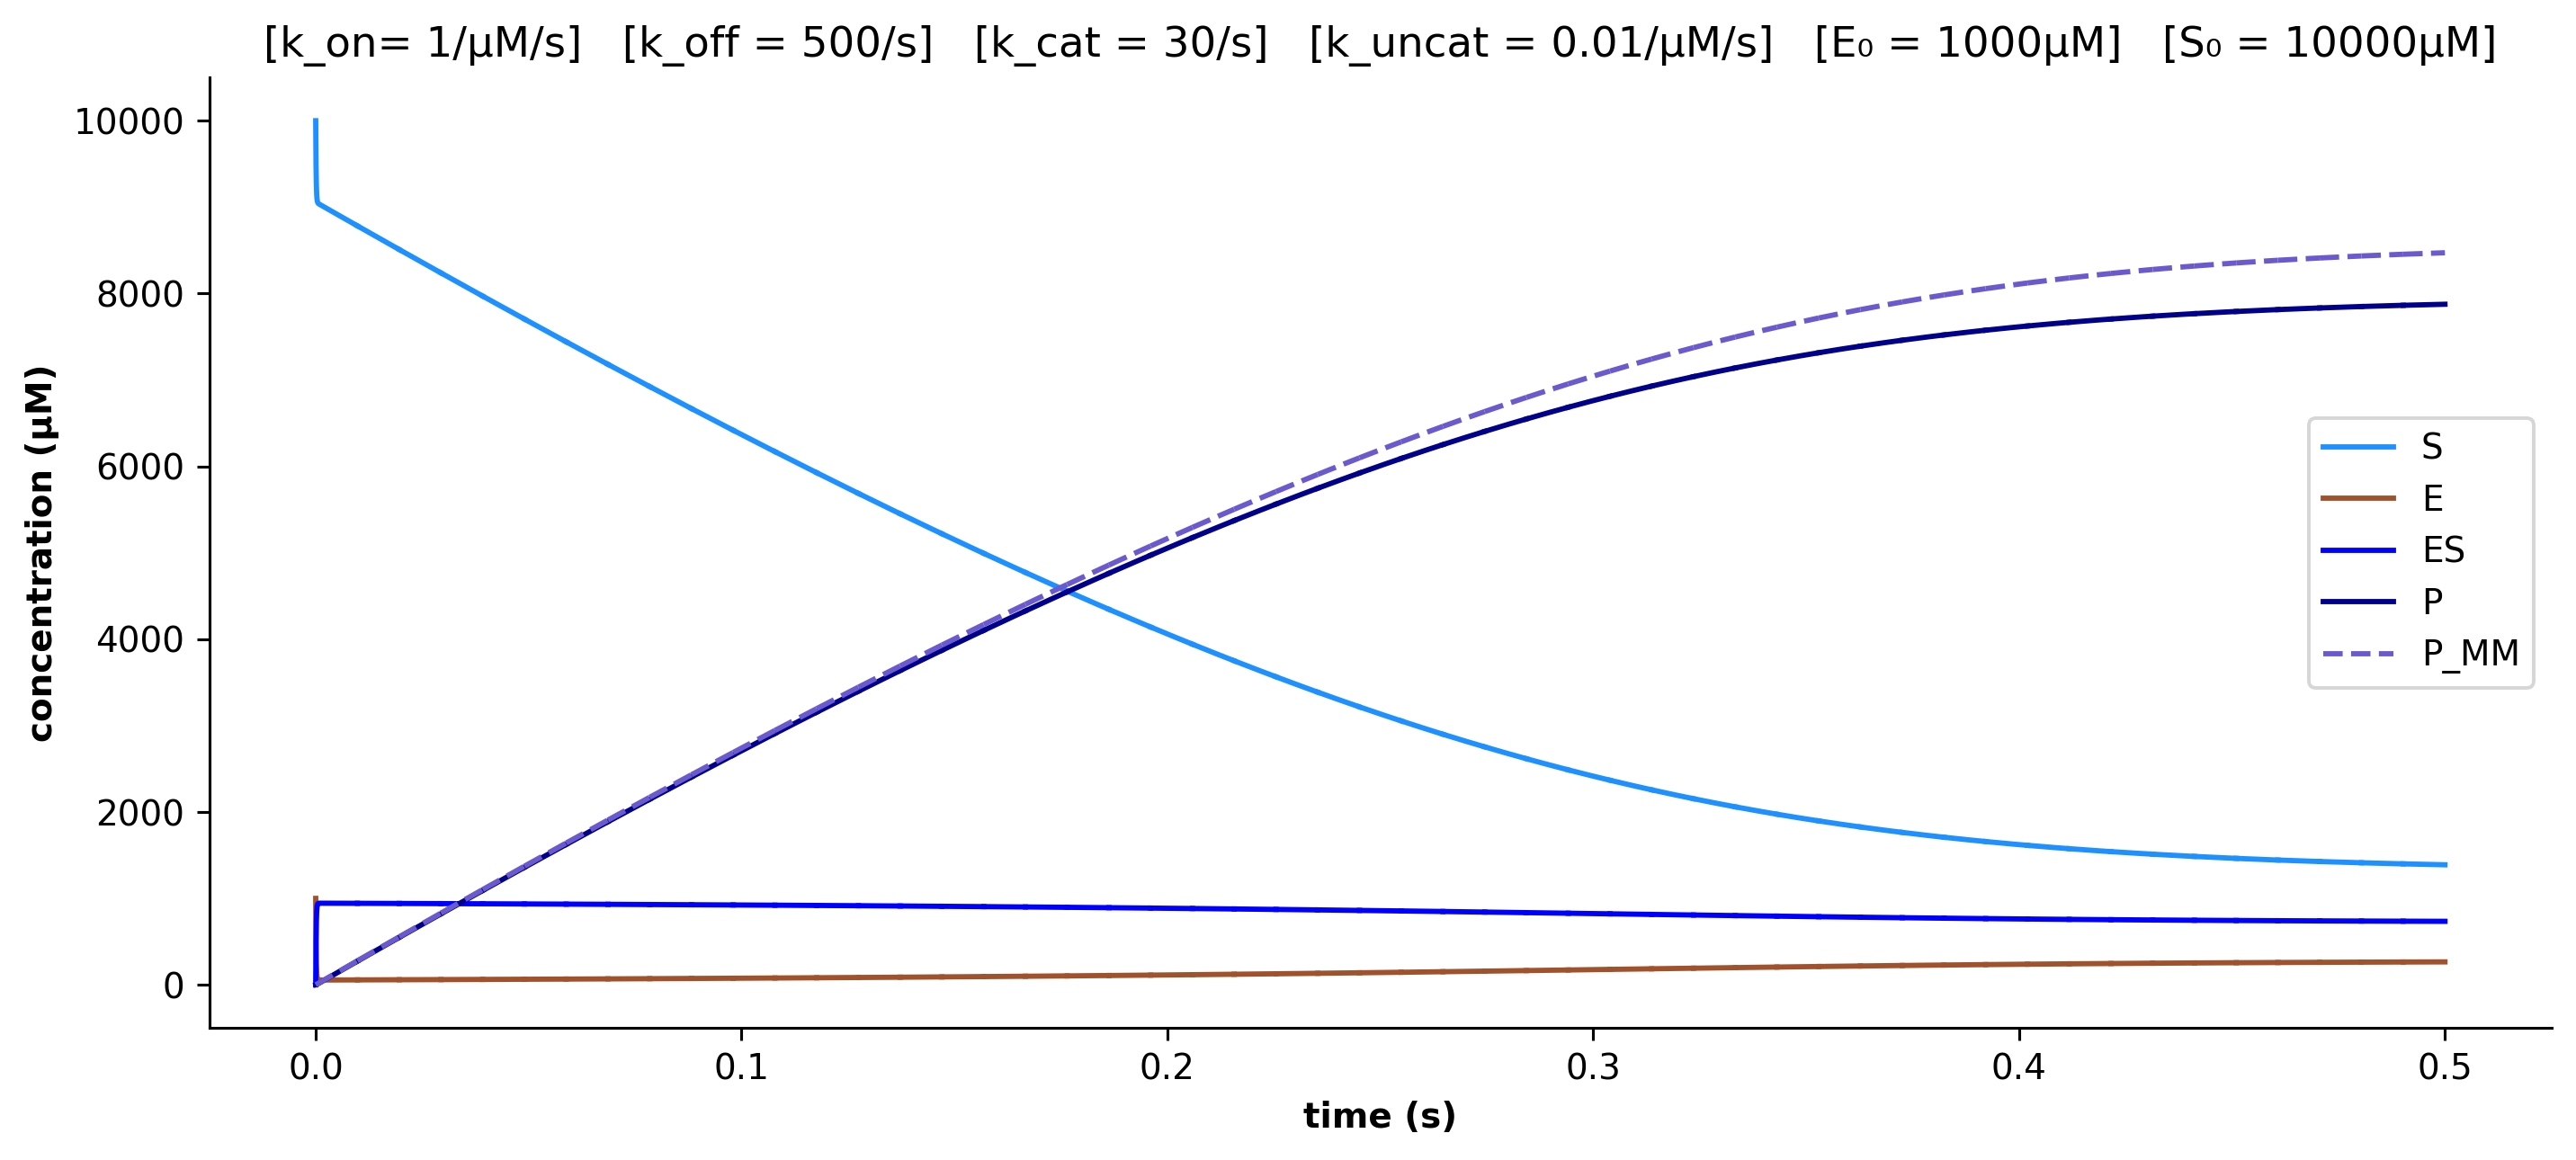

In [13]:
ax = default_traj_full.plot.line(title=param_string(**default_initial_conditions, **default_kinetic_params), color=color(default_traj_full.columns))
default_traj_mm.plot.line(ax=ax, color=color(default_traj_mm.columns), linestyle='--')

fig_style(ax)

We can plainly see the validity of the Quasi-Steady-State Approximation (QSSA) in action in the trajectory: <span style='color:#a0522d'>Enzyme <b>E</b></span> and <span style='color:#1e90ff'>Substrate <b>S</b></span> rapidly form <span style='color:#0000ff'>Enzyme-Substrate complex <b>ES</b></span>, the concentration of which remains relatively constant throughout the course of the reaction (recall the QSSA is the approximation that $\dESdt = 0$). Thus, the Michaelis-Menten/Briggs-Haldane product concentration trajectory <span style='color:#6a5acd'><b>P_MM</b></span> well approximates the full kinetics trajectory for the concentration of <span style='color:#00008b'>product <b>P</b></span>, since the requisite assumptions are valid, namely, (1) $[\mathrm{S_0}] \gg [\mathrm{E_0}]$ and (2) $\kon$, $\koff$ $\gg$ $\kcat$, $\kuncat$. 

In practice, Michaelis-Menten/Briggs-Haldane kinetics are often assumed by default, risking the possibility of their misapplication. Let's take this opportunity to explore how the MM/BH kinetics diverge from the full kinetics when we violate the requisite assumptions. 

### 2.2: Breaking the Michaelis-Menten/Briggs-Haldane Assumptions: <br /> &nbsp; &nbsp; &nbsp; Initial Substrate:Enzyme Ratio

Suppose first the number of molecules of substrate is _not_ much greater than the number of molecules of enzyme, which is a plausible regime for certain reactions _in vivo_. 

In [14]:
# Set initial enzyme and substrate concentrations: 2 molecules of substrate for each molecule of enzyme.
initial_conditions = {
    'E_0': 1e3,
    'S_0': 2e3
}

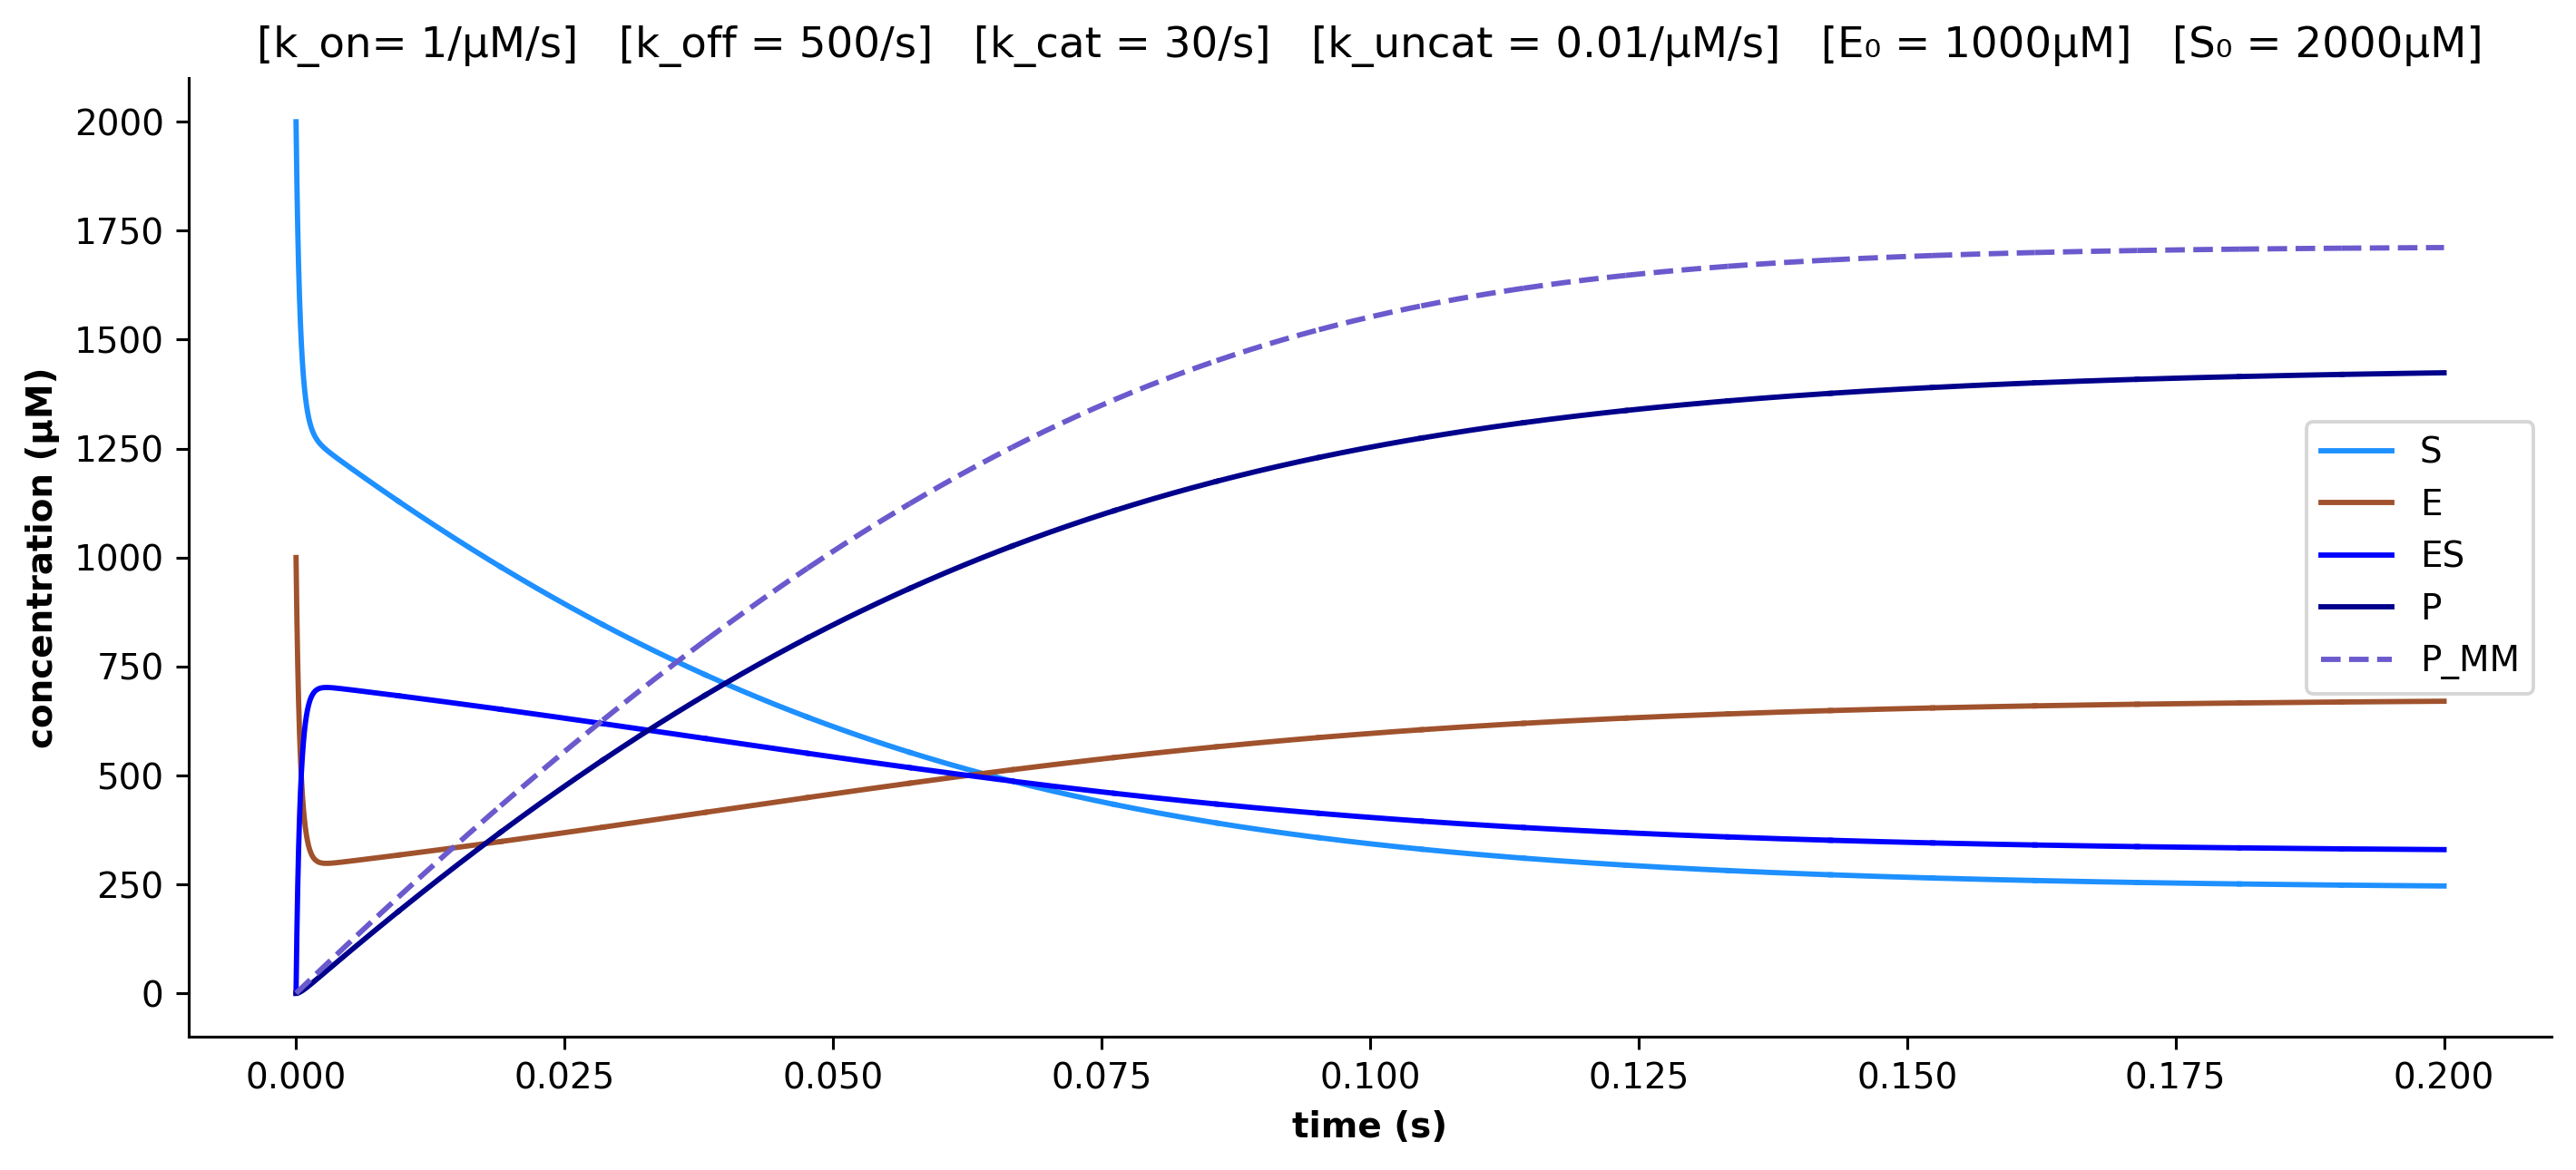

In [15]:
#collapse
traj_full = euler_full(dt, 2e5, **initial_conditions, **default_kinetic_params)
traj_mm = euler_MM(dt, 2e5, **initial_conditions, **default_kinetic_params)

ax = traj_full.plot.line(title=param_string(**initial_conditions, **default_kinetic_params), color=color(traj_full.columns))
traj_mm.plot.line(ax=ax, color=color(traj_mm.columns), linestyle='--')

fig_style(ax)

Then <span style='color:#6a5acd'><b>P_MM</b></span> worsens significantly as an estimate of <span style='color:#00008b'><b>P</b></span>.


### 2.3: Breaking the Michaelis-Menten/Briggs-Haldane Assumptions: <br /> &nbsp; &nbsp; &nbsp; Fast Enzyme-Substrate Complex Kinetics

Suppose further that the rates of association and dissociation of enzyme with subtstrate are _not_ substantially faster than those of enzyme and product. 

In [16]:
kinetic_params = {
    'k_on': 0.05,
    'k_off': 1,
    'k_cat': 50,
    'k_uncat': 0.5
}

kinetic_params['k_ms'] = k_ms(kinetic_params)
kinetic_params['k_mp'] = k_mp(kinetic_params)

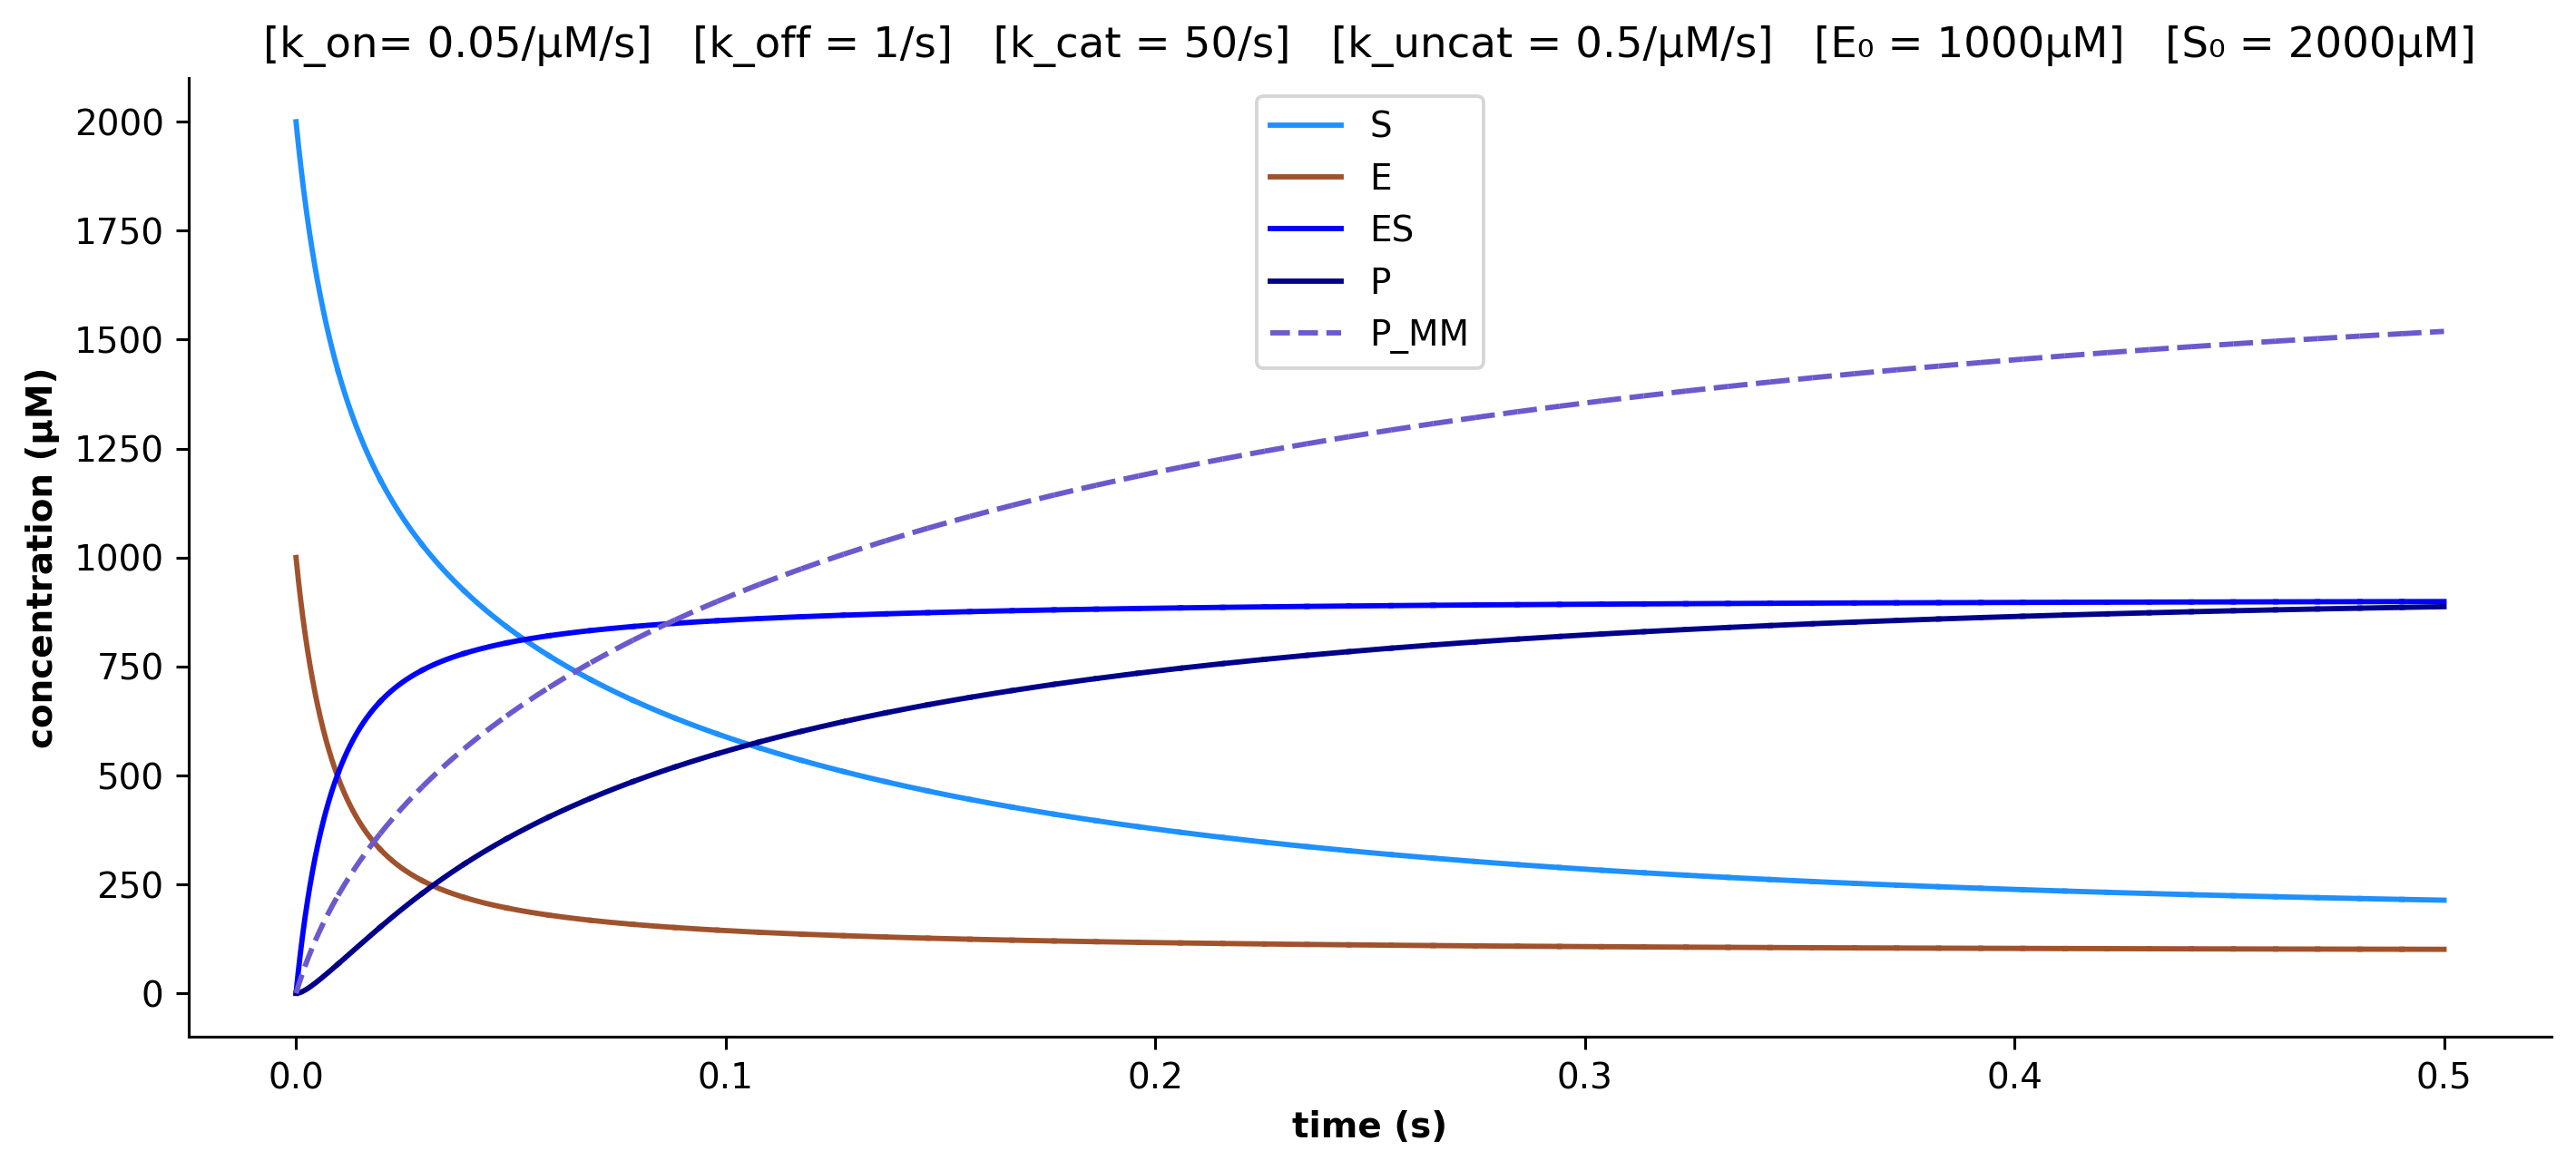

In [17]:
#collapse
traj_full = euler_full(dt, steps, **initial_conditions, **kinetic_params)
traj_mm = euler_MM(dt, steps, **initial_conditions, **kinetic_params)

ax = traj_full.plot.line(title=param_string(**initial_conditions, **kinetic_params), color=color(traj_full.columns))
traj_mm.plot.line(ax=ax, color=color(traj_mm.columns), linestyle='--')

fig_style(ax)

Then the Michaelis-Menten/Briggs-Haldane kinetics diverge further.

In each of these latter trajectories, the criteria to make the Michaelis-Menten/Briggs-Haldane approximation are violated, leading to poor approximations to the full kinetics. We belabor this point here because in the following, we will seek to infer the parameters of the kinetics, and our inference will fit poorly if we fit to inappropriate kinetic expressions.

### 2.4: Comparing Integrators

All of the above trajectories are generated by Euler's Method, the most intuitive ODE integration technique. Unfortunately, Euler's Method's naïvete has drawbacks: 
- The order of the error is large with respect to the timestep size.
- The method is slow, due to the uniform timestep size.

A variety of faster and more accurate (albeit more complicated) integrators have been proposed, many of which have implementations in scipy's <code><a href="https://docs.scipy.org/doc/scipy/reference/integrate.html">integrate</a></code> package. Due to their superior speeds and accuracies, we'll use these methods during inference. As a sanity check, we compare our basic Euler Method solver to scipy's:


In [18]:
#collapse
# define scipy_full and scipy_MM functions (and helpers) to integrate chemical kinetics with scipy
from scipy.integrate import solve_ivp

def dy_full(t, y, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
    # Y ordered S,E,ES,P
    dy = [0]*4
    dy[0] = k_off * y[2] - k_on * y[1] * y[0]
    dy[1] = k_off * y[2] - k_on * y[1] * y[0] + k_cat * y[2] - k_uncat * y[1] * y[3]
    dy[2] = k_on * y[1] * y[0] - k_off * y[2] - k_cat * y[2] + k_uncat * y[1] * y[3]
    dy[3] = k_cat * y[2] - k_uncat * y[1] * y[3]
    return dy


def dy_MM(t, y, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
    # Y ordered S,P
    dy = [0]*2
    dy[1] = ((k_cat * E_0 * y[0]) / k_ms - (k_off * E_0 * y[1]) / k_mp) / (1 + y[0] / k_ms + y[1] / k_mp)
    dy[0] = -dy[1]

    return dy


def scipy_full(dt, steps, kinetic_params, E_0=None, S_0=None):

    t = np.linspace(0,dt*steps,1001)
    t_span = (t[0], t[-1])
    y0 = [S_0, E_0, 0, 0]

    sol = solve_ivp(lambda t,y: dy_full(t,y, E_0=E_0, S_0=S_0, **kinetic_params), t_span, y0, first_step=dt)

    return pd.DataFrame(sol.y.T, index=sol.t, columns=['S', 'E', 'ES', 'P'])


def scipy_MM(dt, steps, kinetic_params, E_0=None, S_0=None):

    t = np.linspace(0,dt*steps,1001)
    t_span = (t[0], t[-1])
    y0 = [S_0, 0]

    sol = solve_ivp(lambda t,y: dy_MM(t,y, E_0=E_0, S_0=S_0, **kinetic_params), t_span, y0, first_step=dt)

    return pd.DataFrame(sol.y.T, index=sol.t, columns=['S', 'P'])['P'].rename('P_MM').to_frame()


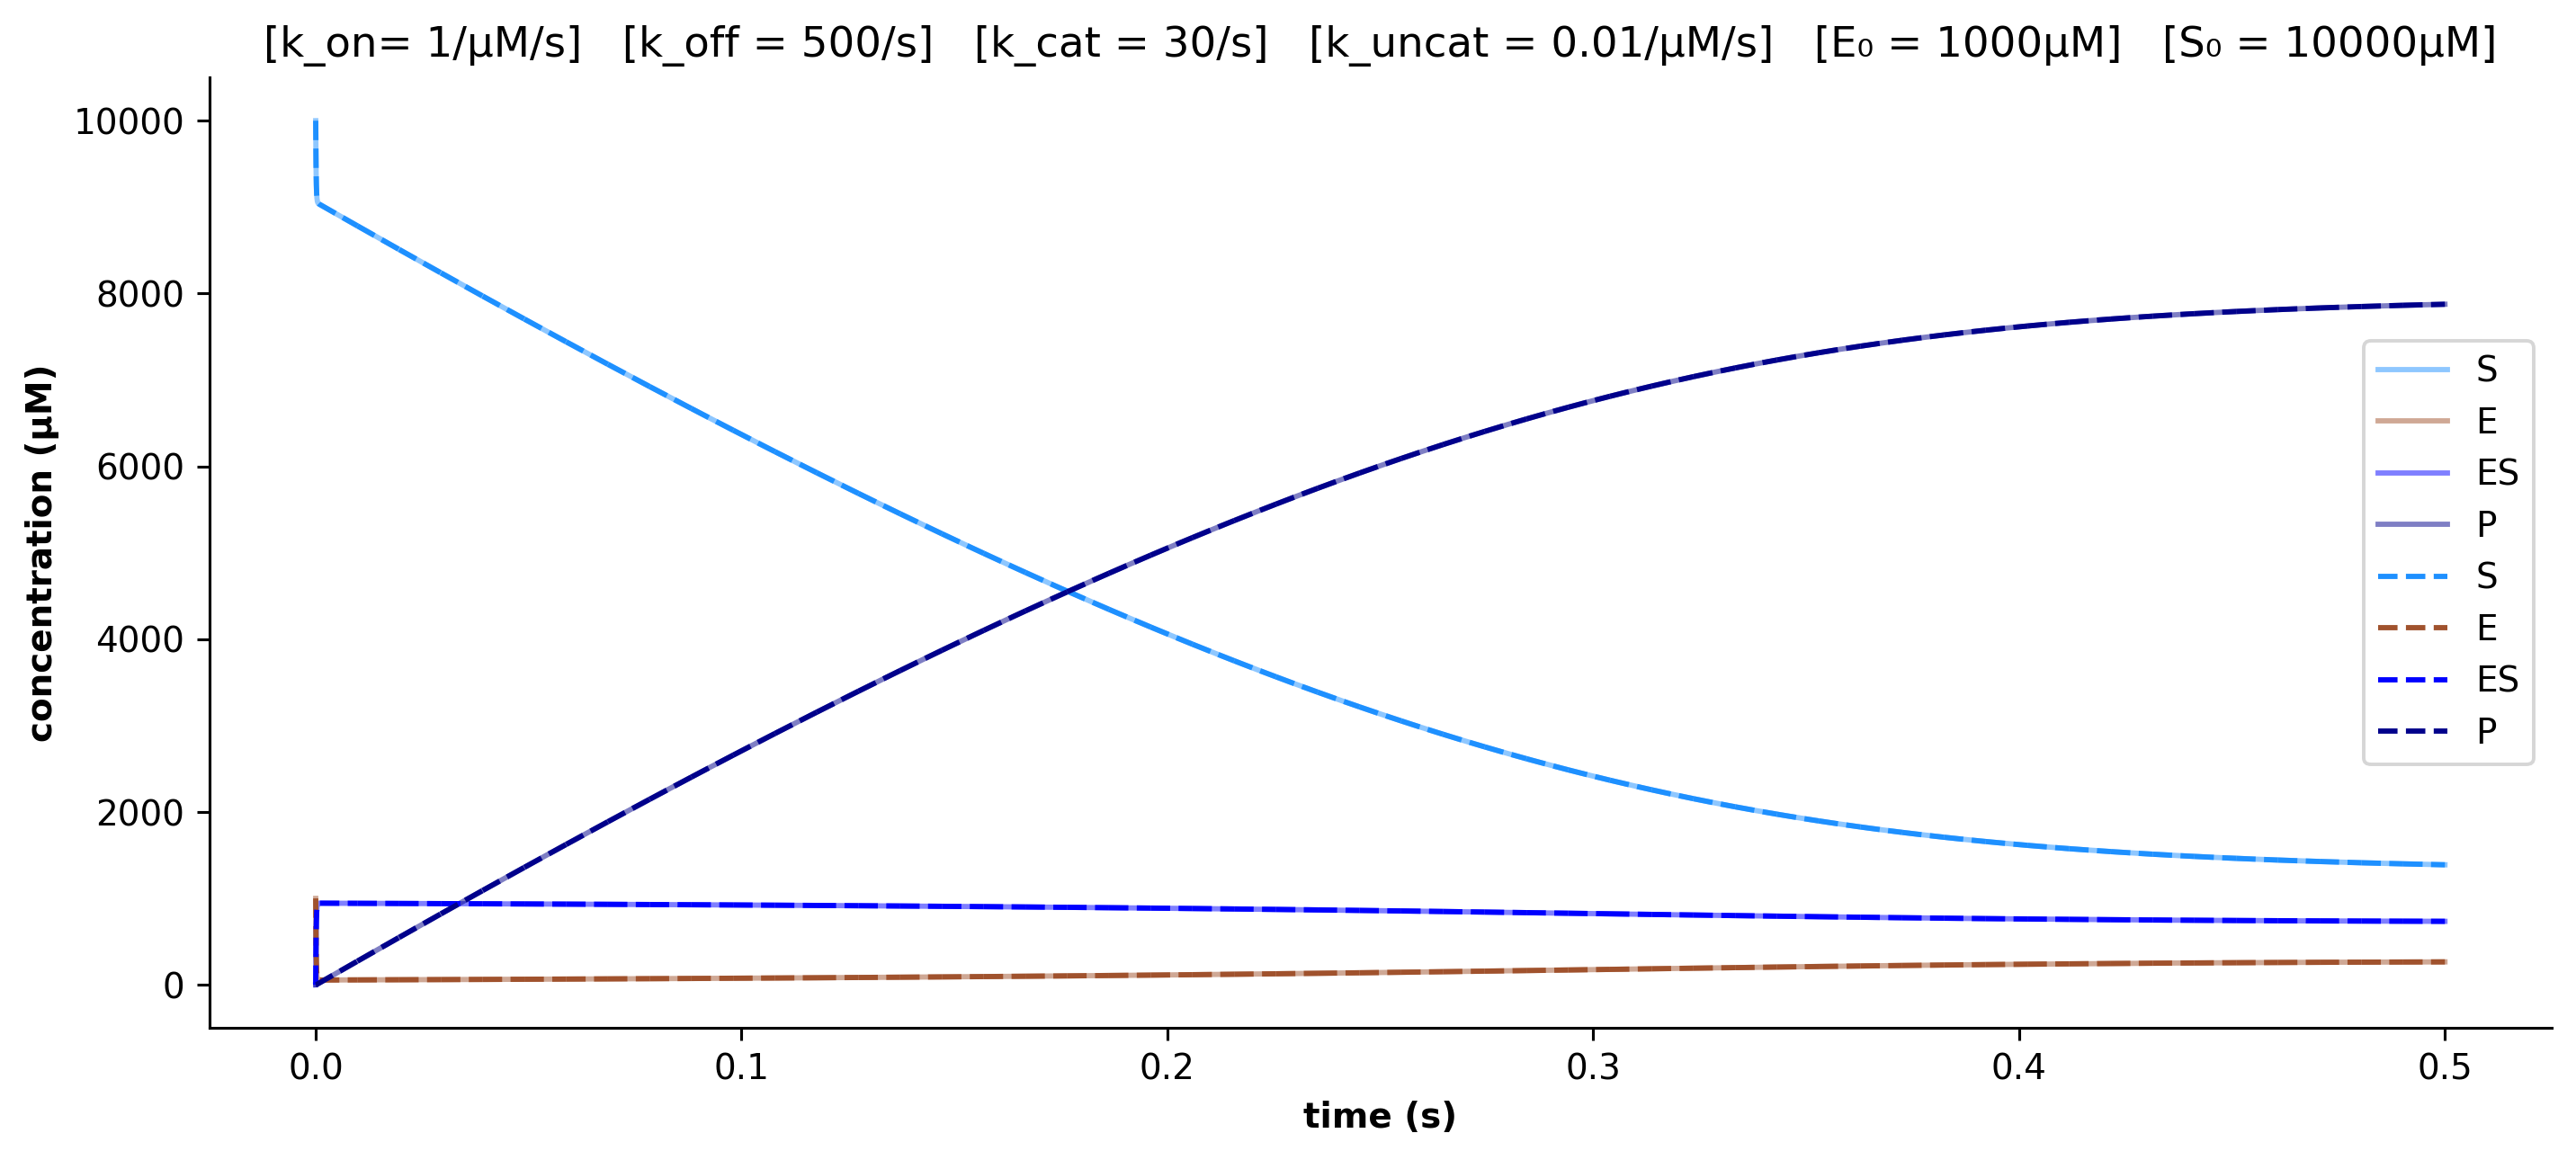

In [19]:
#collapse
# solve the system with both integrators, for default parameters
scipy_full_traj = scipy_full(dt, steps, default_kinetic_params, **default_initial_conditions)
euler_full_traj = euler_full(dt, steps, **default_kinetic_params, **default_initial_conditions)

ax = scipy_full_traj.plot.line(title=param_string(**default_initial_conditions, **default_kinetic_params), color=color(scipy_full_traj.columns), alpha=0.5)
euler_full_traj.plot.line(ax=ax, color=color(euler_full_traj.columns), linestyle='--')

fig_style(ax)

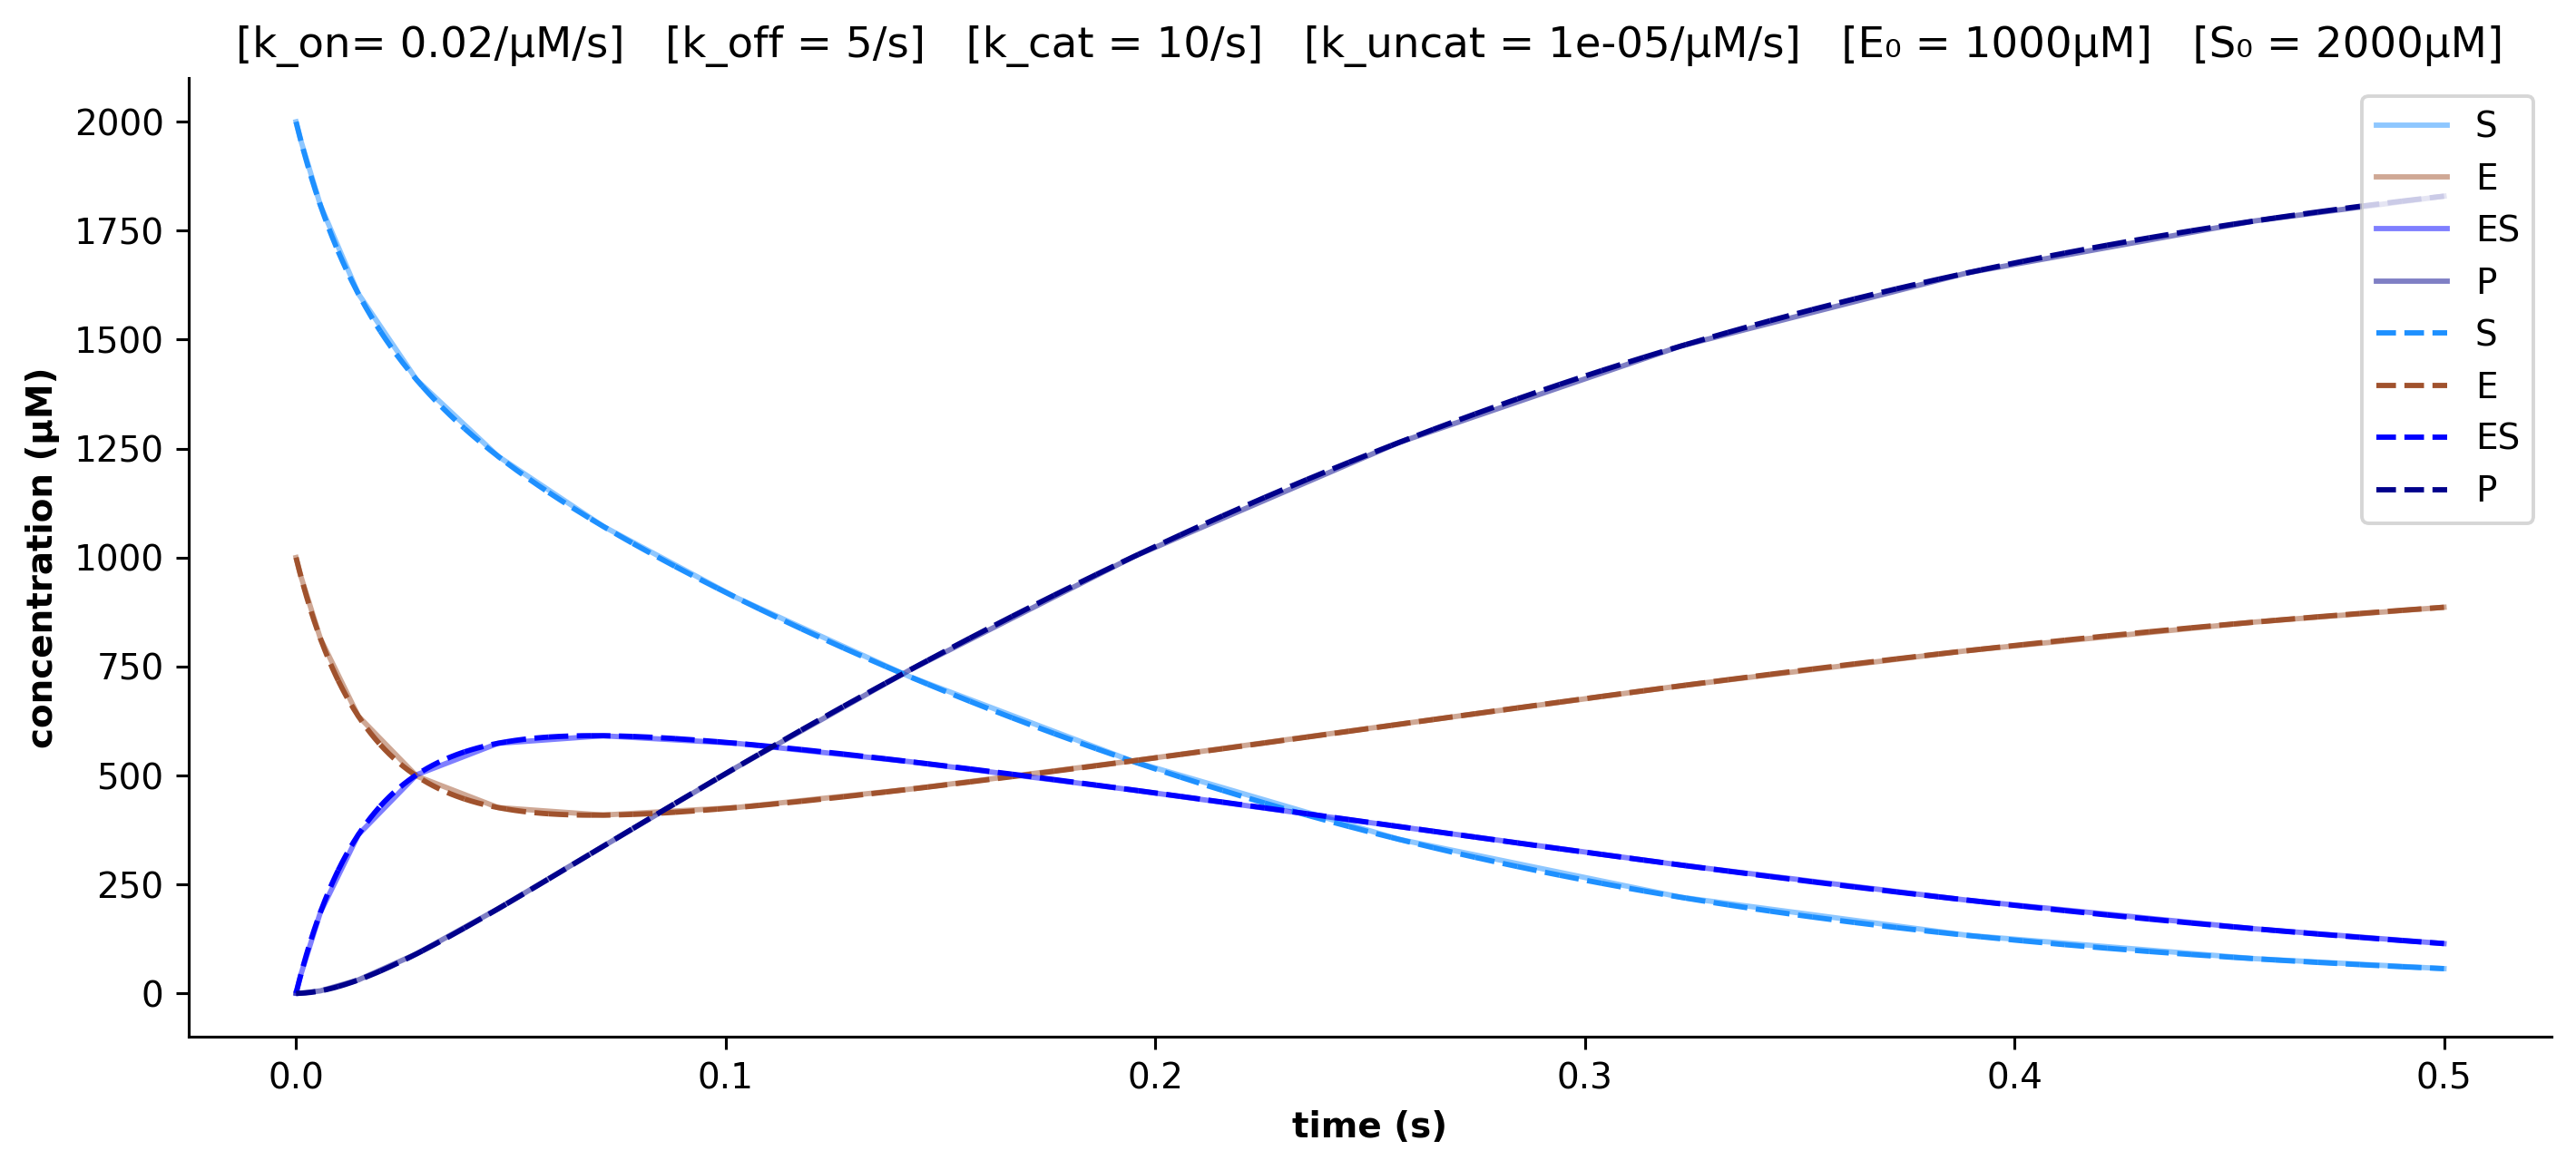

In [20]:
#collapse
# solve the system with both integrators, for unusual parameters
kinetic_params = {
    'k_on': 0.02,
    'k_off': 5,
    'k_cat': 10,
    'k_uncat': 0.00001,
}

kinetic_params['k_ms'] = k_ms(kinetic_params)
kinetic_params['k_mp'] = k_mp(kinetic_params)

import time
start = time.process_time()
scipy_full_traj = scipy_full(dt, steps, kinetic_params, **initial_conditions)
scipy_time = time.process_time() - start

start = time.process_time()
euler_full_traj = euler_full(dt, steps, **kinetic_params, **initial_conditions)
euler_time = time.process_time() - start

ax = scipy_full_traj.plot.line(title=param_string( **initial_conditions,**kinetic_params), color=color(scipy_full_traj.columns), alpha=0.5)
euler_full_traj.plot.line(ax=ax, color=color(euler_full_traj.columns), linestyle='--')

fig_style(ax)

The lack of deviation gives us confidence both integration techniques are accurate. Meanwhile,

In [21]:
f'our naïve code takes {round(euler_time, 2)}s, whereas the optimized scipy code takes {round(scipy_time, 4)}s to generate the same trajectory.'

'our naïve code takes 1.08s, whereas the optimized scipy code takes 0.006s to generate the same trajectory.'

## 3. Inference

We have seen how the trajectory of the chemical system is a function of the kinetic parameters. We would now like to invert that function to recover the kinetic parameters from an observed trajectory.

Suppose we know the initial concentrations of <span style='color:#a0522d'>Enzyme <b>E</b></span> and <span style='color:#1e90ff'>Substrate <b>S</b></span>, and we measure the concentration of <span style='color:#00008b'>product <b>P</b></span> over the course of the reaction, which yields the following dataset: 

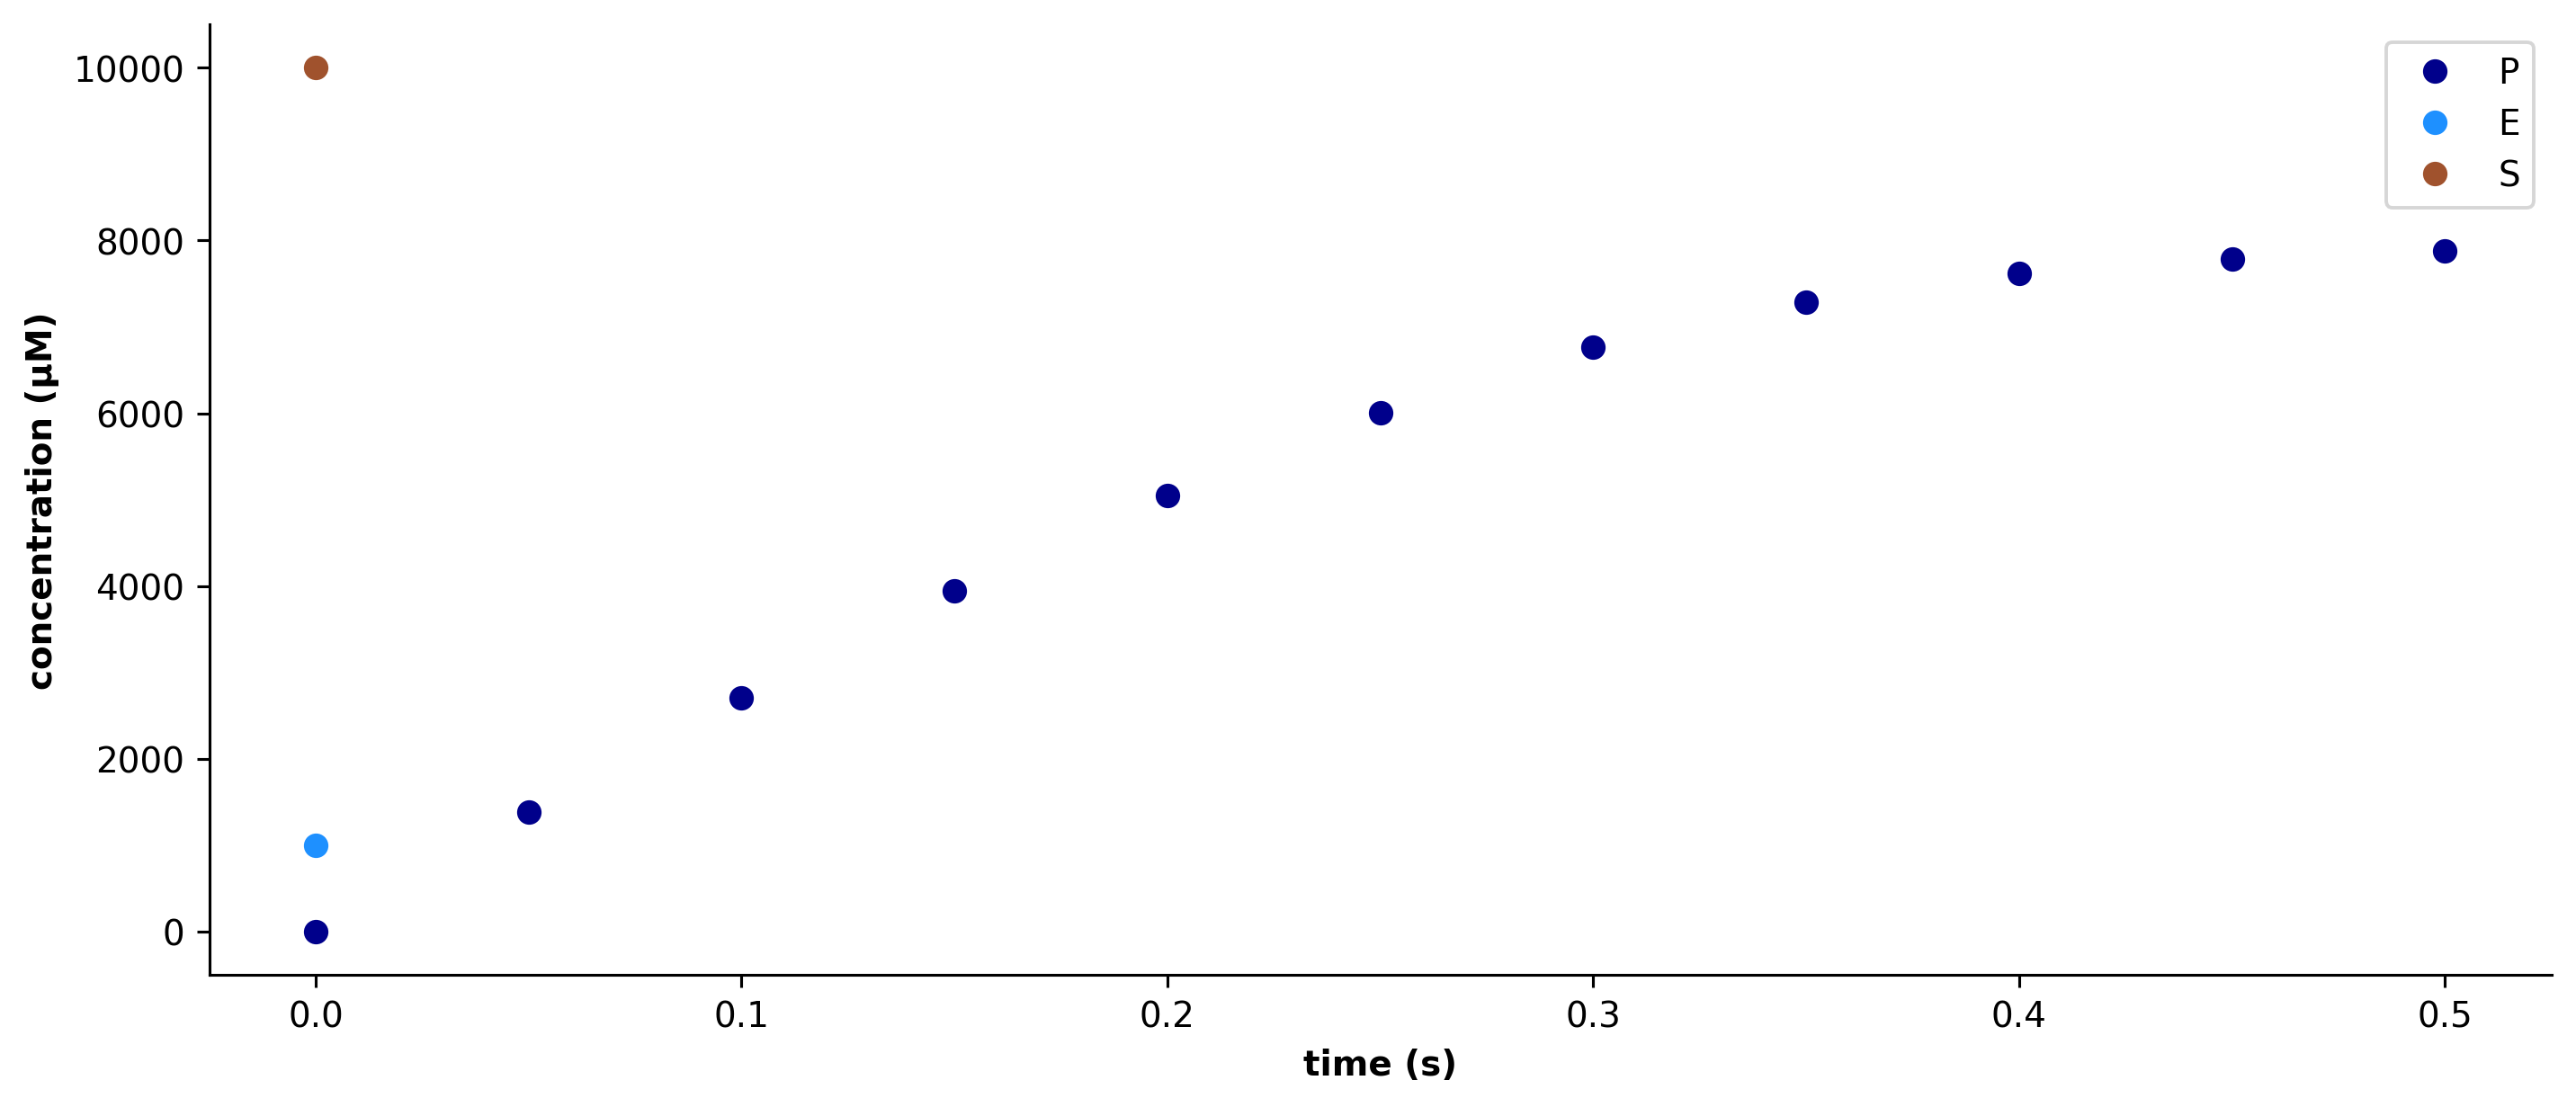

In [22]:
#collapse
# plot inverse problem setting
observations = default_traj_full.loc[np.arange(10+1)/20, 'P']

ax = observations.plot.line(marker='o', lw=0, color=color(['P']), legend=True)
default_traj_full.loc[0, ['E', 'S']].to_frame().T.plot.line(ax=ax, marker='o', lw=0, color=color(default_traj_full.columns), legend=True)

fig_style(ax)

We will supply noiseless measurements to our inference algorithms. However, our inference procedures will assume noise in the measurements. 

<div class="flash"><strong>Note:</strong>
    
If we had measured $\dPdt$ for various (linearly independent) concentrations of $[\mathrm{S}]$, $[\mathrm{P}]$, and $[\mathrm{E}]_0$ (as in an <i>in vitro</i> enzyme assay) we could use a nonlinear regression with the Michaelis-Menten/Briggs-Haldane expression for $\dPdt$. Concretely, supposing we had a set of measurements for the variables in <span style="color:blue">blue</span>, a nonlinear regression would permit us to fit the constants in <span style="color:red">red</span>:

$$\color{blue}{\dPdt} = 
\frac{
\frac{\color{red}{\kcat} \, 
\color{blue}{[\mathrm{E_T}]}
\color{blue}{[\mathrm{S}]}}
{\color{red}{K_{m,\mathrm{S}}}} - 
\frac{\color{red}{\koff} \, \color{blue}{[\mathrm{E_T}]} \color{blue}{[\mathrm{P}]}}{\color{red}{K_{m,\mathrm{P}}}}}
{1+\frac{\color{blue}{[\mathrm{S}]}}{\color{red}{K_{m,\mathrm{S}}}} + \frac{\color{blue}{[\mathrm{P}]}}{\color{red}{K_{m,\mathrm{P}}}}} 
$$

If we had assumed the reaction were irreversible, the Michaelis-Menten/Briggs-Haldane expression would have simplified to

$$\color{blue}{\dPdt} = 
\frac{
\color{red}{\kcat} \, \color{blue}{[\mathrm{E_T}]} \color{blue}{[\mathrm{S}]}}
{\color{red}{K_{m,\mathrm{S}}} + \color{blue}{[\mathrm{S}]}}
$$

Where $\color{red}{\kcat} \, \color{blue}{[\mathrm{E_T}]}$ is often consolidated as $\color{red}{V_{max}}$.


To recap, we take a different approach because:
<ol>
<li> Simultaneous measurements of the activity many enzymes in cells might inform us about $[\mathrm{S}]$, $[\mathrm{P}]$, and perhaps $[\mathrm{E}]$ but not $\dPdt$. We would also presumably not be able to approximate $\dPdt$ via finite differences, due to the relative sparsity of the measurement in time compared to the rates of the reactions. </li>

<li> This approach would produce spurious estimates of the kinetic parameters in cases in which the Quasi-Steady-State Approximation is invalid (see <a href="#2.2:-Breaking-the-Michaelis-Menten/Briggs-Haldane-Assumptions:--%C2%A0-%C2%A0-%C2%A0-Initial-Substrate:Enzyme-Ratio">§2.2</a>, <a href="#2.3:-Breaking-the-Michaelis-Menten/Briggs-Haldane-Assumptions:--%C2%A0-%C2%A0-%C2%A0-Fast-Enzyme-Substrate-Complex-Kinetics">§2.3</a>) which may often be the case <i>in vivo</i>. </li>
</ol>

At the moment, I believe there are no methods for the inverse problem which are not variants of the two methods I will describe, and importantly, no methods which do not iterate a loop, solving the forward problem at each iteration.

</div>

There are two types of approaches to solving this inverse problem. We will explore the simplest variant of each type. 

### 3.1 Bayesian Approach: Inference by Sampling 
<small>[We assume the reader is familiar with Bayesian Inference in other settings.]</small>

<!-- For an introduction to the topic, we recommend <a href="https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-438-algorithms-for-inference-fall-2014/">the 6.438 course notes</a> -->

The goal of the Bayesian approach is to determine a posterior over the 4D space spanned by the kinetic parameters. The posterior is the product of the prior and likelihood (up to a constant factor). Thus the Bayesian Inference approach entails _defining_ a prior and a likelihood. 

#### 3.1.1. Prior

If the kinetic parameters of the enzyme under study are not unlike the kinetic parameters of enzymes studied in the past, then the empirical distribution of kinetic parameters of enzymes studied in the past is a good prior for the parameters of this enzyme. 

Since databases of observed enzyme kinetic parameters (e.g. [BRENDA](https://www.brenda-enzymes.org/), [SabioRK](http://sabio.h-its.org/)) are difficult to work with, we'll use a previously curated set of kinetic parameters from the supplement of <a href="https://pubs.acs.org/doi/10.1021/bi2002289">The Moderately Efficient Enzyme: Evolutionary and Physicochemical Trends Shaping Enzyme Parameters</a>. 

If we knew what sort of enzyme we were studying (which EC class) we could narrow our prior to just those kinetic parameters observed for enzymes of that class. 

This database lists $k_{\mathrm{m}}$ and $\kcat$ for both "forwards" and "reverse" reactions with respect to which direction biologists believe is "productive", from which we can parlay distributions for $\kms$ and $\kcat$ from reactions in the forwards direction, and $\kmp$ and $\koff$ from reverse reactions. 

In [23]:
#collapse
# import kinetic parameter database
df = pd.read_excel('../data/Enzyme_Kinetic_Parameter_Inference/Moderately_Efficient_Enzyme/bi2002289_si_003.xls', 1)[['Reaction direction (KEGG)','KM (µM)','kcat (1/sec)']]

empirical_kms = df.loc[df['Reaction direction (KEGG)'] == 1, 'KM (µM)'].dropna().rename('k_ms')
empirical_kmp = df.loc[df['Reaction direction (KEGG)'] == -1, 'KM (µM)'].dropna().rename('k_mp')
empirical_kcat = df.loc[df['Reaction direction (KEGG)'] == 1, 'kcat (1/sec)'].dropna().rename('k_cat')
empirical_koff = df.loc[df['Reaction direction (KEGG)'] == -1, 'kcat (1/sec)'].dropna().rename('k_off')

empirical_joint_forward_params = df.loc[df['Reaction direction (KEGG)'] == 1, ['KM (µM)','kcat (1/sec)']].dropna().rename(columns={'KM (µM)':'k_ms', 'kcat (1/sec)':'k_cat'})
empirical_joint_reverse_params = df.loc[df['Reaction direction (KEGG)'] == -1, ['KM (µM)','kcat (1/sec)']].dropna().rename(columns={'KM (µM)':'k_mp', 'kcat (1/sec)':'k_off'})

In [24]:
#collapse
# figure styles
def fig_style_2(ax):
    for side in ["right","top","left"]: ax.spines[side].set_visible(False)
    ax.get_yaxis().set_visible(False)


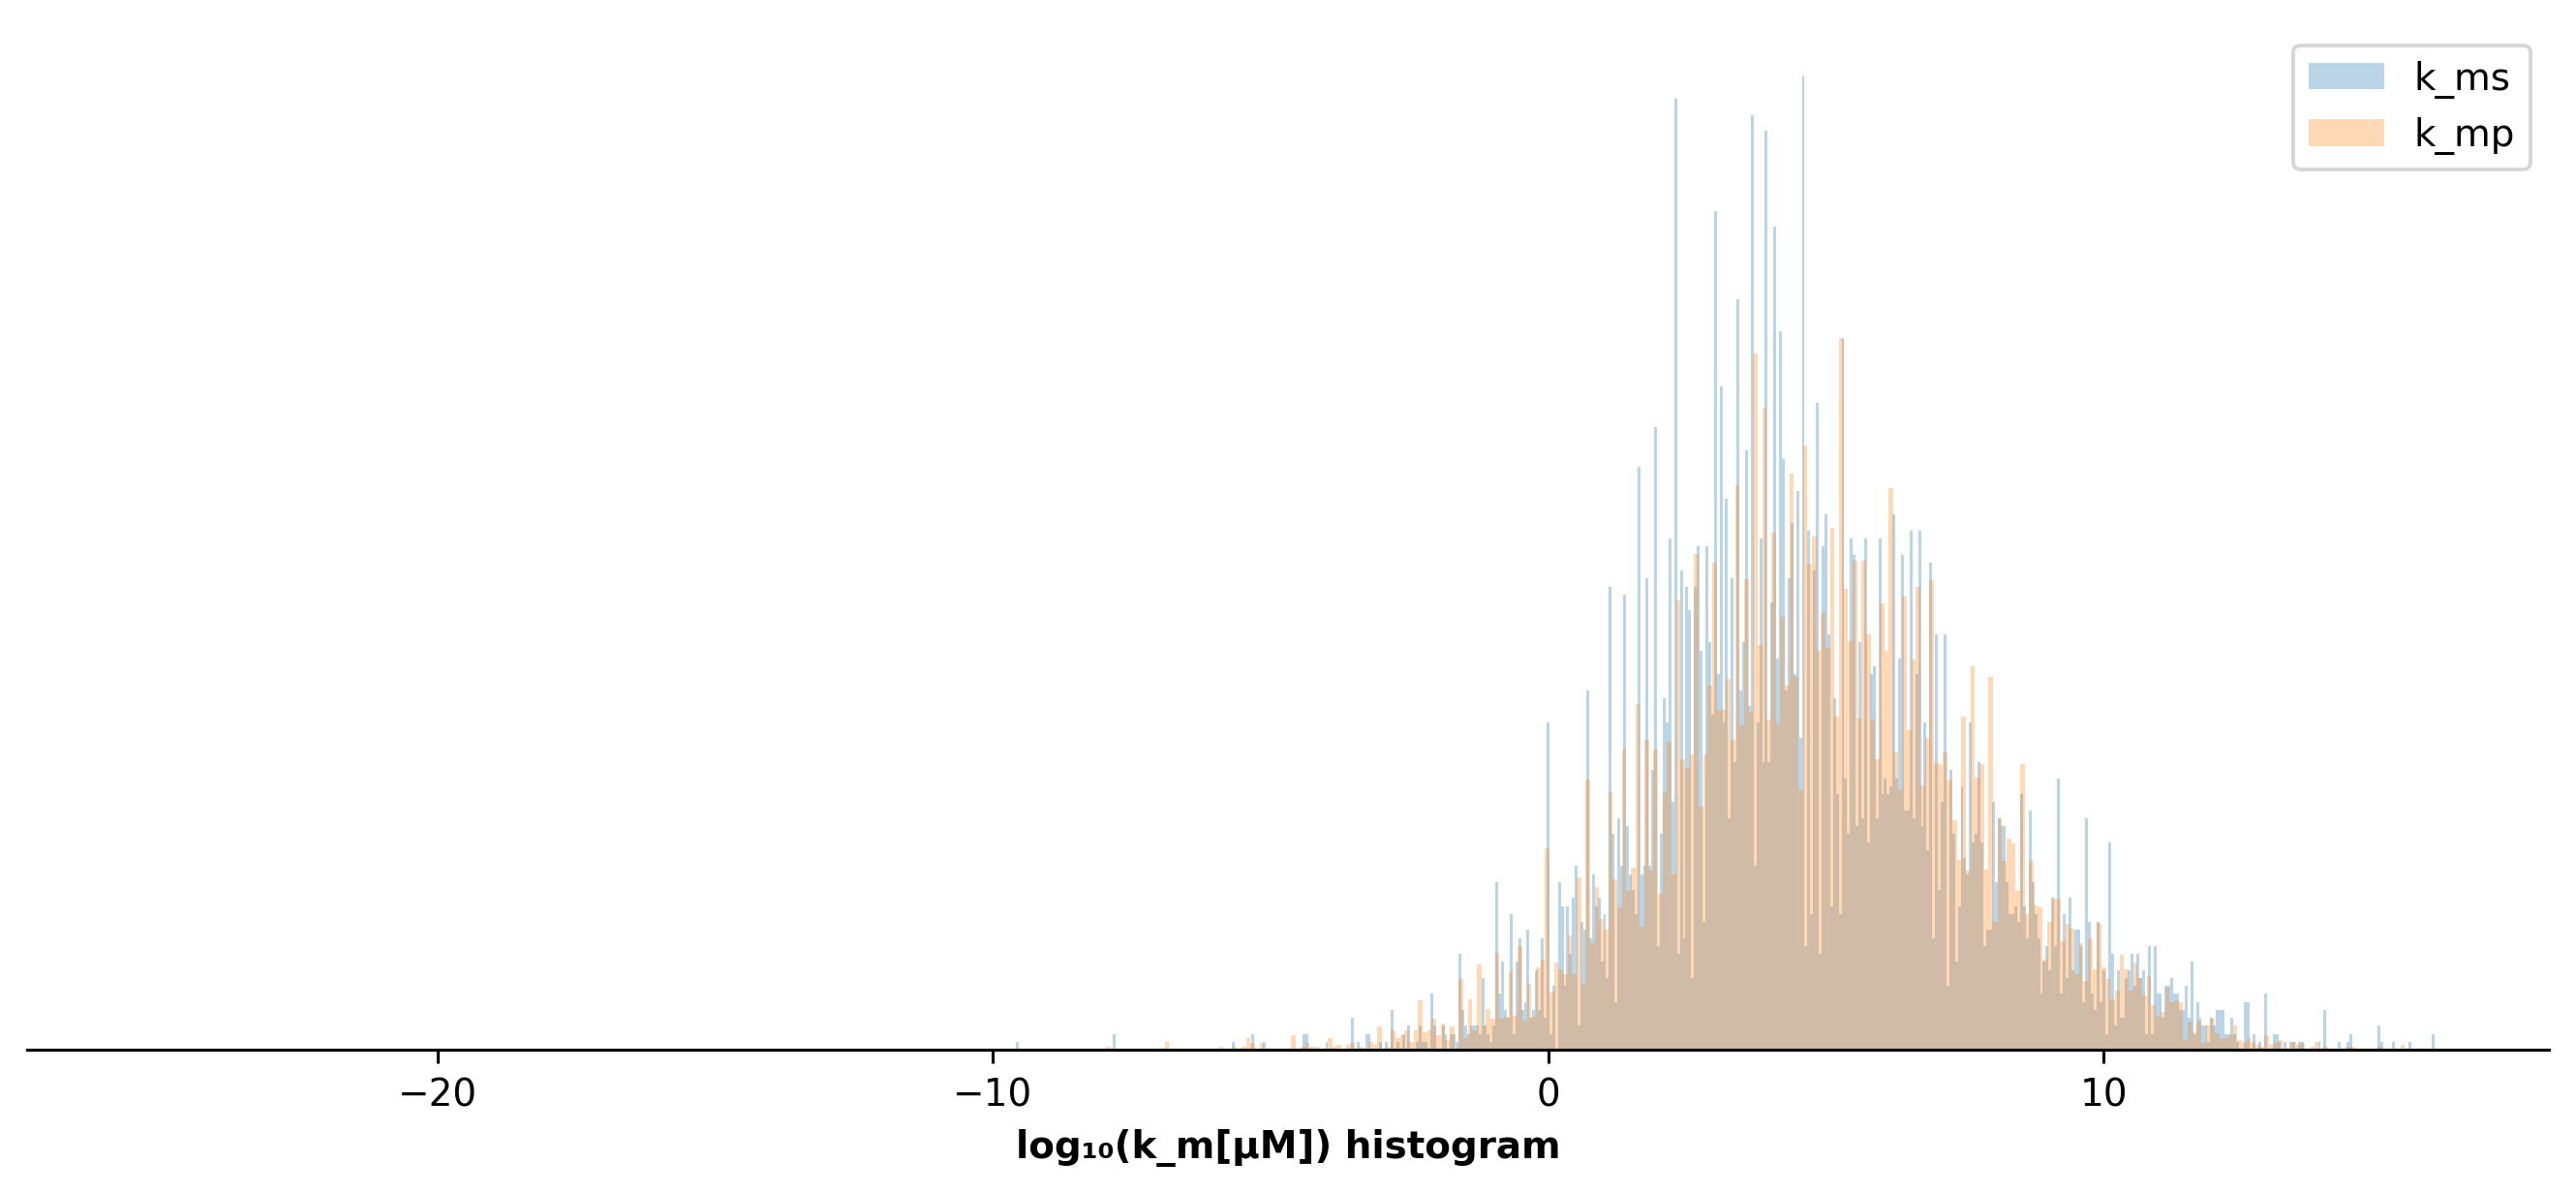

In [25]:
#collapse
# plot km distribution in log-space
log_empirical_kms = np.log(empirical_kms)
log_empirical_kmp = np.log(empirical_kmp)

log_kms_normal = scipy.stats.norm(loc=log_empirical_kms.mean(), scale=log_empirical_kms.std())
log_kmp_normal = scipy.stats.norm(loc=log_empirical_kmp.mean(), scale=log_empirical_kmp.std())

ax = log_empirical_kms.plot.hist(bins=500, alpha=0.3, density=1, legend=True)
log_empirical_kmp.plot.hist(bins=500, ax=ax, alpha=0.3, density=1, legend=True)

ax.set_xlabel('log₁₀(k_m[µM]) histogram',  weight='bold')
fig_style_2(ax)

# x1 = np.linspace(log_kms_normal.ppf(0.01), log_kms_normal.ppf(0.99), 100)
# ax.plot(x1, log_kms_normal.pdf(x1)*ax.get_ylim()[1]*3, '-', lw=0.6, color='dodgerblue')

# x2 = np.linspace(log_kmp_normal.ppf(0.01), log_kmp_normal.ppf(0.99), 100)
# ax.plot(x2, log_kmp_normal.pdf(x2)*ax.get_ylim()[1]*3, '-', lw=0.8, color='peru')

This plot is surprising: according to this database, enzymes appear to have roughly equal binding affinity for their substrates and products. 

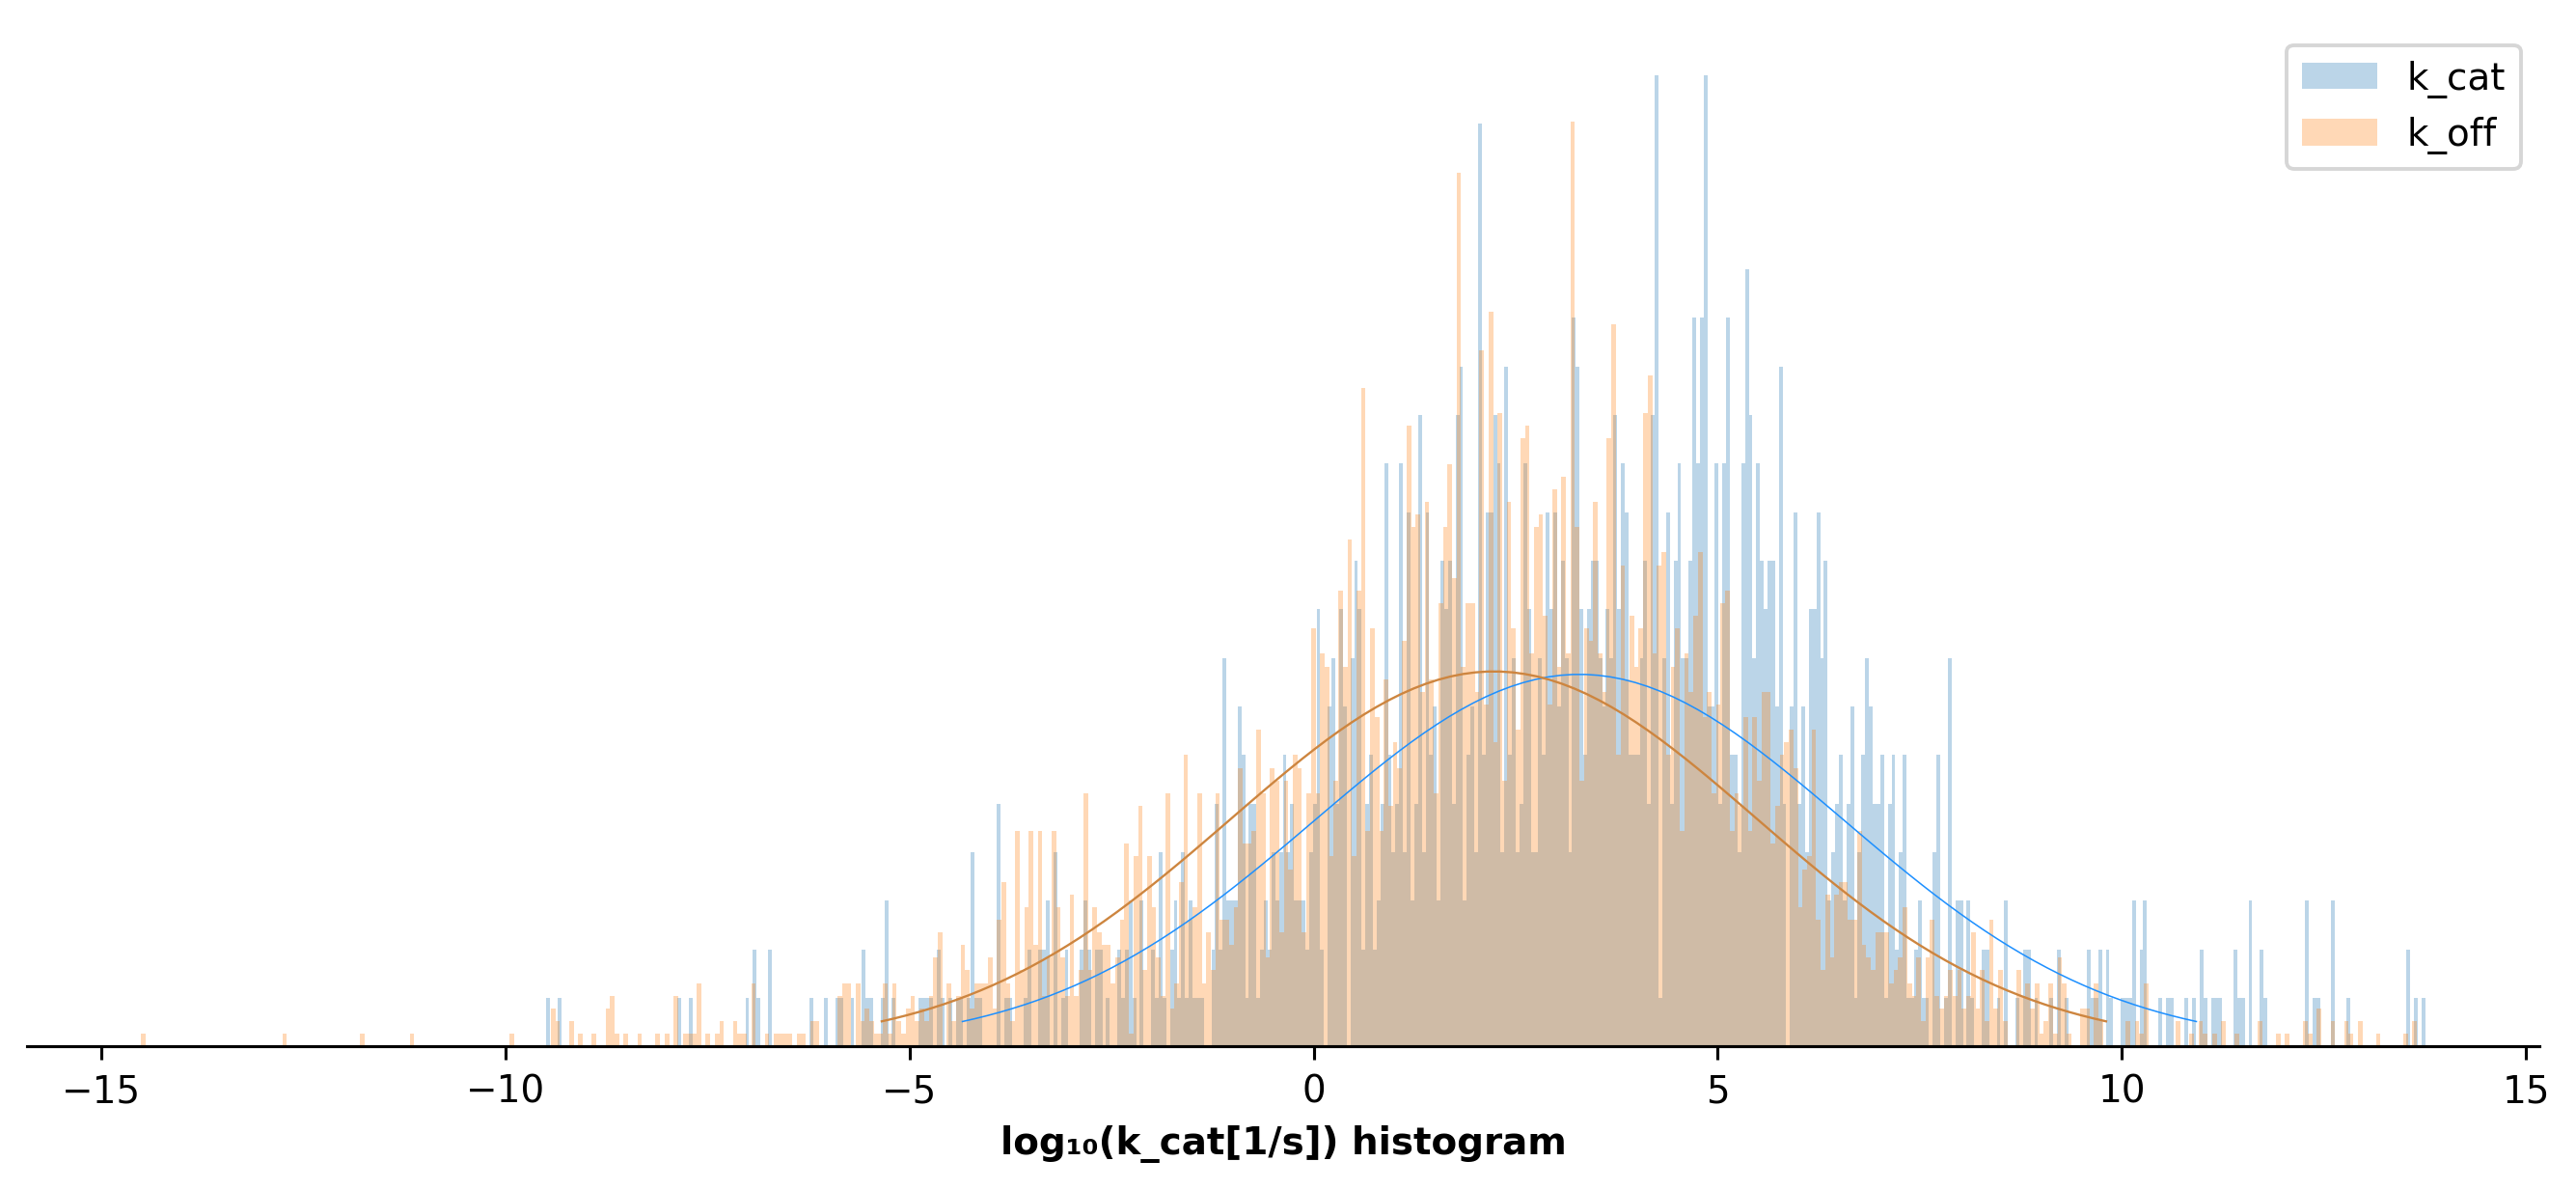

In [26]:
#collapse
# plot kcat distribution in log-space
log_empirical_kcat = np.log(empirical_kcat)
log_empirical_koff = np.log(empirical_koff)

log_kcat_normal = scipy.stats.norm(loc=log_empirical_kcat.mean(), scale=log_empirical_kcat.std())
log_koff_normal = scipy.stats.norm(loc=log_empirical_koff.mean(), scale=log_empirical_koff.std())

ax = log_empirical_kcat.plot.hist(bins=500, alpha=0.3, density=1, legend=True)
log_empirical_koff.plot.hist(bins=500, ax=ax, alpha=0.3, density=1, legend=True)

x1 = np.linspace(log_kcat_normal.ppf(0.01), log_kcat_normal.ppf(0.99), 100)
ax.plot(x1, log_kcat_normal.pdf(x1)*ax.get_ylim()[1]*3, '-', lw=0.4, color='dodgerblue')

x2 = np.linspace(log_koff_normal.ppf(0.01), log_koff_normal.ppf(0.99), 100)
ax.plot(x2, log_koff_normal.pdf(x2)*ax.get_ylim()[1]*3, '-', lw=0.6, color='peru')

ax.set_xlabel('log₁₀(k_cat[1/s]) histogram',  weight='bold')
fig_style_2(ax)

On the other hand, they have a fairly strong preference for catalyzing the reaction biologists think of as forwards (~10x).

Since these empirical distributions over $\kms$ and $\kcat$ in the forwards direction and $\kmp$ and $\koff$ in the reverse direction look sufficiently like normals in log space, so we'll treat them as lognormals. However, we would like our inference procedure to estimate the semantic parameters $\kon$, $\koff$, $\kcat$, and $\kuncat$. We can rearrange the expressions for $\kms$ and $\kmp$ to get expressions for the two parameters we're missing:

$$ \kon = \frac{\koff + \kcat}{\kms} \quad \mathrm{and} \quad \kuncat = \frac{\koff + \kcat}{\kmp}$$

Conveniently, the ratio of lognormal variables $\frac{X_1}{X_2}$ is also lognormal with $\mu_{1/2} = \mu_1 - \mu_2$ and $ \sigma^2_{1/2} = \sigma^2_1 + \sigma^2_2 - \sigma_{x_1, x_2}$. In order to use that fact, we say the sum of the random variables $\koff + \kcat$ is also log-normally distributed. We compute its mean and variance empirically.



In [27]:
kcat_plus_koff = pd.Series(np.repeat(empirical_kcat.values, len(empirical_koff)) +
                           np.tile(empirical_koff.values, len(empirical_kcat)))

log_kcat_plus_koff_mean = np.log10(kcat_plus_koff).mean()
log_kcat_plus_koff_var = np.log10(kcat_plus_koff).var()

This permits us to produce empirical distributions for $\kon$ and $\kuncat$,

In [28]:
log_kon_normal = scipy.stats.norm(loc=log_kcat_plus_koff_mean-log_empirical_kms.mean(),
                                  scale=sqrt(log_kcat_plus_koff_var+log_empirical_kms.var()))

log_kuncat_normal = scipy.stats.norm(loc=log_kcat_plus_koff_mean-log_empirical_kmp.mean(),
                                     scale=sqrt(log_kcat_plus_koff_var+log_empirical_kmp.var()))


which, along with our empirical distributions for $\koff$ and $\kcat$, define a prior over the 4 kinetic parameters we wish to infer.

We might ask whether these are correlated lognormals


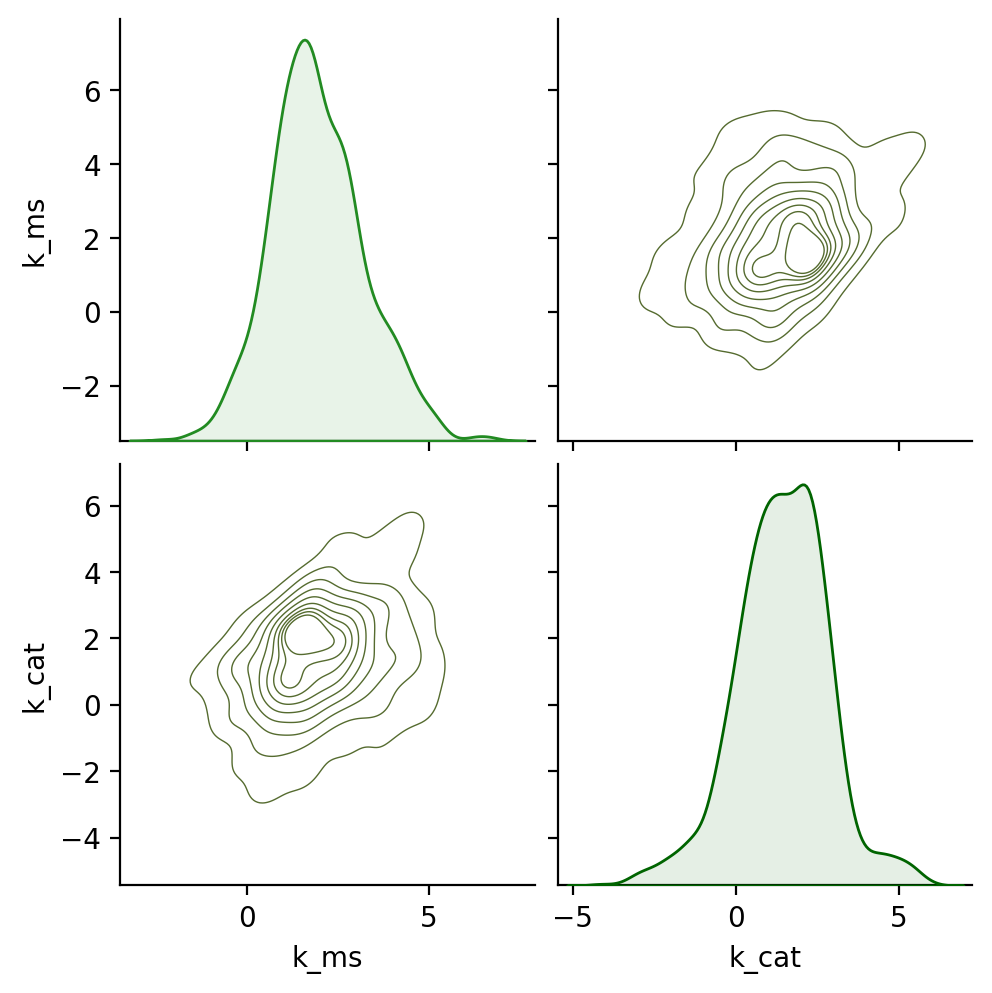

In [29]:
#collapse
pp = sns.pairplot(np.log10(empirical_joint_forward_params), kind="kde", plot_kws={'linewidths':0.5, 'color':'darkolivegreen'})

k_ms_univariate_density = pp.diag_axes[0].get_children()[0]
k_ms_univariate_density.set_edgecolor(c['k_ms'])
k_ms_univariate_density.set_facecolor(hex_to_rgb(c['k_ms']) + [0.1])

k_cat_univariate_density = pp.diag_axes[1].get_children()[0]
k_cat_univariate_density.set_edgecolor(c['k_cat'])
k_cat_univariate_density.set_facecolor(hex_to_rgb(c['k_cat']) + [0.1])

resize_fig(400, 400)


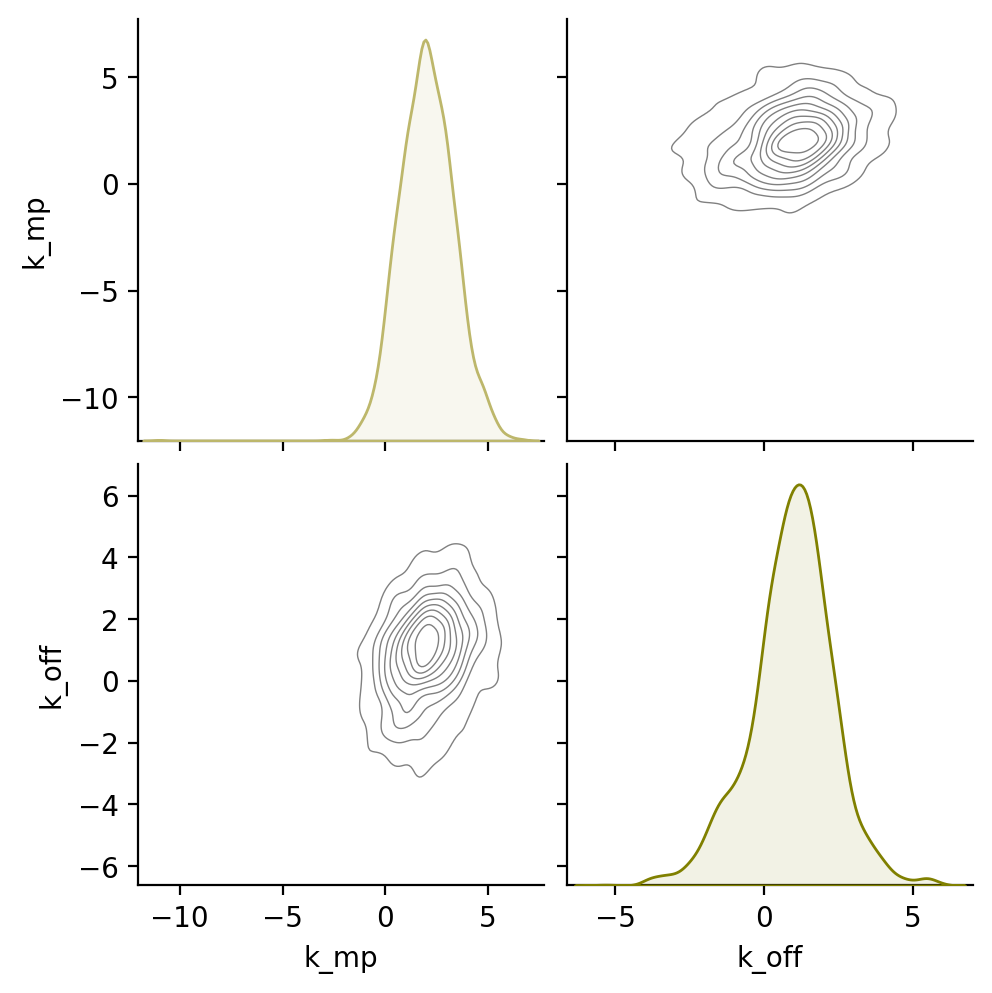

In [30]:
#collapse
pp = sns.pairplot(np.log10(empirical_joint_reverse_params), kind="kde", plot_kws={'linewidths':0.5, 'color':'grey'})

k_mp_univariate_density = pp.diag_axes[0].get_children()[0]
k_mp_univariate_density.set_edgecolor(c['k_mp'])
k_mp_univariate_density.set_facecolor(hex_to_rgb(c['k_mp']) + [0.1])

k_off_univariate_density = pp.diag_axes[1].get_children()[0]
k_off_univariate_density.set_edgecolor(c['k_off'])
k_off_univariate_density.set_facecolor(hex_to_rgb(c['k_off']) + [0.1])

resize_fig(400, 400)

Not enough to include covariances in the prior. We set the prior covariance to be a diagonal matrix: 

In [31]:
prior_cov = np.diag([log_kon_normal.var(),
                     log_koff_normal.var(),
                     log_kcat_normal.var(),
                     log_kuncat_normal.var()])

In [32]:
def prior_pdf(k_on=None, k_off=None, k_cat=None, k_uncat=None):
    return (
    log_kon_normal.pdf(k_on) *
    log_koff_normal.pdf(k_off) *
    log_kcat_normal.pdf(k_cat) *
    log_kuncat_normal.pdf(k_uncat))

def prior_logpdf(k_on=None, k_off=None, k_cat=None, k_uncat=None):
    return (
    log_kon_normal.logpdf(k_on) +
    log_koff_normal.logpdf(k_off) +
    log_kcat_normal.logpdf(k_cat) +
    log_kuncat_normal.logpdf(k_uncat))

def sample_prior():
    # returns [k_on, k_off, k_cat, k_uncat]
    return {
    'k_on': log_kon_normal.rvs(),
    'k_off': log_koff_normal.rvs(),
    'k_cat': log_kcat_normal.rvs(),
    'k_uncat': log_kuncat_normal.rvs()}

Now that we have a prior, let's examine where the default parameters introduced in [§2.1](#2.1-A-Standard-Example) land in this distribution. We had claimed they were "typical". 

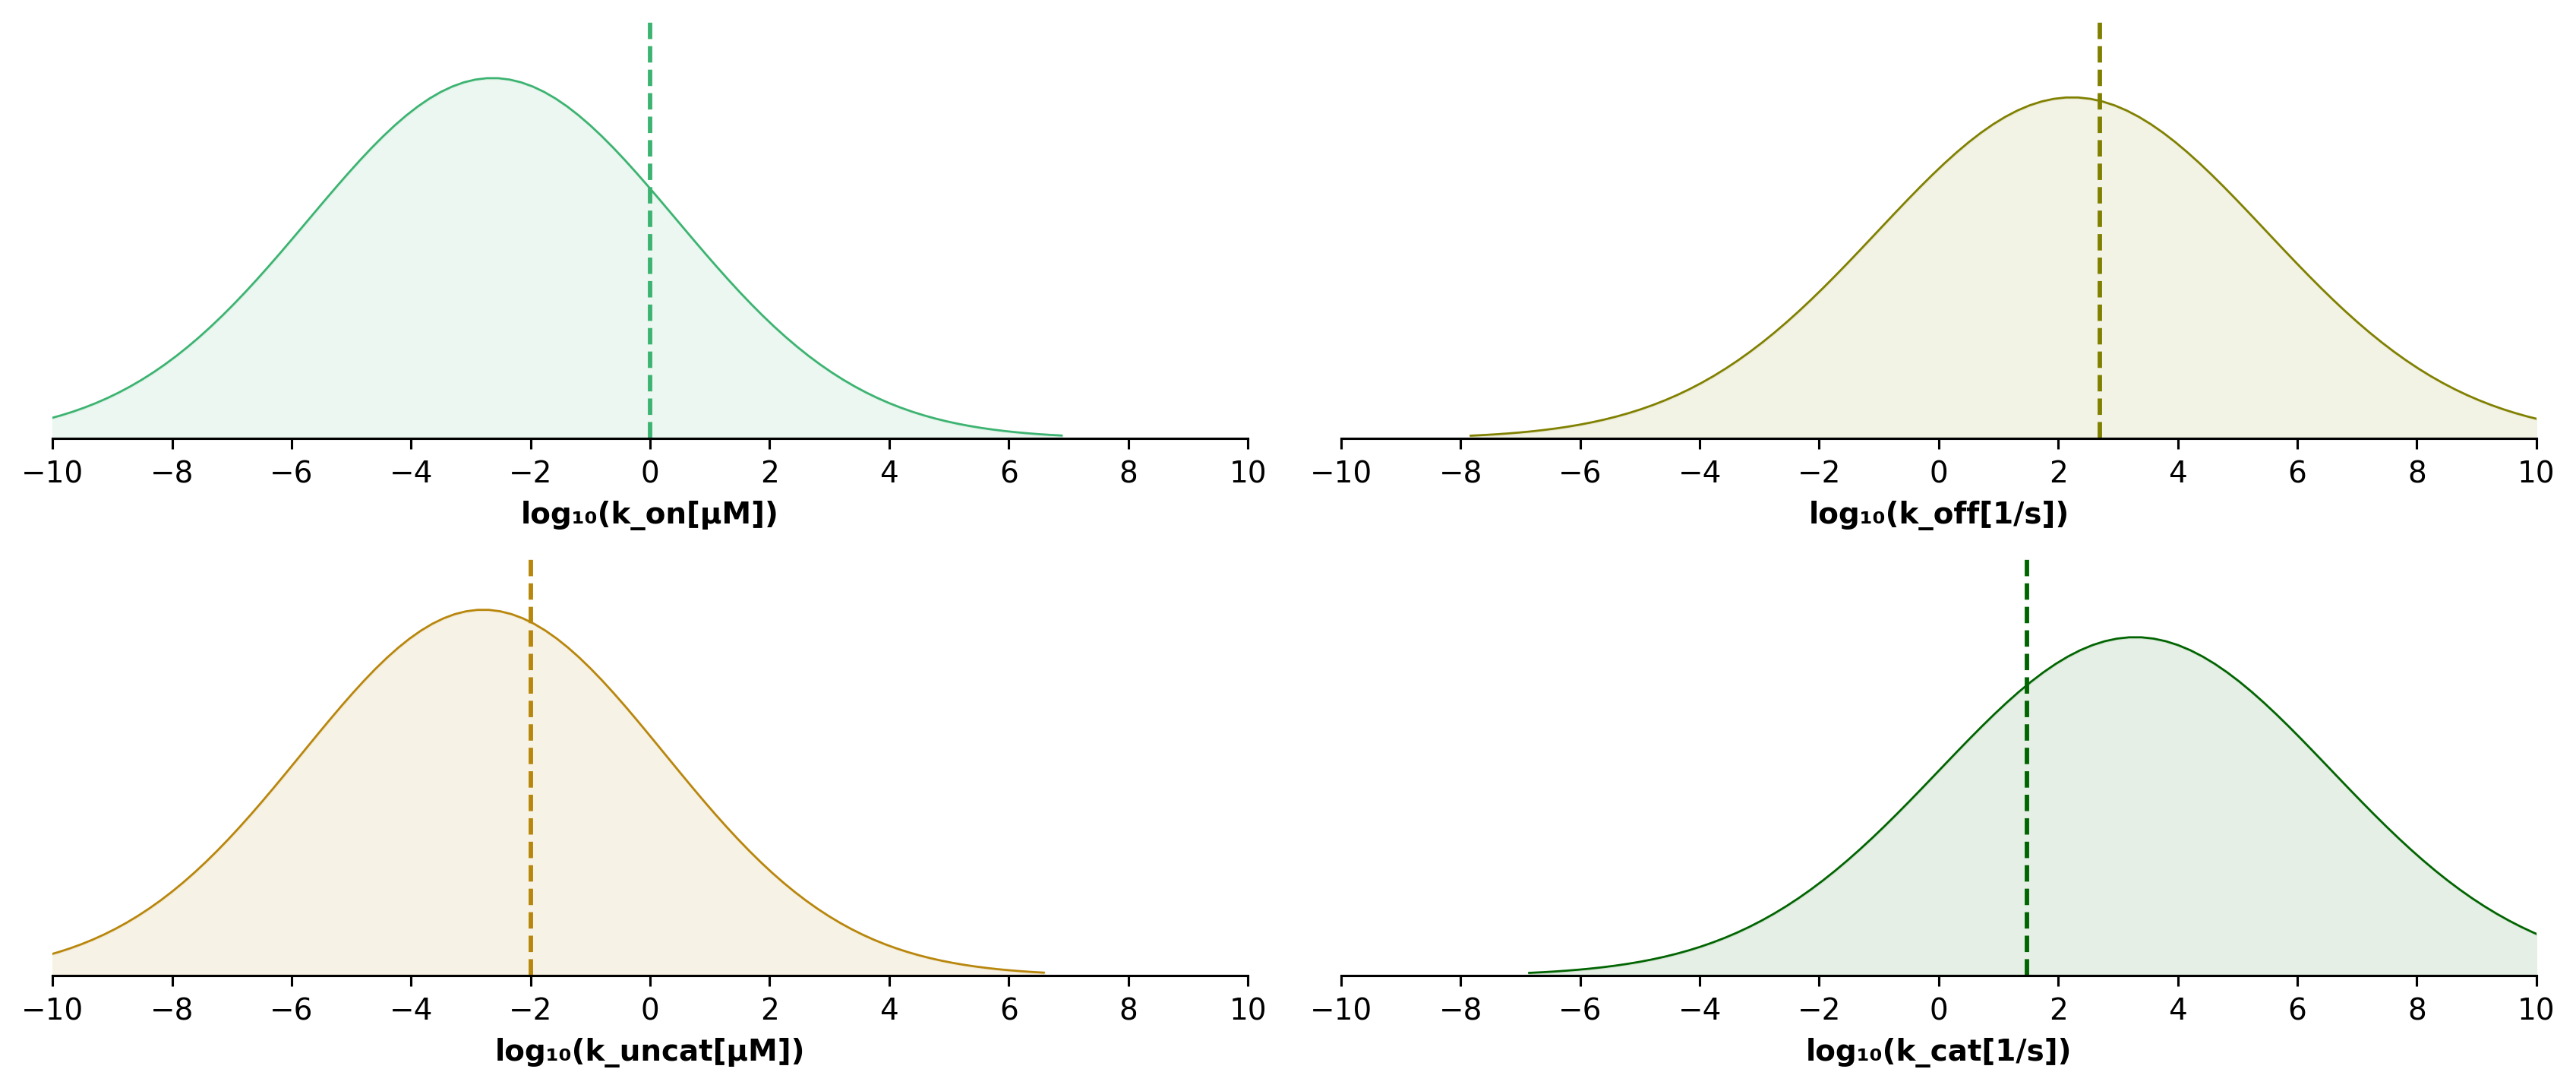

In [33]:
#collapse
# plot log-space kinetic parameter distributions, with default parameters presented previously overlaid
fig, axs = plt.subplots(2,2,constrained_layout=True)

def plot_distrib(distrib, ax, title, param):
    ax.set_xlim(-10,10)
    ax.set_ylim(0,0.15)

    x = np.linspace(distrib.ppf(0.001), distrib.ppf(0.999), 100)
    y = distrib.pdf(x)
    color = c[param]

    ax.plot(x, y, '-', lw=0.7, color=color)
    ax.fill_between(x, 0, y, color=color, alpha=0.1)
    ax.axvline(np.log10(default_kinetic_params[param]), 0, 1, linestyle='--', color=color)

    ax.xaxis.set_ticks(np.arange(-10, 10.1, 2))
    ax.set_xlabel(title,  weight='bold')
    fig_style_2(ax)

plot_distrib(log_kon_normal, axs[0][0], 'log₁₀(k_on[µM])', 'k_on')
plot_distrib(log_koff_normal, axs[0][1], 'log₁₀(k_off[1/s])', 'k_off')
plot_distrib(log_kuncat_normal, axs[1][0], 'log₁₀(k_uncat[µM])', 'k_uncat')
plot_distrib(log_kcat_normal, axs[1][1], 'log₁₀(k_cat[1/s])', 'k_cat')

#### 3.1.2. Likelihood

We need to define a likelihood $p(D|\theta)$ which measures the probability of producing the observed data given settings of the kinetic parameters $\theta = \{\kon, \koff, \kcat, \kuncat\}$. Our data $D = \{ \color{00008b}{ [\mathrm{P}]_t } \, \color{black}{ ; t \in 0...0.5\}}$ are an observed trajectory of concentrations of reaction <span style='color:#00008b'>product <b>P</b></span>. Each setting of the kinetic parameters corresponds to a trajectory of concentrations of P (via a numerical integration). Intuitively, parameter sets which result in trajectories very near the observed trajectory are more likely. Therefore, our likelihood should measure the distance between the observed $\{ \color{00008b}{ [\mathrm{P}]_t } \color{black}{ \} }$ and predicted $\{ \color{blue}{ [\mathrm{P}]_t } \color{black}{ \} }$. 

How far should the predicted trajectory be allowed to stray from the measured $\{ \color{00008b}{ [\mathrm{P}]_t } \color{black}{ \} }$? The likelihood is really our statement about the presumed noise in our measurements. If we believe our measurements to be noiseless, then our likelihood should concentrate tightly around our measurements (a [dirac $\delta$](https://en.wikipedia.org/wiki/Dirac_delta_function) in the limit), and we would only admit kinetic parameters that interpolate the observed $\{ \color{00008b}{ [\mathrm{P}]_t } \color{black}{ \} }$ almost exactly. In reality, no measurement is noiseless, so we propose the following noise model: 

Supposing the detection of each molecule of P is an independent binary random variable with error rate $\sigma$ then random variable $\color{red}{[\mathrm{P}]_t}$ is gaussian-distributed $\sim \mathcal{N}( \color{00008b}{[\mathrm{P}]_t} \color{black}, \sigma \sqrt{ \color{00008b}{[\mathrm{P}]_t }}\color{black} )$. The variance of the gaussian grows as the square root of the mean, via a Central Limit Theorem argument. We can represent this noise model (and consequently, likelihood) visually as: 


In [36]:
σ = 5 # arbitrary magic number represents detection noise level

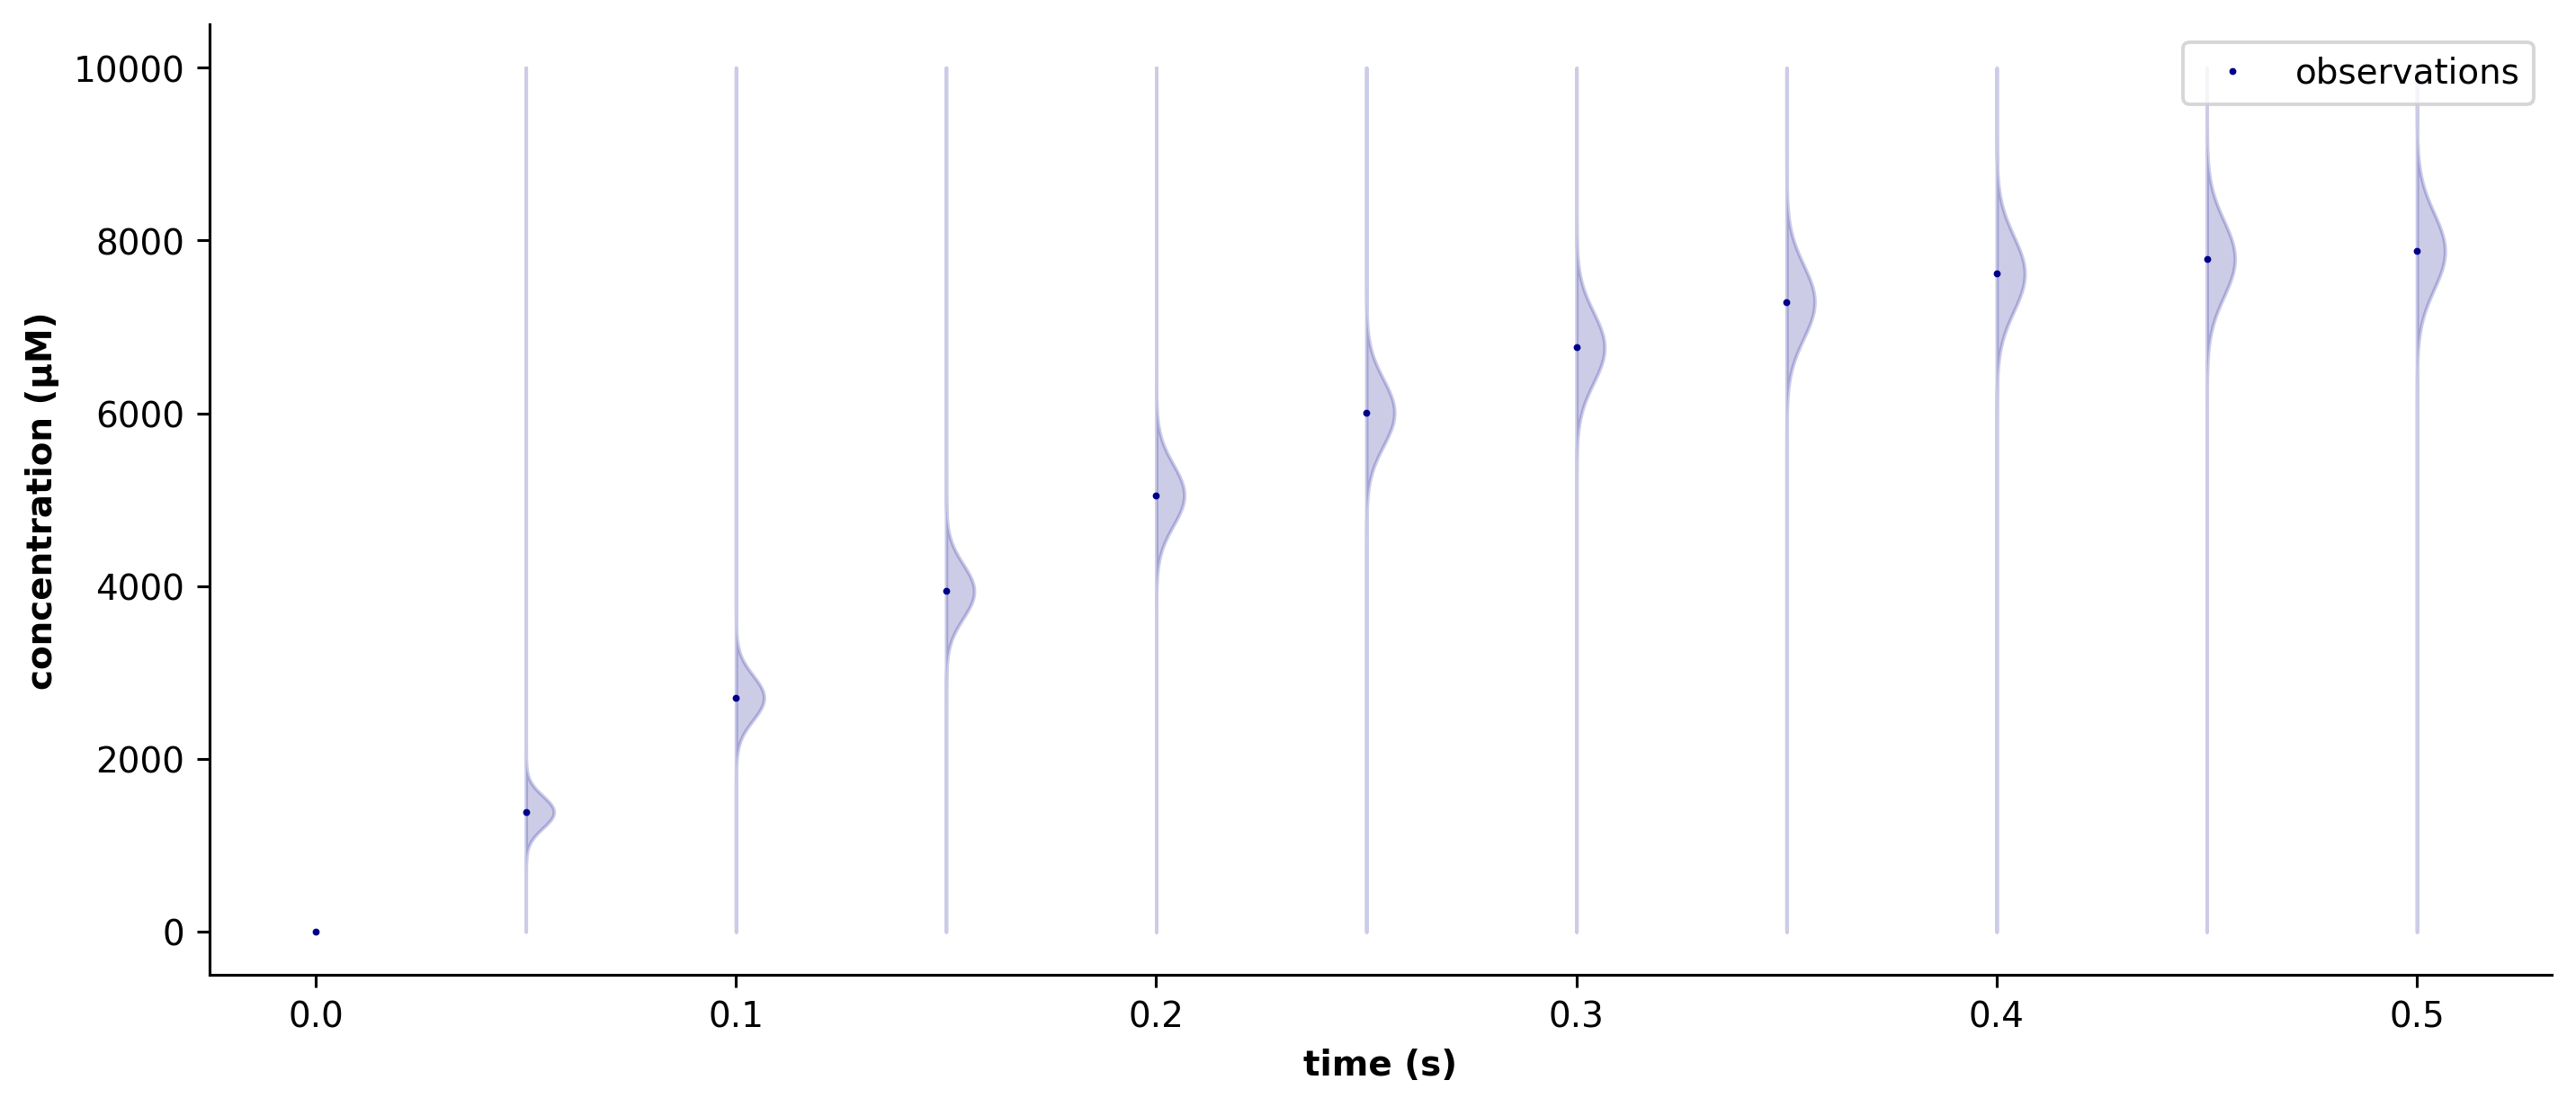

In [37]:
#collapse
# plot intuition for likelihood definition
plt.rcParams['figure.figsize'] = [12, 5]

ax = observations.rename('observations').plot.line(marker='.', lw=0, color=color(['P']), legend=True, markersize=2)

domain = np.linspace(0,10000,1000)

for x, y in observations.iloc[1:].items():
    distrib = scipy.stats.norm(loc=y, scale=np.sqrt(y)*σ)
    ax.fill_betweenx(domain, [x]*1000, x2=x+distrib.pdf(domain)/distrib.pdf(y)/150, color=color(['P']), alpha=0.2)

fig_style(ax)

Concretely, the likelihood is the product distribution of each of the gaussian marginals centered around the measurements. These form a multivariate normal, diagonal since we neglect to add covariances.

$$p(D|\theta) = \displaystyle \prod_{t=0}^{0.5} p_t(\color{blue}{[\mathrm{P}]_t} \color{black}) \textrm{  where  } p_t \textrm{  is the density of  }  \color{red}{[\mathrm{P}]_t} \color{black} \sim \mathcal{N}( \color{00008b}{[\mathrm{P}]_t} \color{black}, \sigma \sqrt{ \color{00008b}{[\mathrm{P}]_t }}\color{black} )$$

Which leaves us with a "hyperparameter"  $\sigma$.

In [38]:
likelihood_dist = multivariate_normal(mean=observations.values[1:], cov=σ * np.diag(sqrt(observations.values[1:])))

def likelihood_logpdf(ut): return likelihood_dist.logpdf(ut)

#### 3.1.3. Metropolis-Hastings

In [39]:
#collapse
# define integrate(), a(nother) function which integrates kinetic parameters to yield trajectories, for use with MCMC
def integrate(kinetic_params, dt=dt, initial_conditions=default_initial_conditions):

    [(_, E_0), (_, S_0)] = initial_conditions.items()
    t_eval = observations.index[1:]
    t_span = (0, t_eval[-1])
    y0 = [S_0, E_0, 0, 0]
    kinetic_params = {name: 10**val for name, val in kinetic_params.items()}
    fun = lambda t,y: dy_full(t, y, E_0=E_0, S_0=S_0, **kinetic_params)

    try:
        sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, first_step=dt, max_step=1e-2, method='LSODA')
        return sol.y[3] # Product
    except:
        return np.zeros(10)




We can now evaluate the prior $p(\theta)$ and the likelihood $p(D|\theta)$ of kinetic parameters $\theta = \{\kon, \koff, \kcat, \kuncat\}$. Those two distributions permit us to elaborate an Markov Chain Monte Carlo (MCMC) routine to sample from the posterior $p(\theta|D) \propto p(D|\theta) \cdot p(\theta)$. The algorithm is as follows: 

Repeat: 
1. Draw kinetic parameters from the proposal distribution. 
2. Integrate the system with the proposed kinetic parameters.
3. Evaluate the likelihood of the trajectory generated in step 2.
4. Accept/Reject the proposal by a Metropolis-Hastings criterion.
5. Append the current kinetic parameters to the Markov Chain. 
5. Construct a proposal distribution around the current kinetic parameters.


Since the likelihood assigns most of the probability mass to a fairly narrow region of parameter space, most parameter sets have extremely low probability. In order to preserve some numerical stability, we log-transform the typical Metropolis-Hastings expressions. So typically $π_t = \mathrm{likelihood\_pdf}(u_t) \cdot \mathrm{prior\_pdf}(θ_t)$ and the acceptance criterion is $\frac{π_{t+1}}{π_t} > \mathrm{rand}([0,1])$. In log space, the acceptance criterion becomes: $\log(π_{t+1}) - \log(π_t) > \log(\mathrm{rand}([0,1]))$ with $\log(π_t) = \mathrm{likelihood\_logpdf}(u_t) + \mathrm{prior\_logpdf}(θ_t)$.




In [40]:
def MH_MCMC(chain_length=1e3):

    θt = sample_prior()
    ut = integrate(θt)
    πt = likelihood_logpdf(ut) + prior_logpdf(**θt)
    if all(ut == 0): return MH_MCMC(chain_length)

    cov = np.eye(4) * 5e-4
    i = 0
    accept_ratio = 0
    chain = []
    samples = []

    while i < chain_length:

        θtp1 = proposal(θt, cov)
        utp1 = integrate(θtp1)
        πtp1 = likelihood_logpdf(utp1) + prior_logpdf(**θtp1)

        if πtp1 - πt > np.log(np.random.rand()):

            θt, ut, πt = θtp1, utp1, πtp1
            accept_ratio += 1

        chain.append(θt)
        samples.append(ut)

        i += 1

        if i % 100 == 0 and i > 300:
            # cov = pd.DataFrame(chain[100:]).cov()
            print(i, end='\r')

    chain = pd.DataFrame(chain)
    samples = pd.DataFrame(np.hstack((np.zeros((len(chain), 1)), samples)), columns=observations.index)
    accept_ratio = accept_ratio/chain_length

    return chain, samples, accept_ratio


Our proposal density for the time being can be a simple isotropic gaussian around the current parameters.

In [41]:
def proposal(θt, cov):

    μ = [θt['k_on'], θt['k_off'], θt['k_cat'], θt['k_uncat']]

    θtp1 = dict(zip(['k_on', 'k_off', 'k_cat', 'k_uncat'], np.random.multivariate_normal(μ, cov)))

    return θtp1


Now let's put it into practice:

In [42]:
chain_length = 1e3
chain, samples, accept_ratio = MH_MCMC(chain_length=chain_length)
print('accept_ratio:', accept_ratio)

accept_ratio: 0.194


In [43]:
def fig_style_3(ax):
    for side in ["right","top"]: ax.spines[side].set_visible(False)
    ax.set_xlabel('chain',  weight='bold')
    ax.set_ylabel('log parameter values',  weight='bold')

In [44]:
def plot_chain(chain, ax=None):
    if ax is None: fig, ax = plt.subplots()
    chain.plot.line(xlim=(0,len(chain)), color=[c[param_name] for param_name in chain.columns], ax=ax)

    for param_name in chain.columns:
        param_value = default_kinetic_params[param_name]
        ax.axhline(np.log10(param_value), lw=0.5, color=c[param_name], linestyle='--')
        ax.fill_between(np.arange(len(chain)), chain[param_name], np.repeat(np.log10(param_value), len(chain)), color=c[param_name], alpha=0.05)

    fig_style_3(ax)

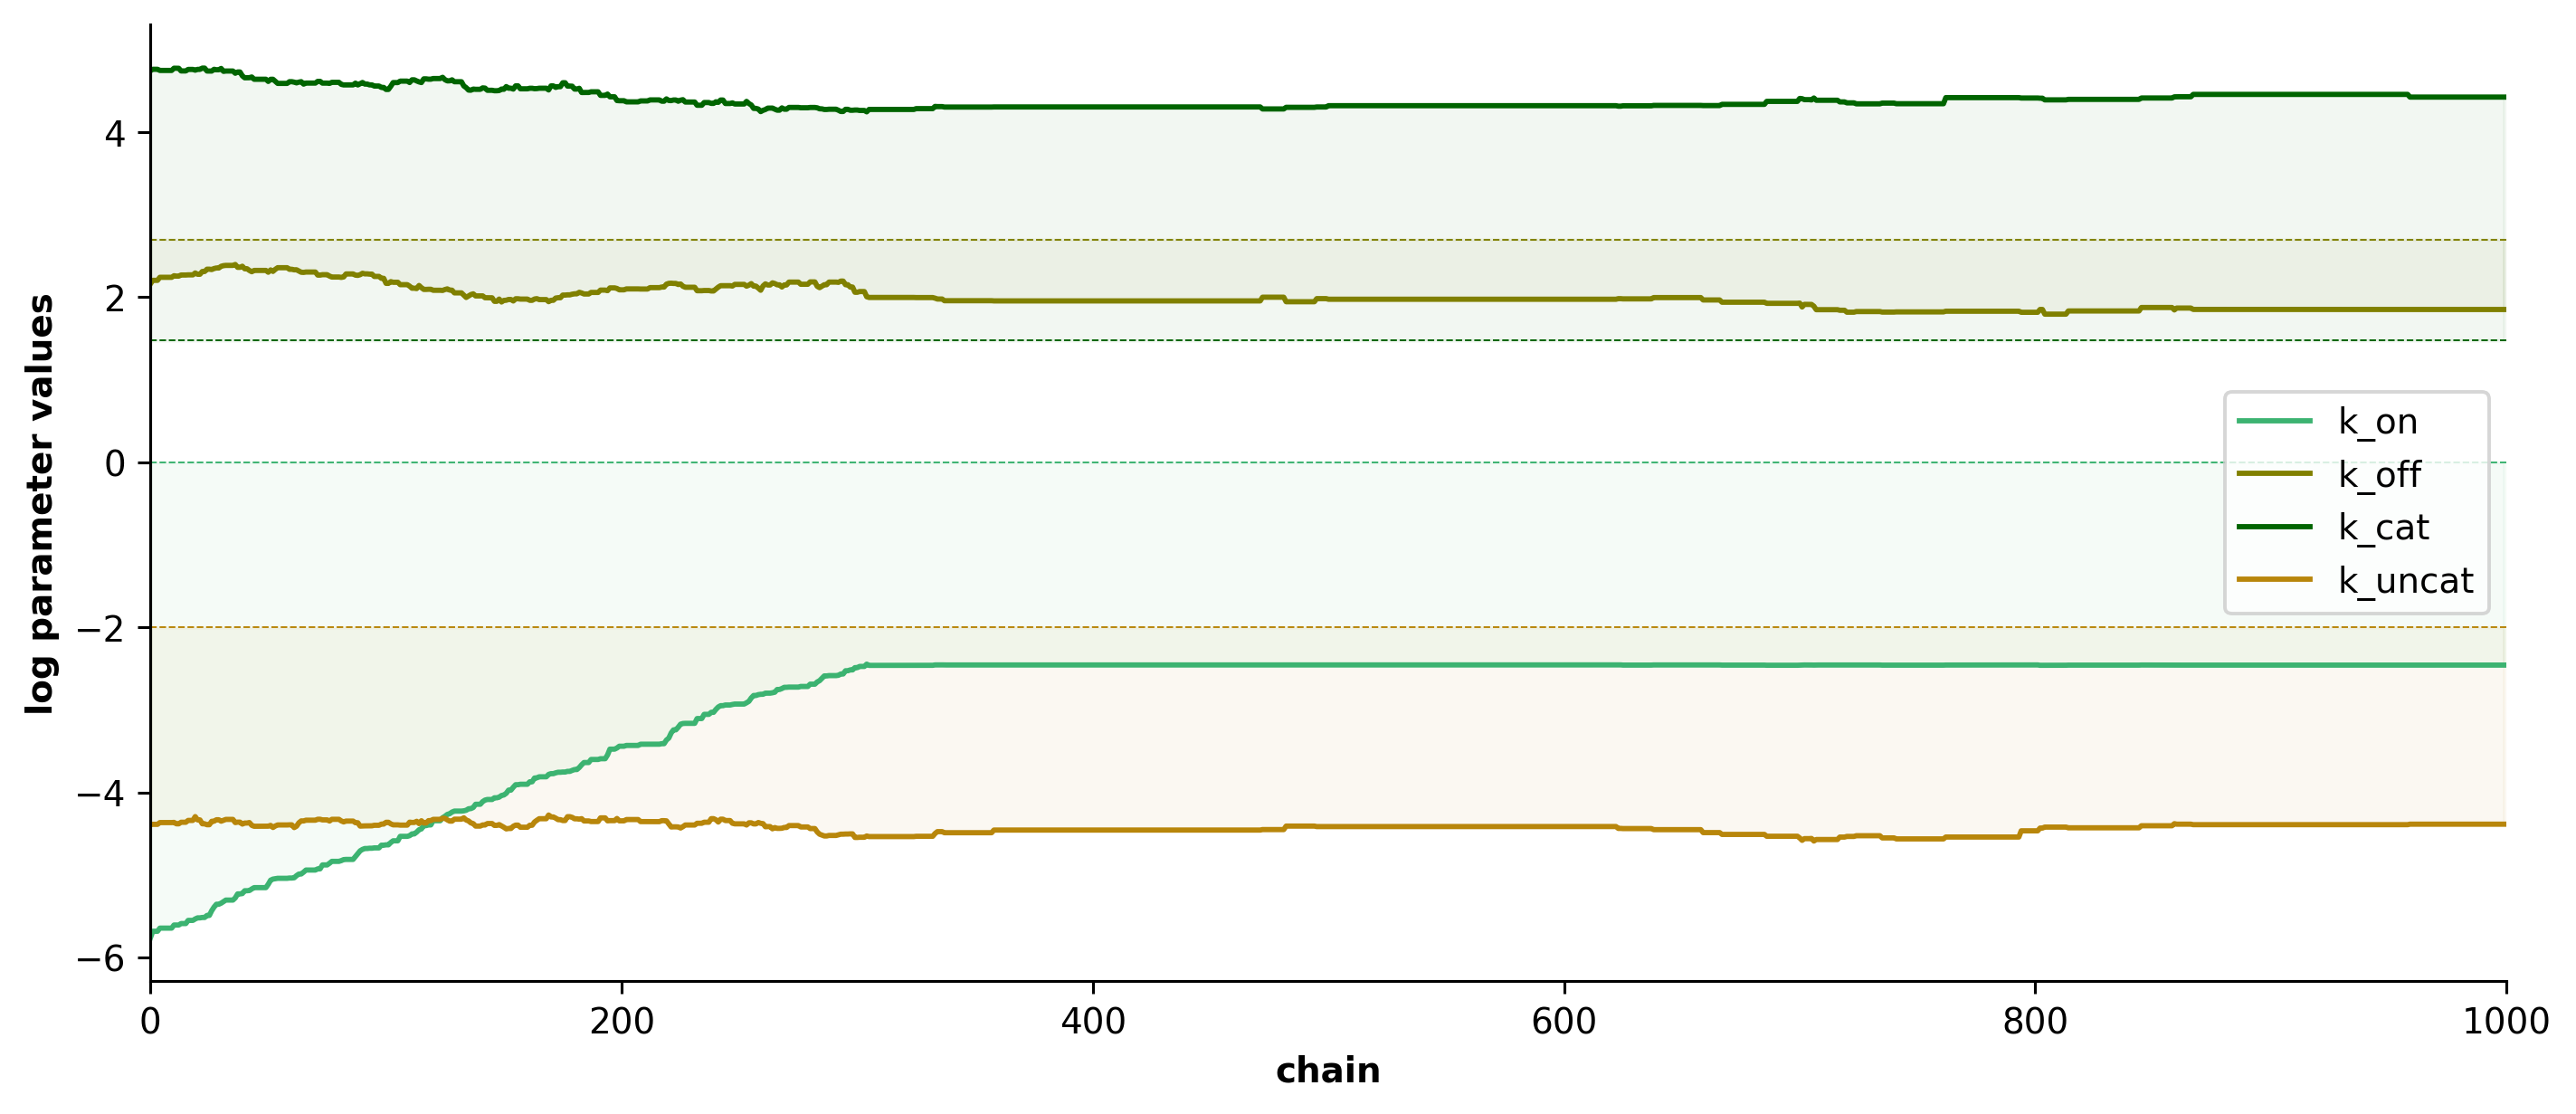

In [45]:
plot_chain(chain)


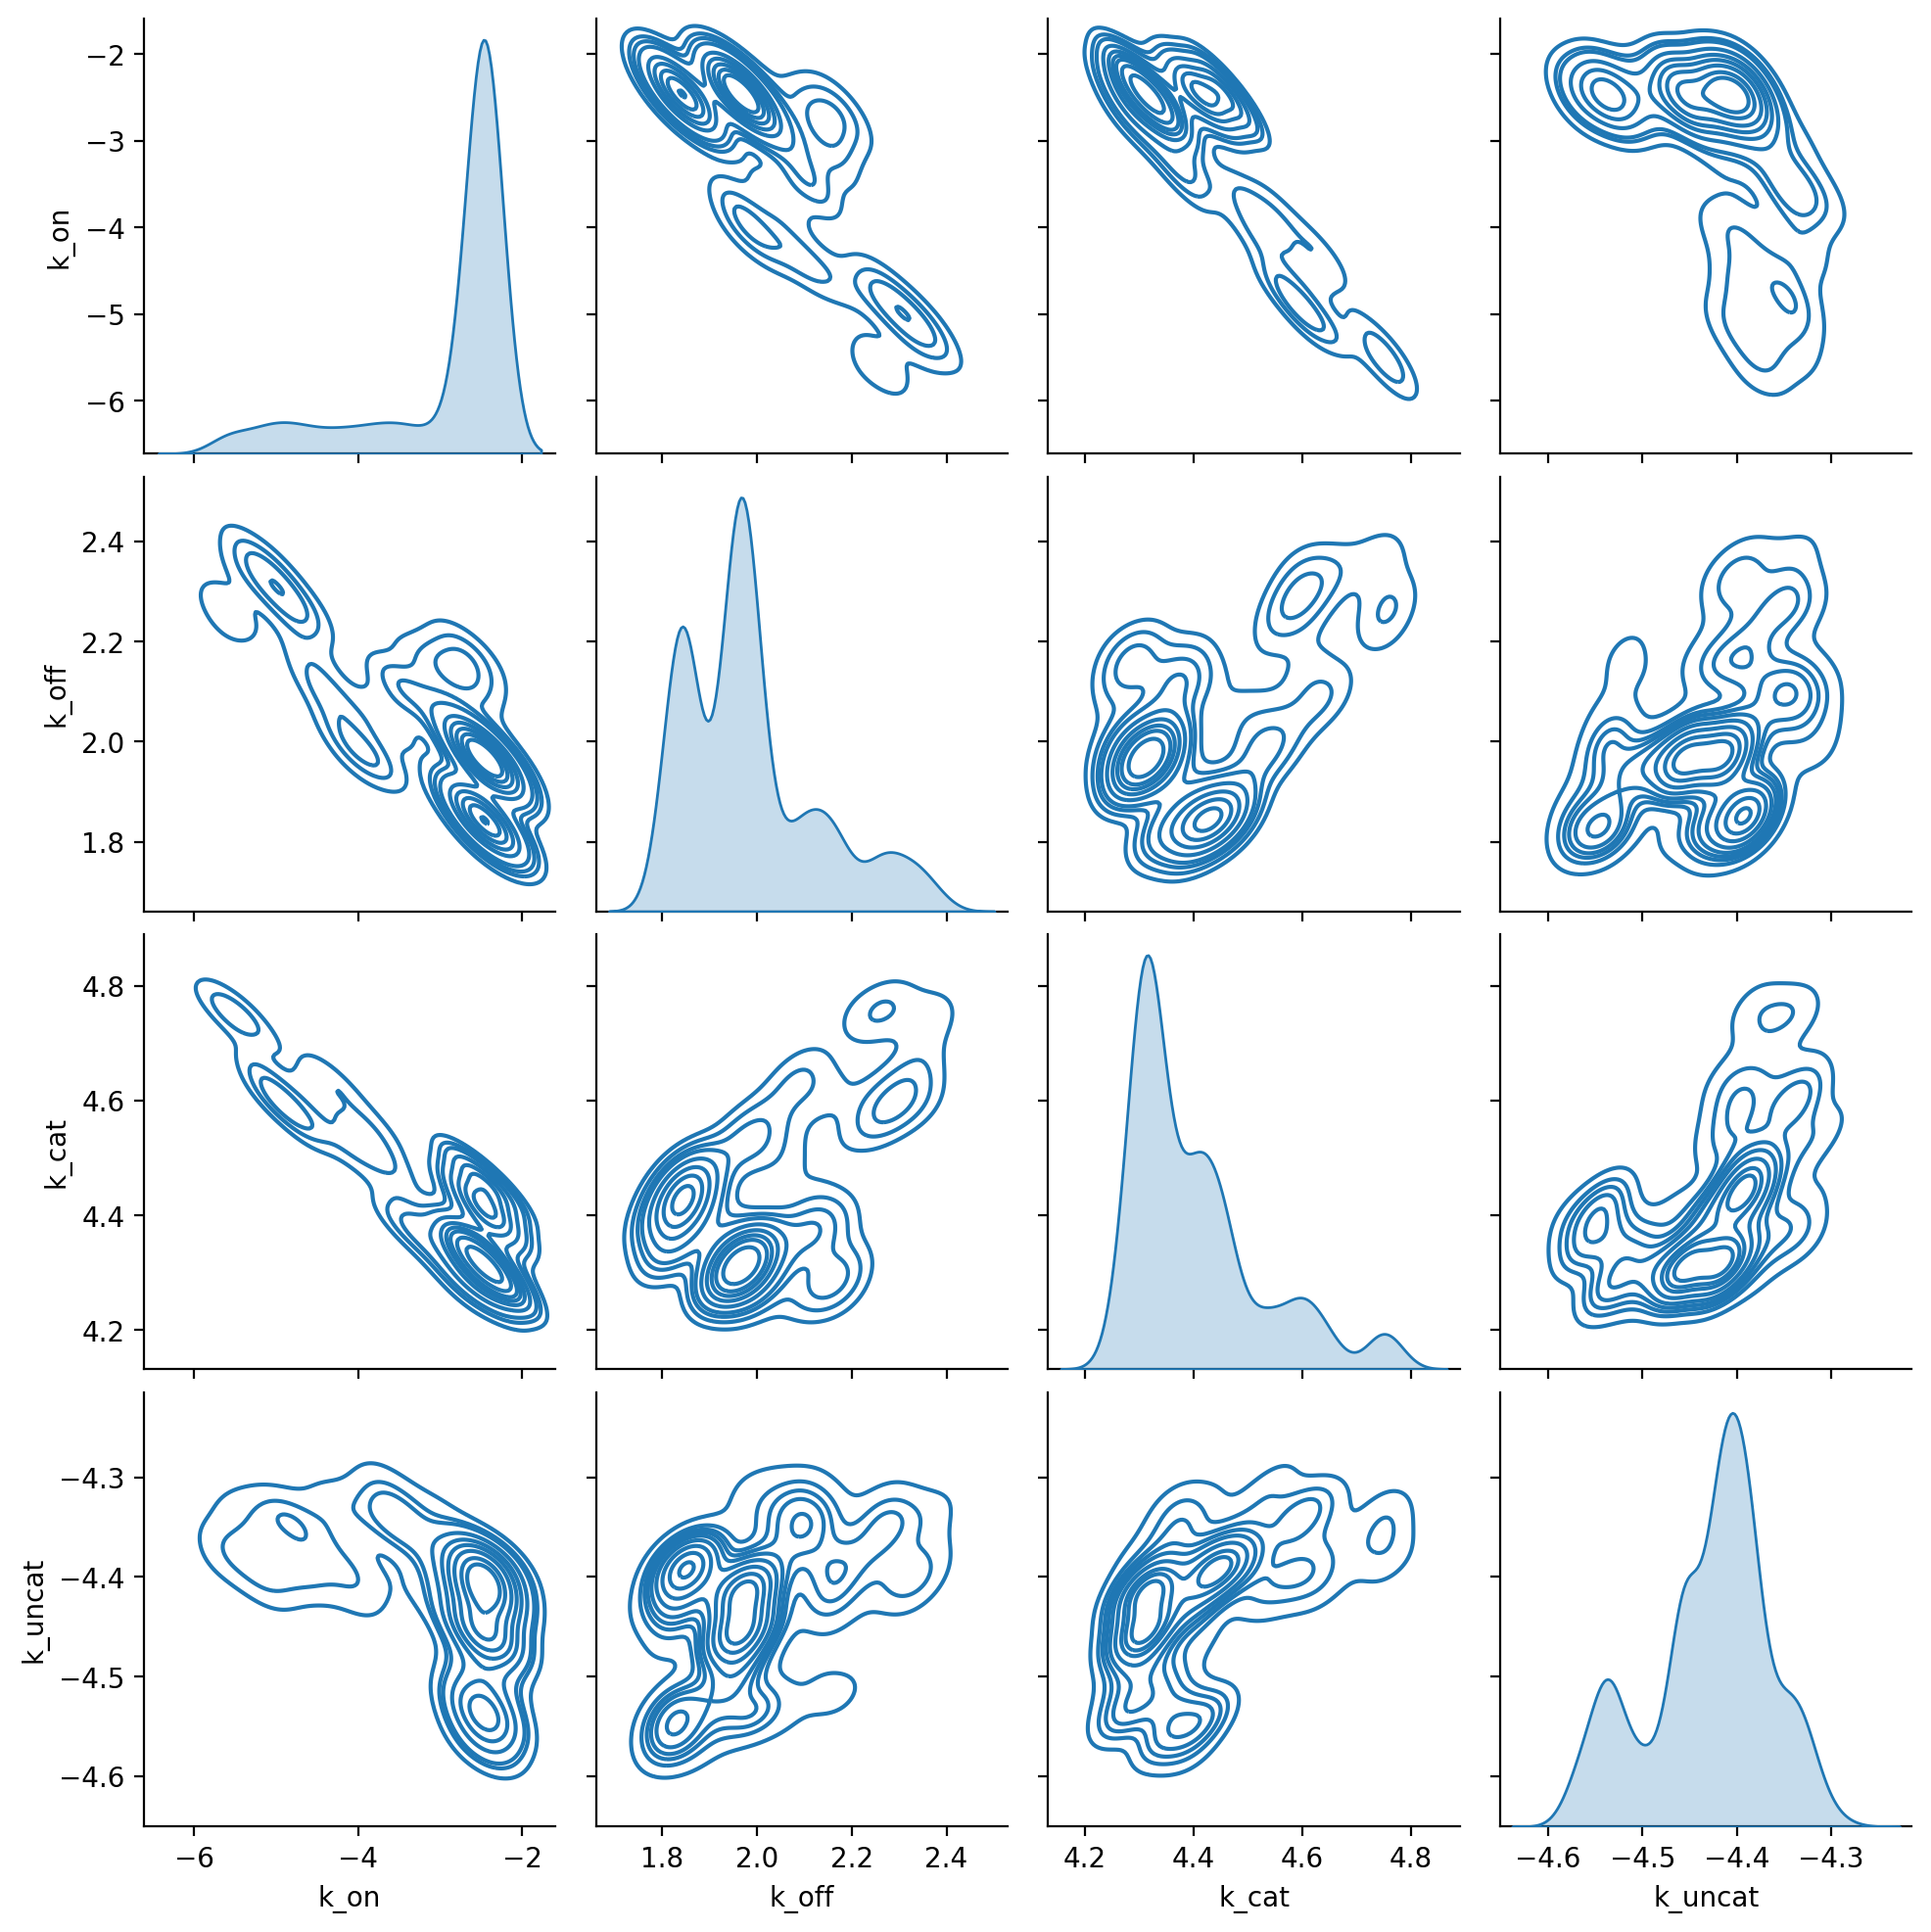

In [46]:
sns.pairplot(chain, kind="kde")
resize_fig(600, 600)

In [47]:
def plot_samples(samples, ax=None):
    if ax is None: fig, ax = plt.subplots()
    observations.plot.line(marker='o', lw=0, color=c['P'], ylim=(-300, 10800), ax=ax, legend=True)
    samples.T.plot.line(colormap=plt.get_cmap('plasma'), alpha=0.1, ax=ax, legend=False, zorder=1)
    fig_style(ax)

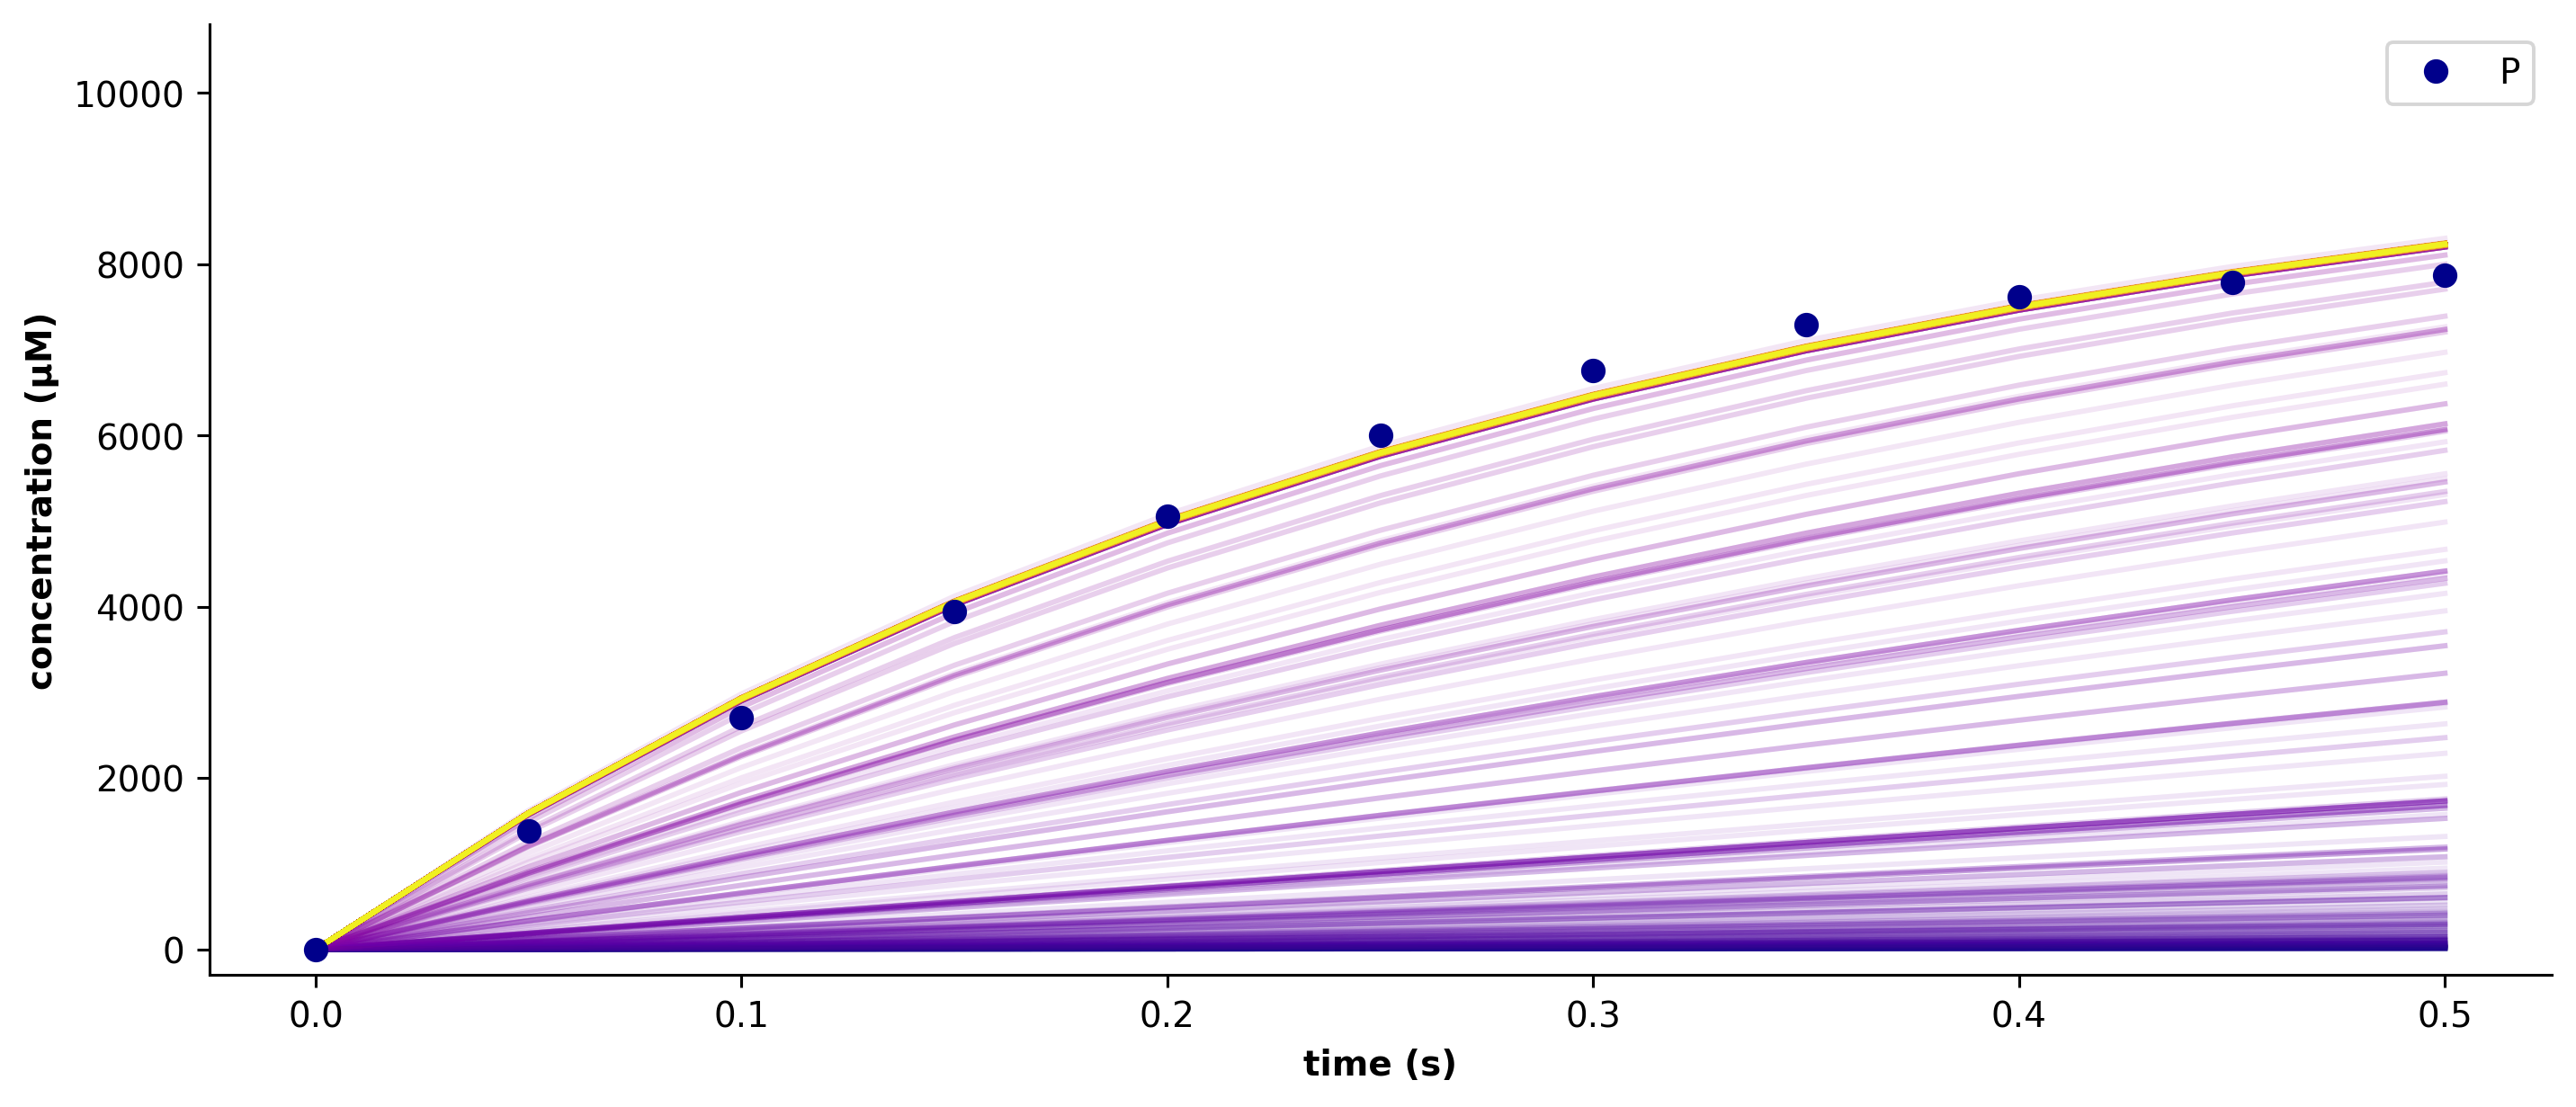

In [48]:
plot_samples(samples)

In [49]:
def MCMC_run():
    chain, samples, accept_ratio = MH_MCMC(chain_length=chain_length)
    fig, axs = plt.subplots(1, 2)
    plot_chain(chain, ax=axs[0])
    plot_samples(samples, ax=axs[1])
    print('accept_ratio:', accept_ratio)

accept_ratio: 0.079


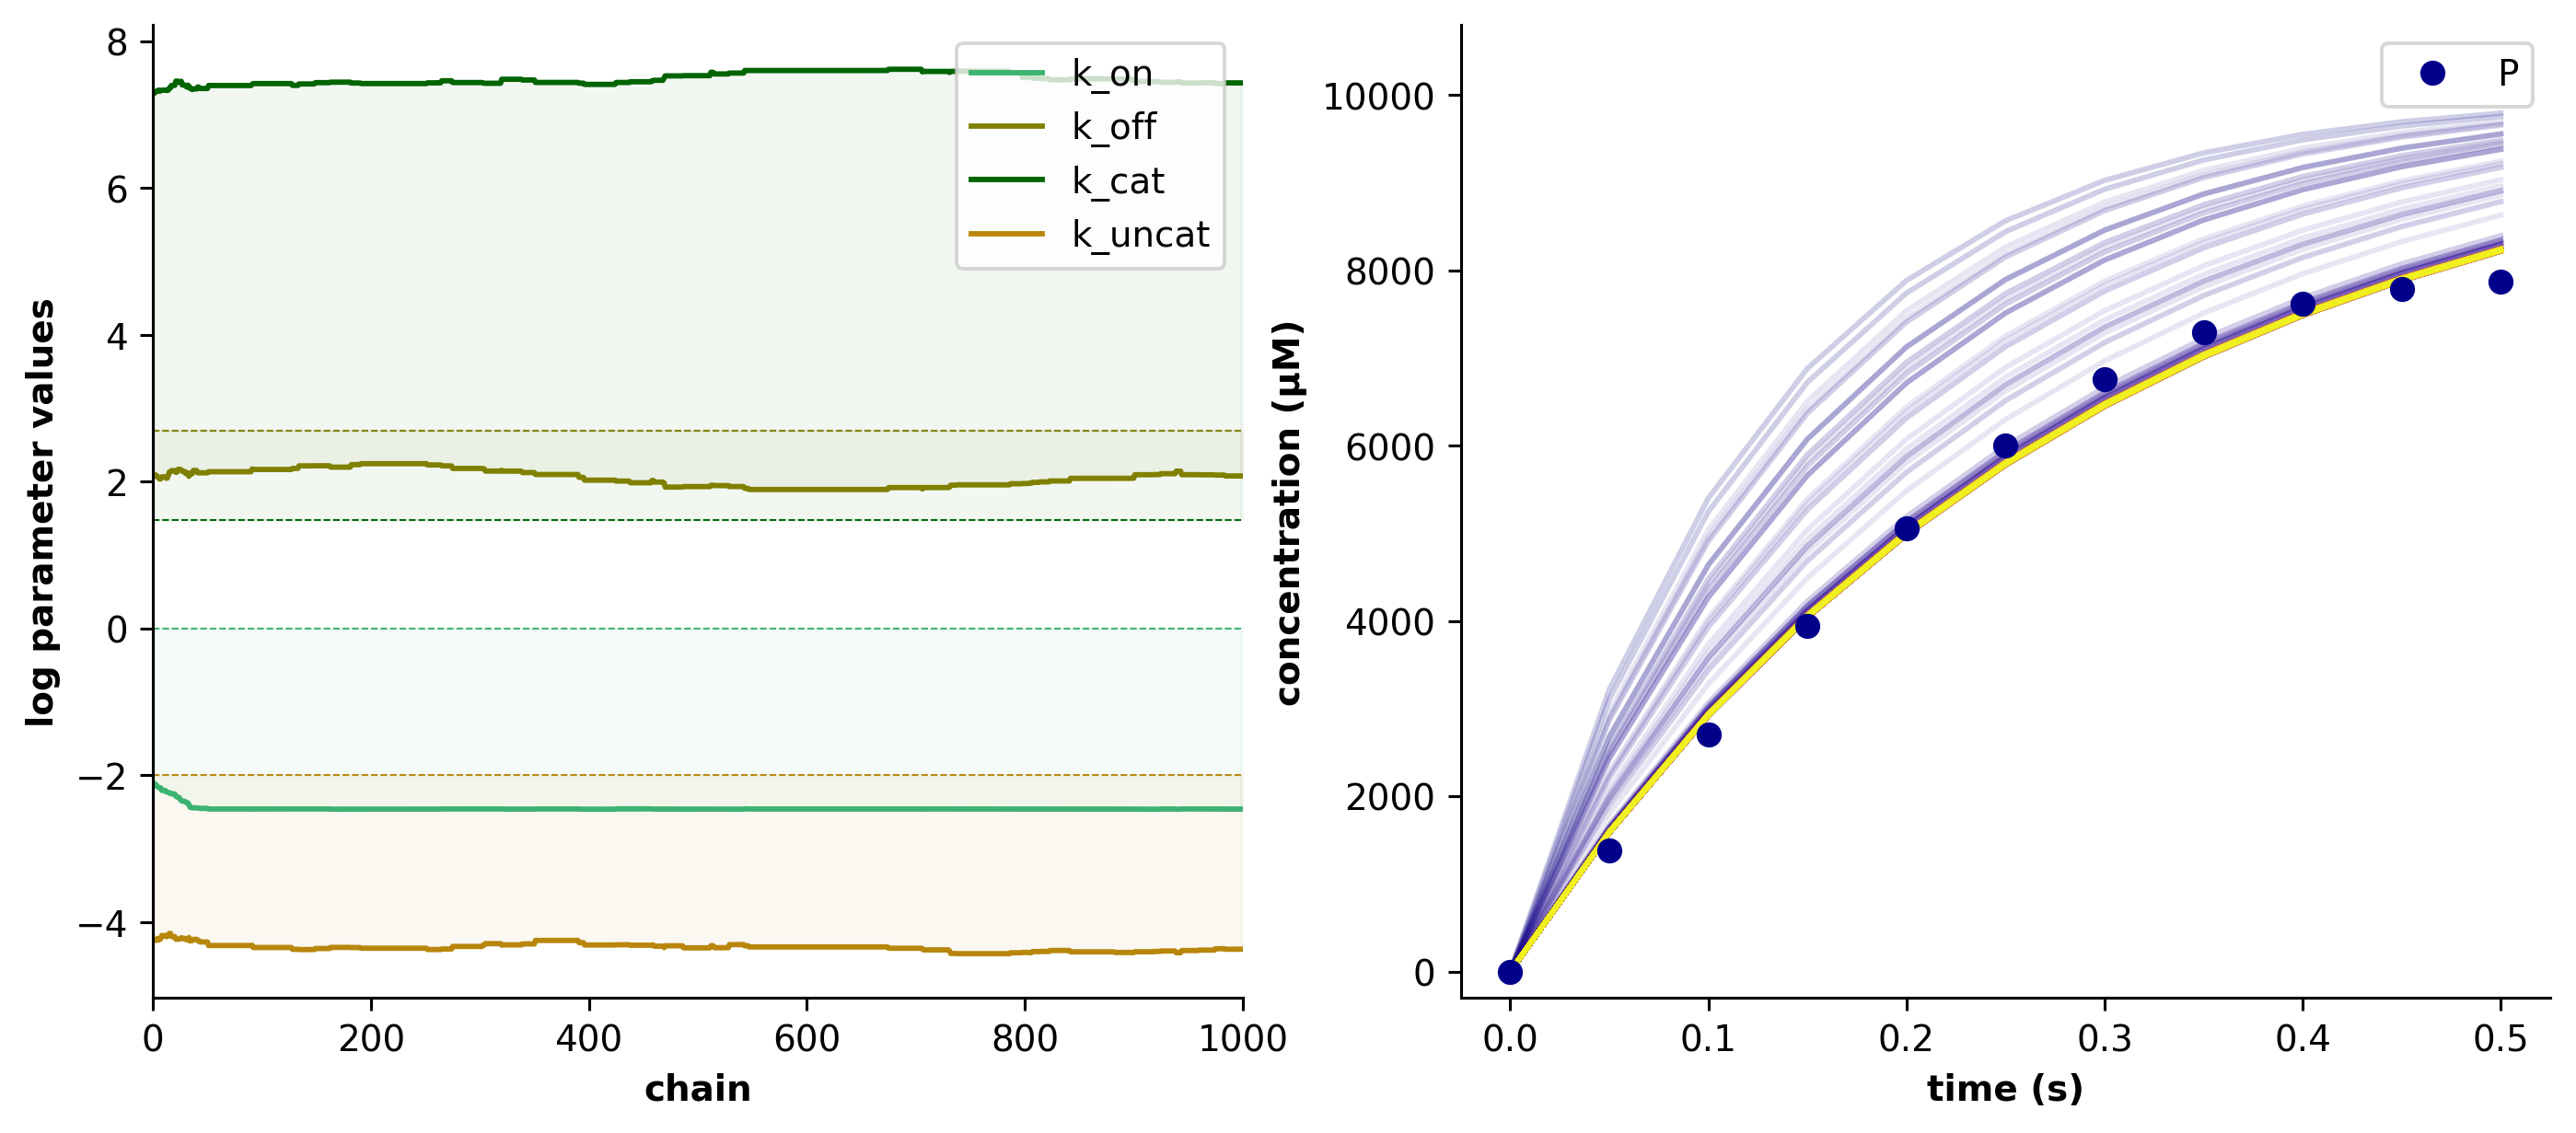

In [50]:
MCMC_run()

accept_ratio: 0.101


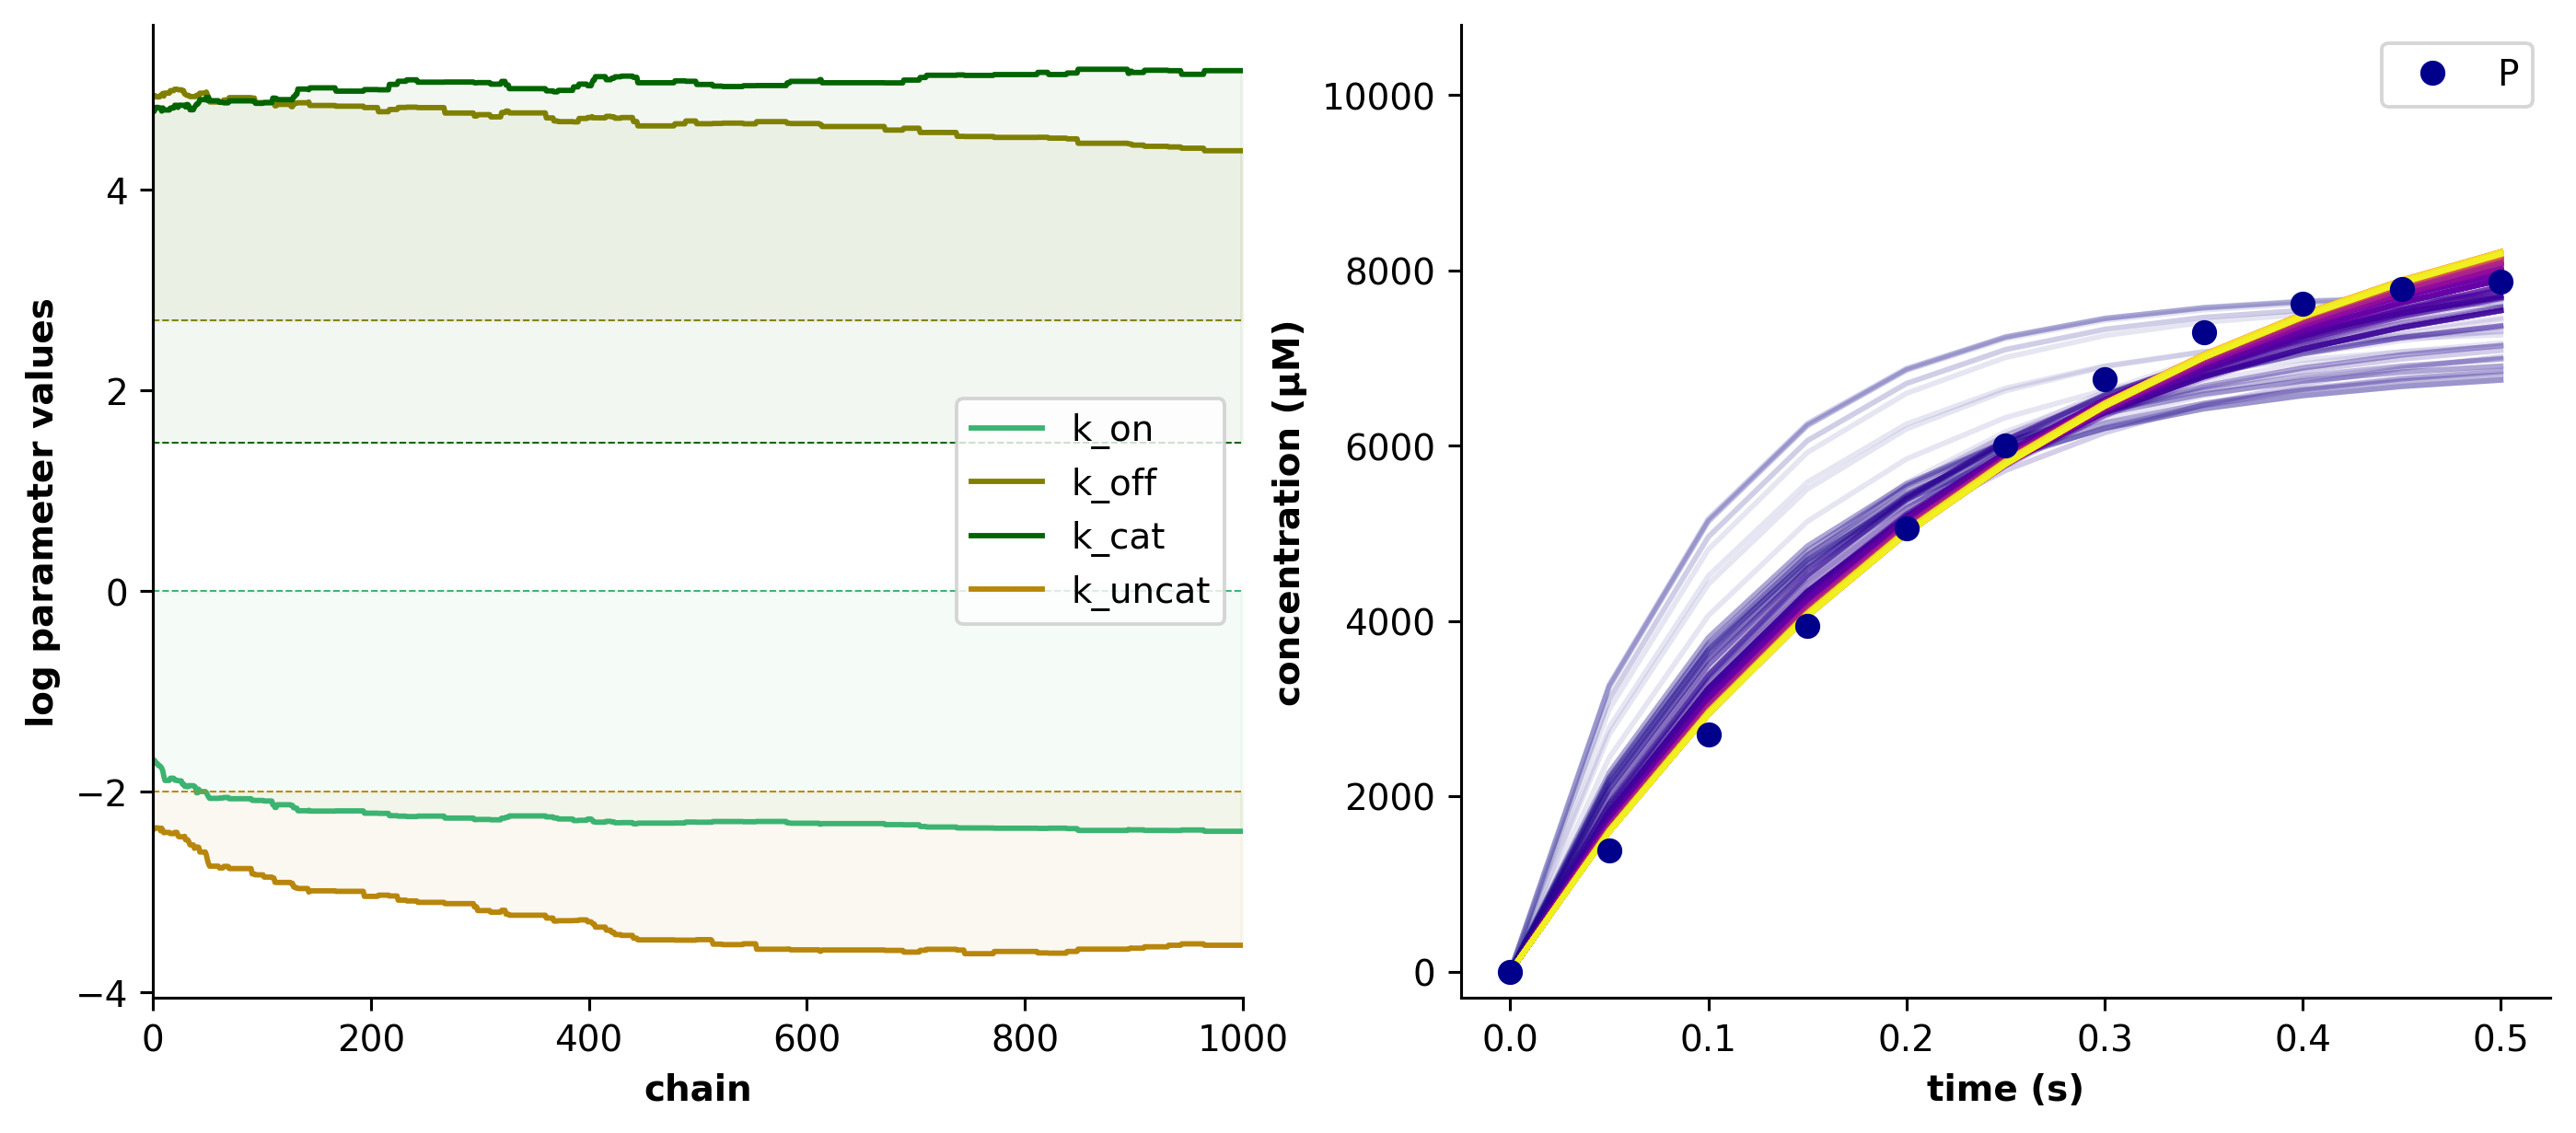

In [51]:
MCMC_run()

accept_ratio: 0.118


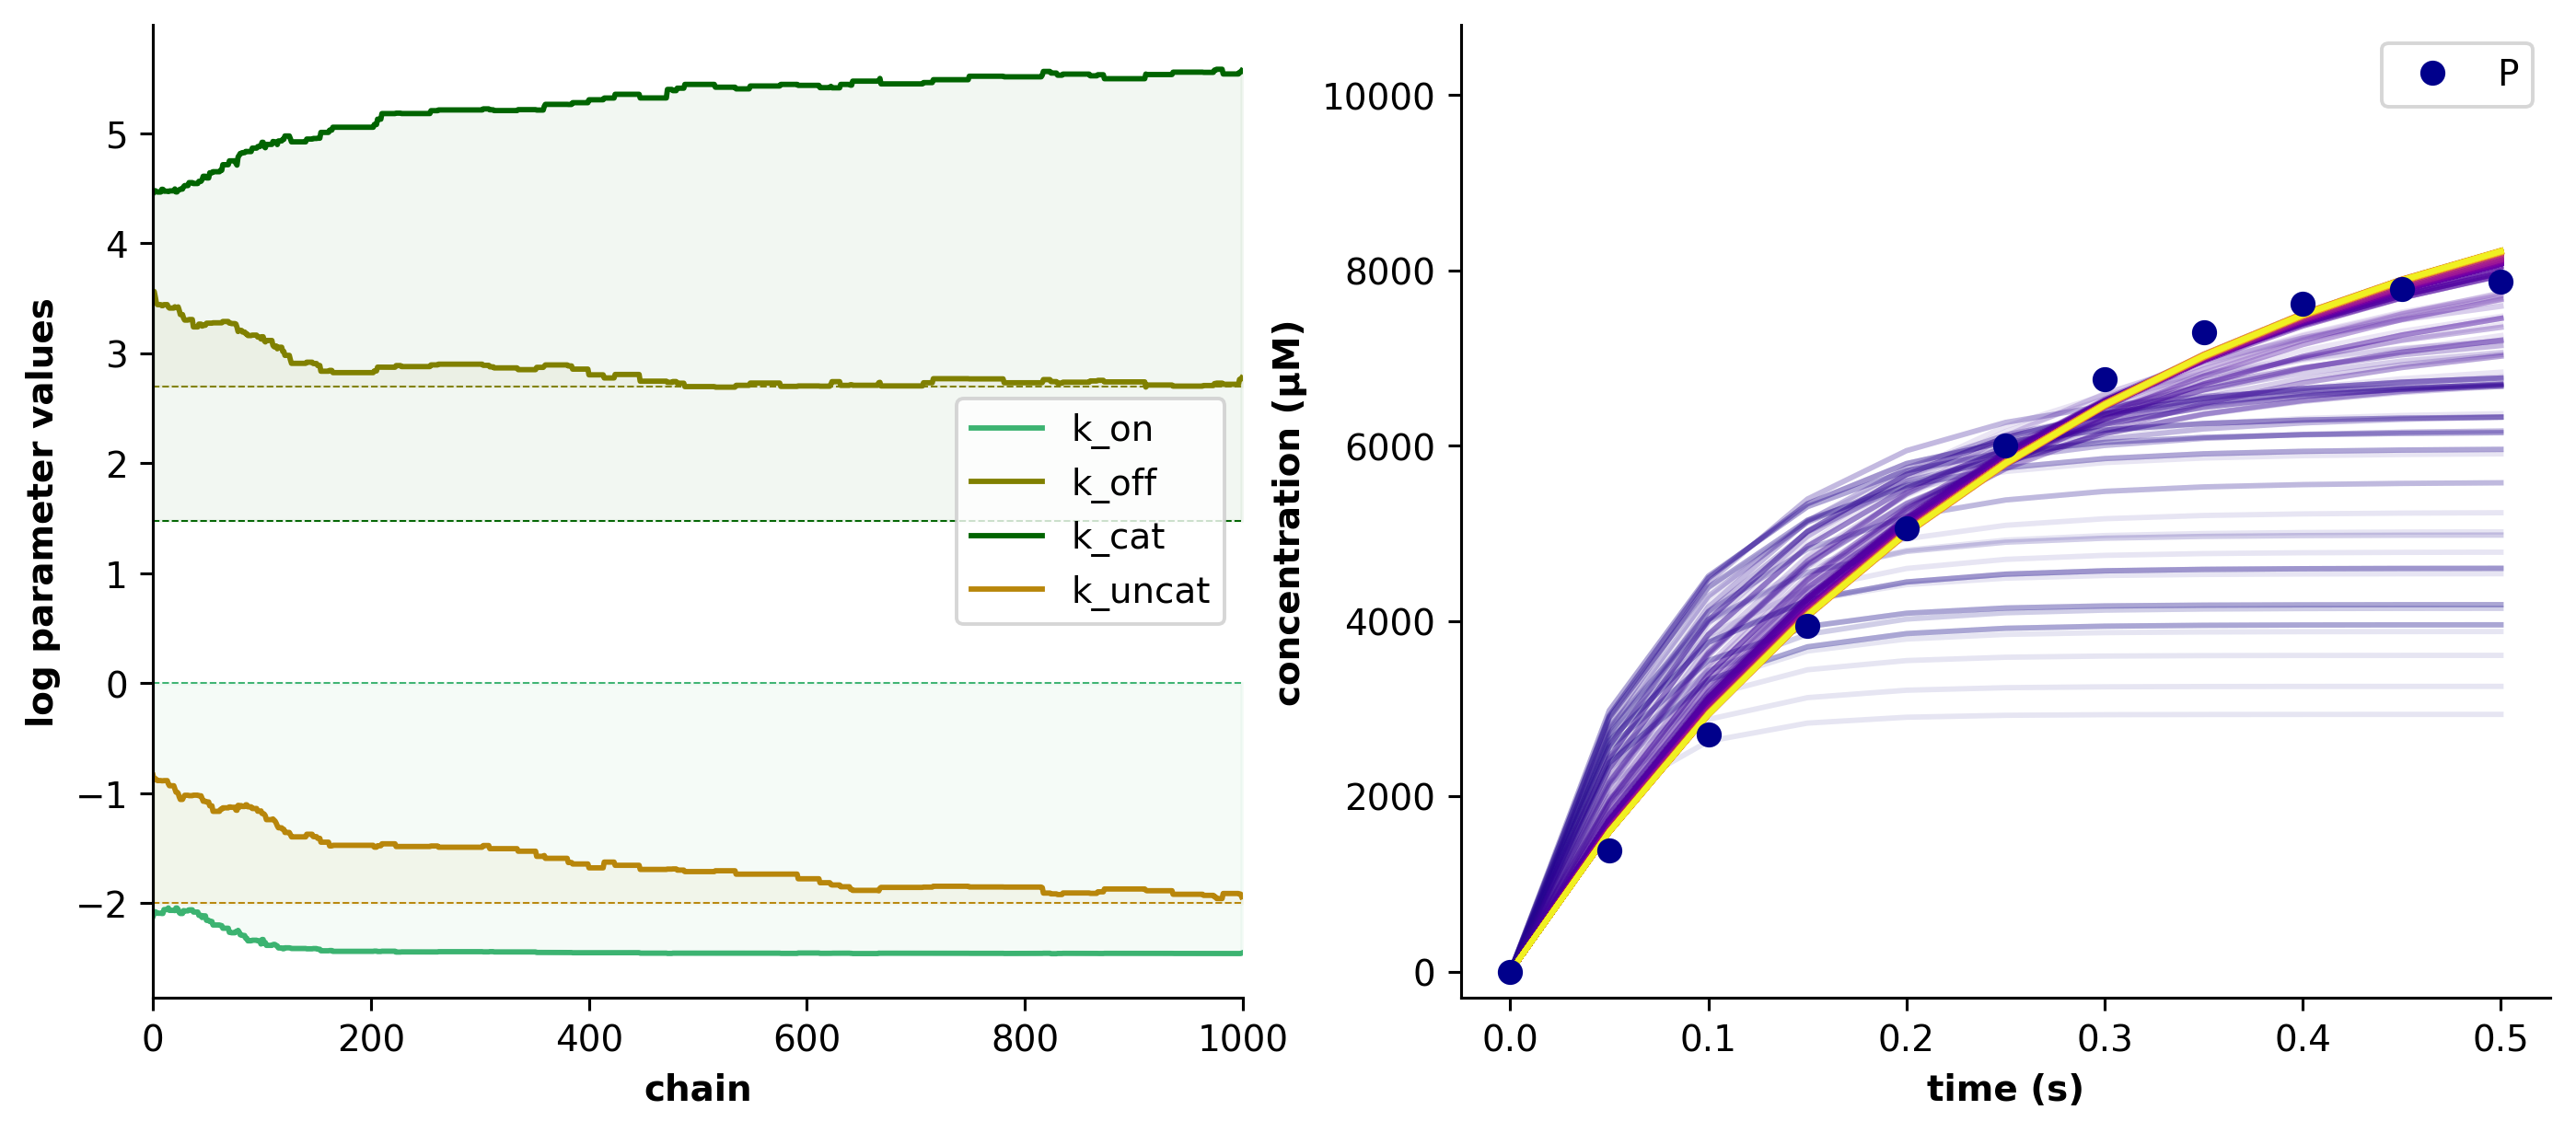

In [52]:
MCMC_run()

A few things pop out from the above chains: 
1. It appears to be possible to closely fit the observed data with very different parameter sets than the ones used to generate the observed trajectory.
2. It appears that our chain is finding local maxima in the posterior and struggling to escape. 

> Note: Some of the above trajectories appear non-smooth. That's only a consequence of the fact we're visualizing a coarse sampling of those trajectories -- the underlying trajectories are sampled much more densely by scipy's integrator. 

In [53]:
#collapse
# define euler_full(), which integrates the full kinetics with Euler's Method, and returns a trajectory
def euler_full_modified(dt, steps, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):

    S = S_0
    E = E_0
    ES = 0
    P = 0
    traj = []

    for _ in range(int(steps)):

        k_off_ES = k_off * ES
        k_on_E_S = k_on * E * S
        k_cat_ES = k_cat * ES
        k_uncat_E_P = k_uncat * E * P

        traj.append([S, E, ES, P, k_off_ES, k_on_E_S, k_cat_ES, k_uncat_E_P])

        dS = k_off_ES - k_on_E_S
        dE = k_off_ES - k_on_E_S + k_cat_ES - k_uncat_E_P
        dES = k_on_E_S - k_off_ES - k_cat_ES + k_uncat_E_P
        dP = k_cat_ES - k_uncat_E_P

        S += dS * dt
        E += dE * dt
        ES += dES * dt
        P += dP * dt

    return pd.DataFrame(traj, columns=['S', 'E', 'ES', 'P', 'k_off_ES', 'k_on_E_S', 'k_cat_ES', 'k_uncat_E_P'], index=np.around(np.linspace(0, dt*steps, int(steps)), 6))


In [54]:
modified_traj_full = euler_full_modified(dt, steps, **default_kinetic_params, **default_initial_conditions)

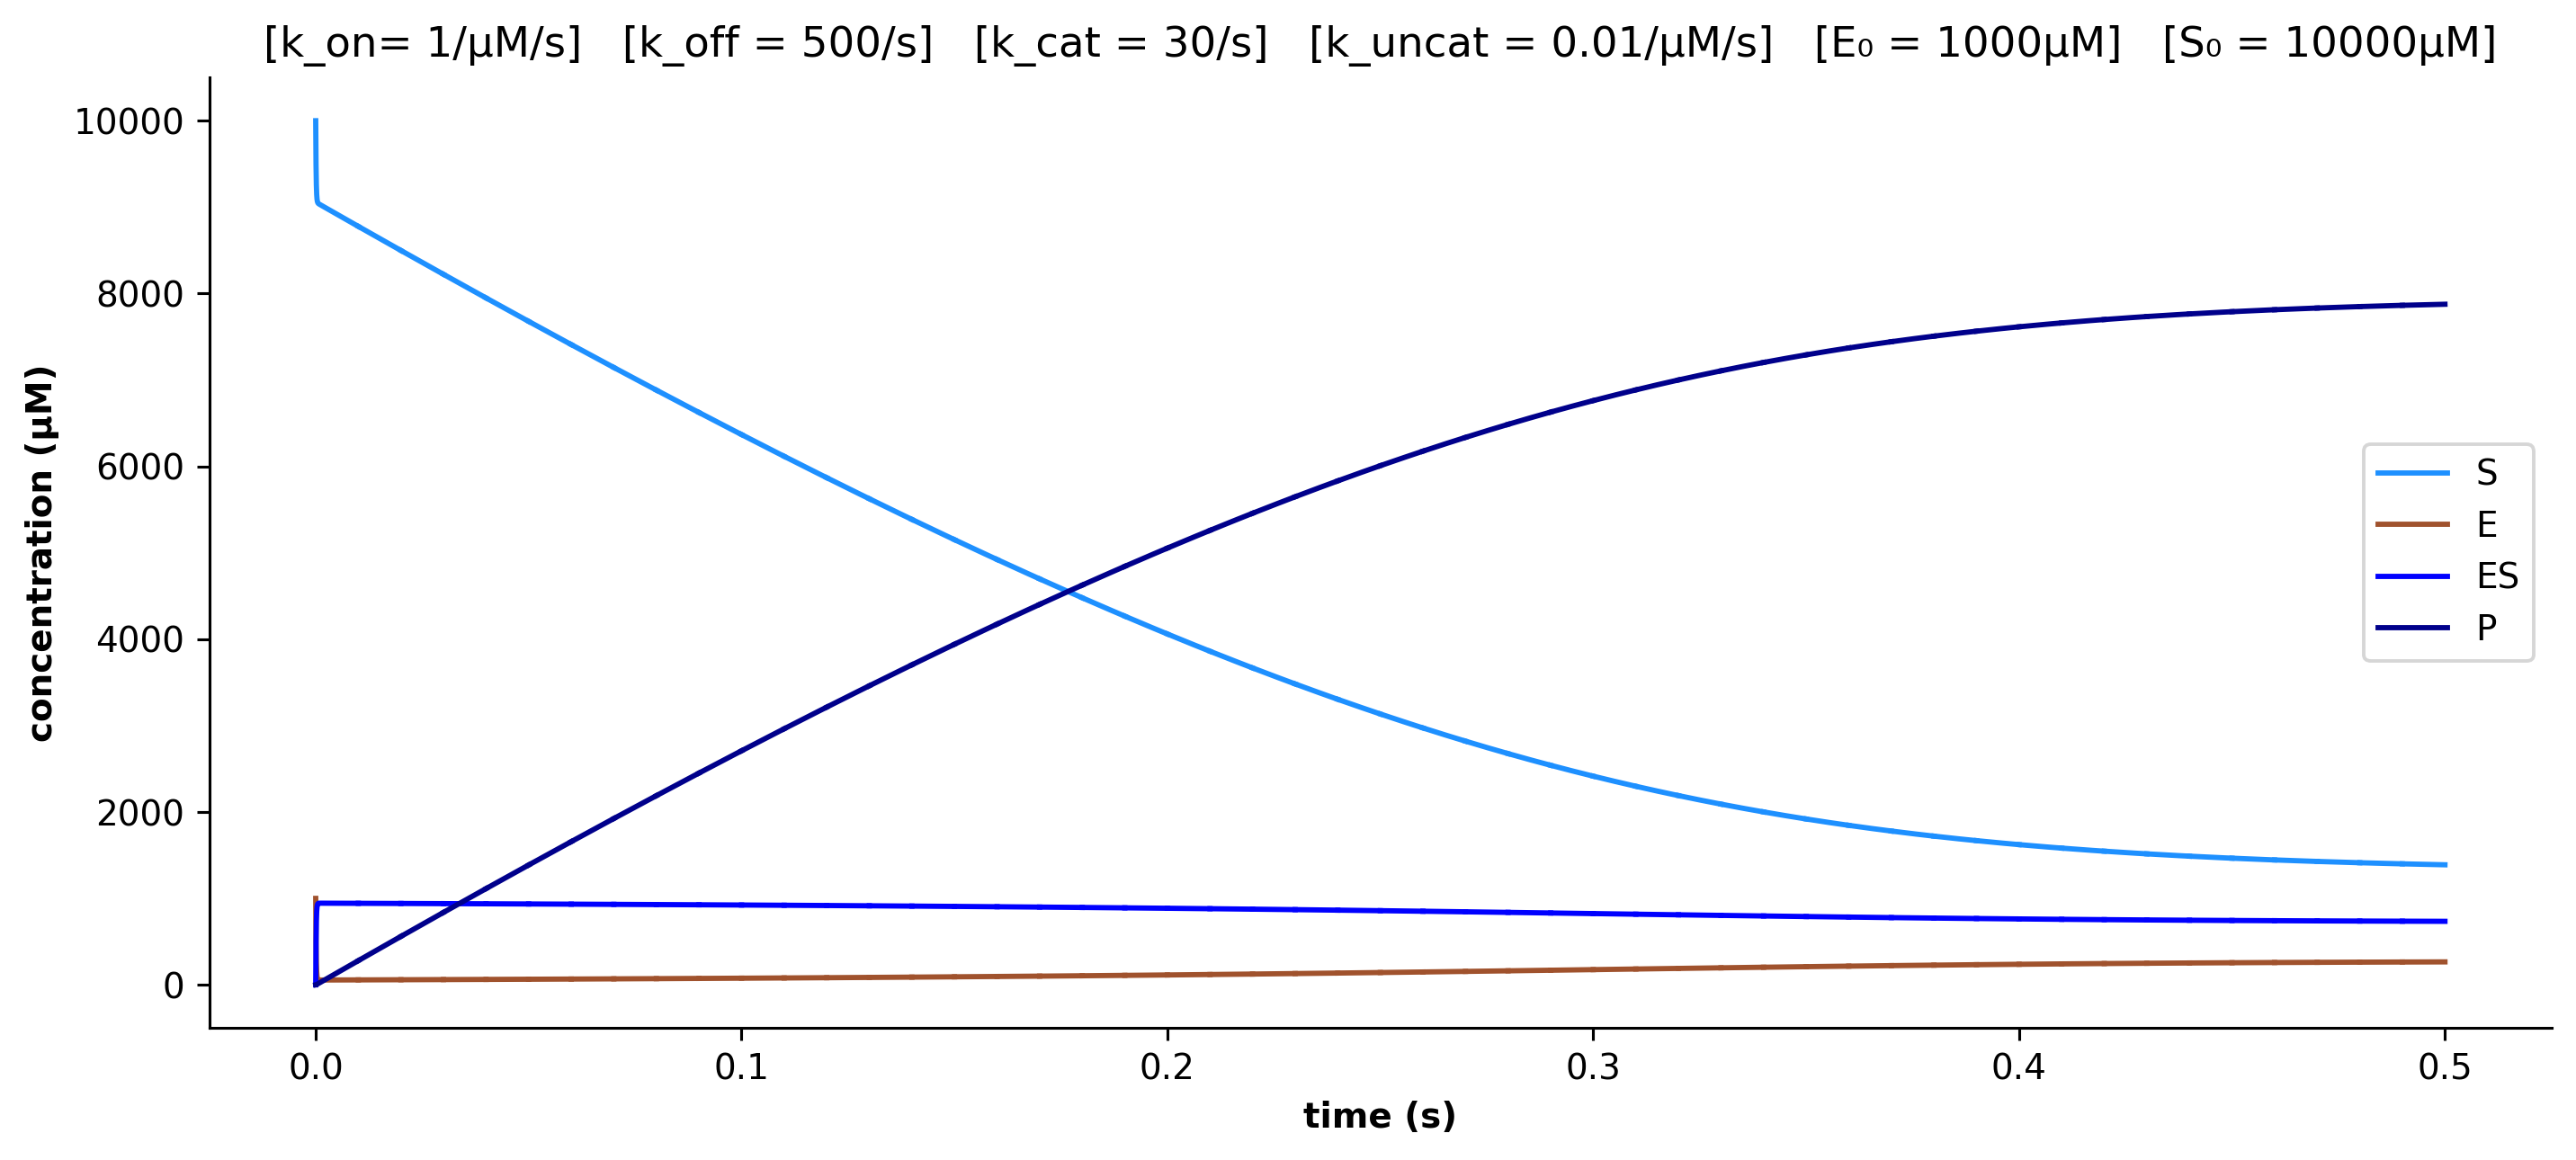

In [55]:
ax = modified_traj_full[['S', 'E', 'ES', 'P']].plot.line(title=param_string(**default_initial_conditions, **default_kinetic_params), color=color(default_traj_full.columns))
fig_style(ax)

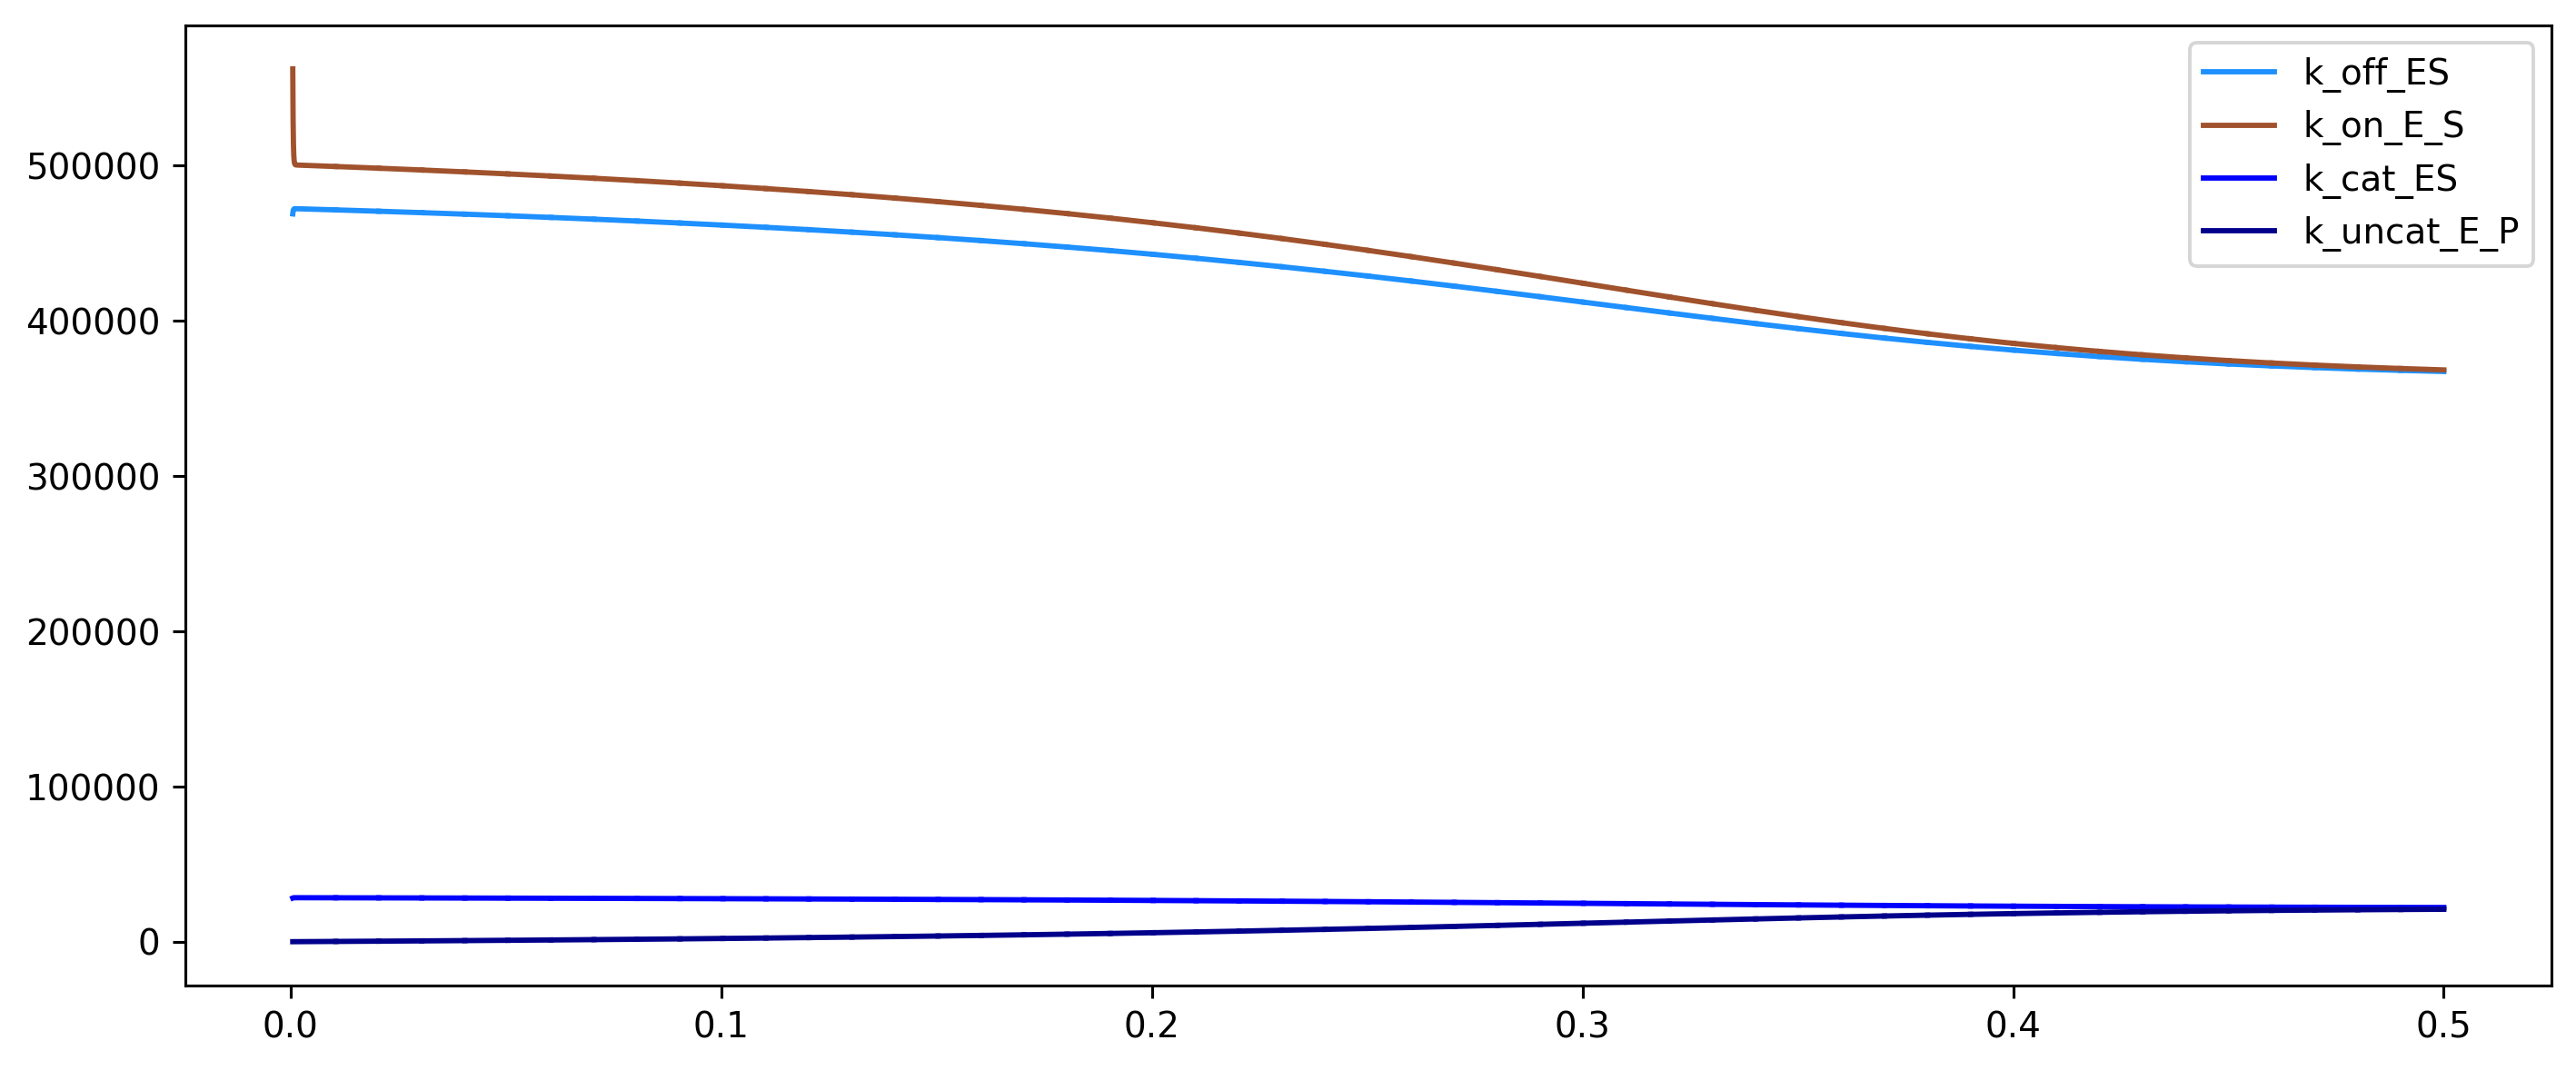

In [56]:
ax = modified_traj_full.iloc[500:][['k_off_ES', 'k_on_E_S', 'k_cat_ES', 'k_uncat_E_P']].plot.line(color=color(default_traj_full.columns))
None

$$\begin{aligned}
    \frac{d[\mathrm{S}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\
    \frac{d[\mathrm{E}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] + k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{ES}]}{dt} &= - k_{\mathrm{off}}[\mathrm{ES}] + k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] - k_{\mathrm{cat}}[\mathrm{ES}] + k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{P}]}{dt} &= k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] 
\end{aligned}$$

### 3.2 Frequentist Approach: Inference by Optimization

In the previous section, our approach was to wander around parameter space, biasing our random walk towards regions of the parameter space where both the prior probability and likelihood were greater. After a certain number of samples, the samples from our random walk constitute an (asymptotically exact) estimate of the entire probability distribution over the values of the kinetic parameters. 

An alternative approach begins with another premise: 
- Suppose we want to incorporate **no** prior knowledge, and let the timeseries data _alone_ govern our determination of our enzyme's kinetic parameters.
- Suppose as well that instead of searching for a distribution of plausible parameters, we're only interested in finding the _single most likely set_ of parameters. 

These two choices recast the inference task as an optimization problem. 

Optimization problems require an objective, such as minimizing a loss (or cost) function. Let's use the conventional squared error between our trajectory $u$ and the data $d$: $G(u(t, \theta)) = \sum_t (\| d(t) - u(t, \theta) \|_2)^2$ illustrated below as the loss function we'll minimize. 



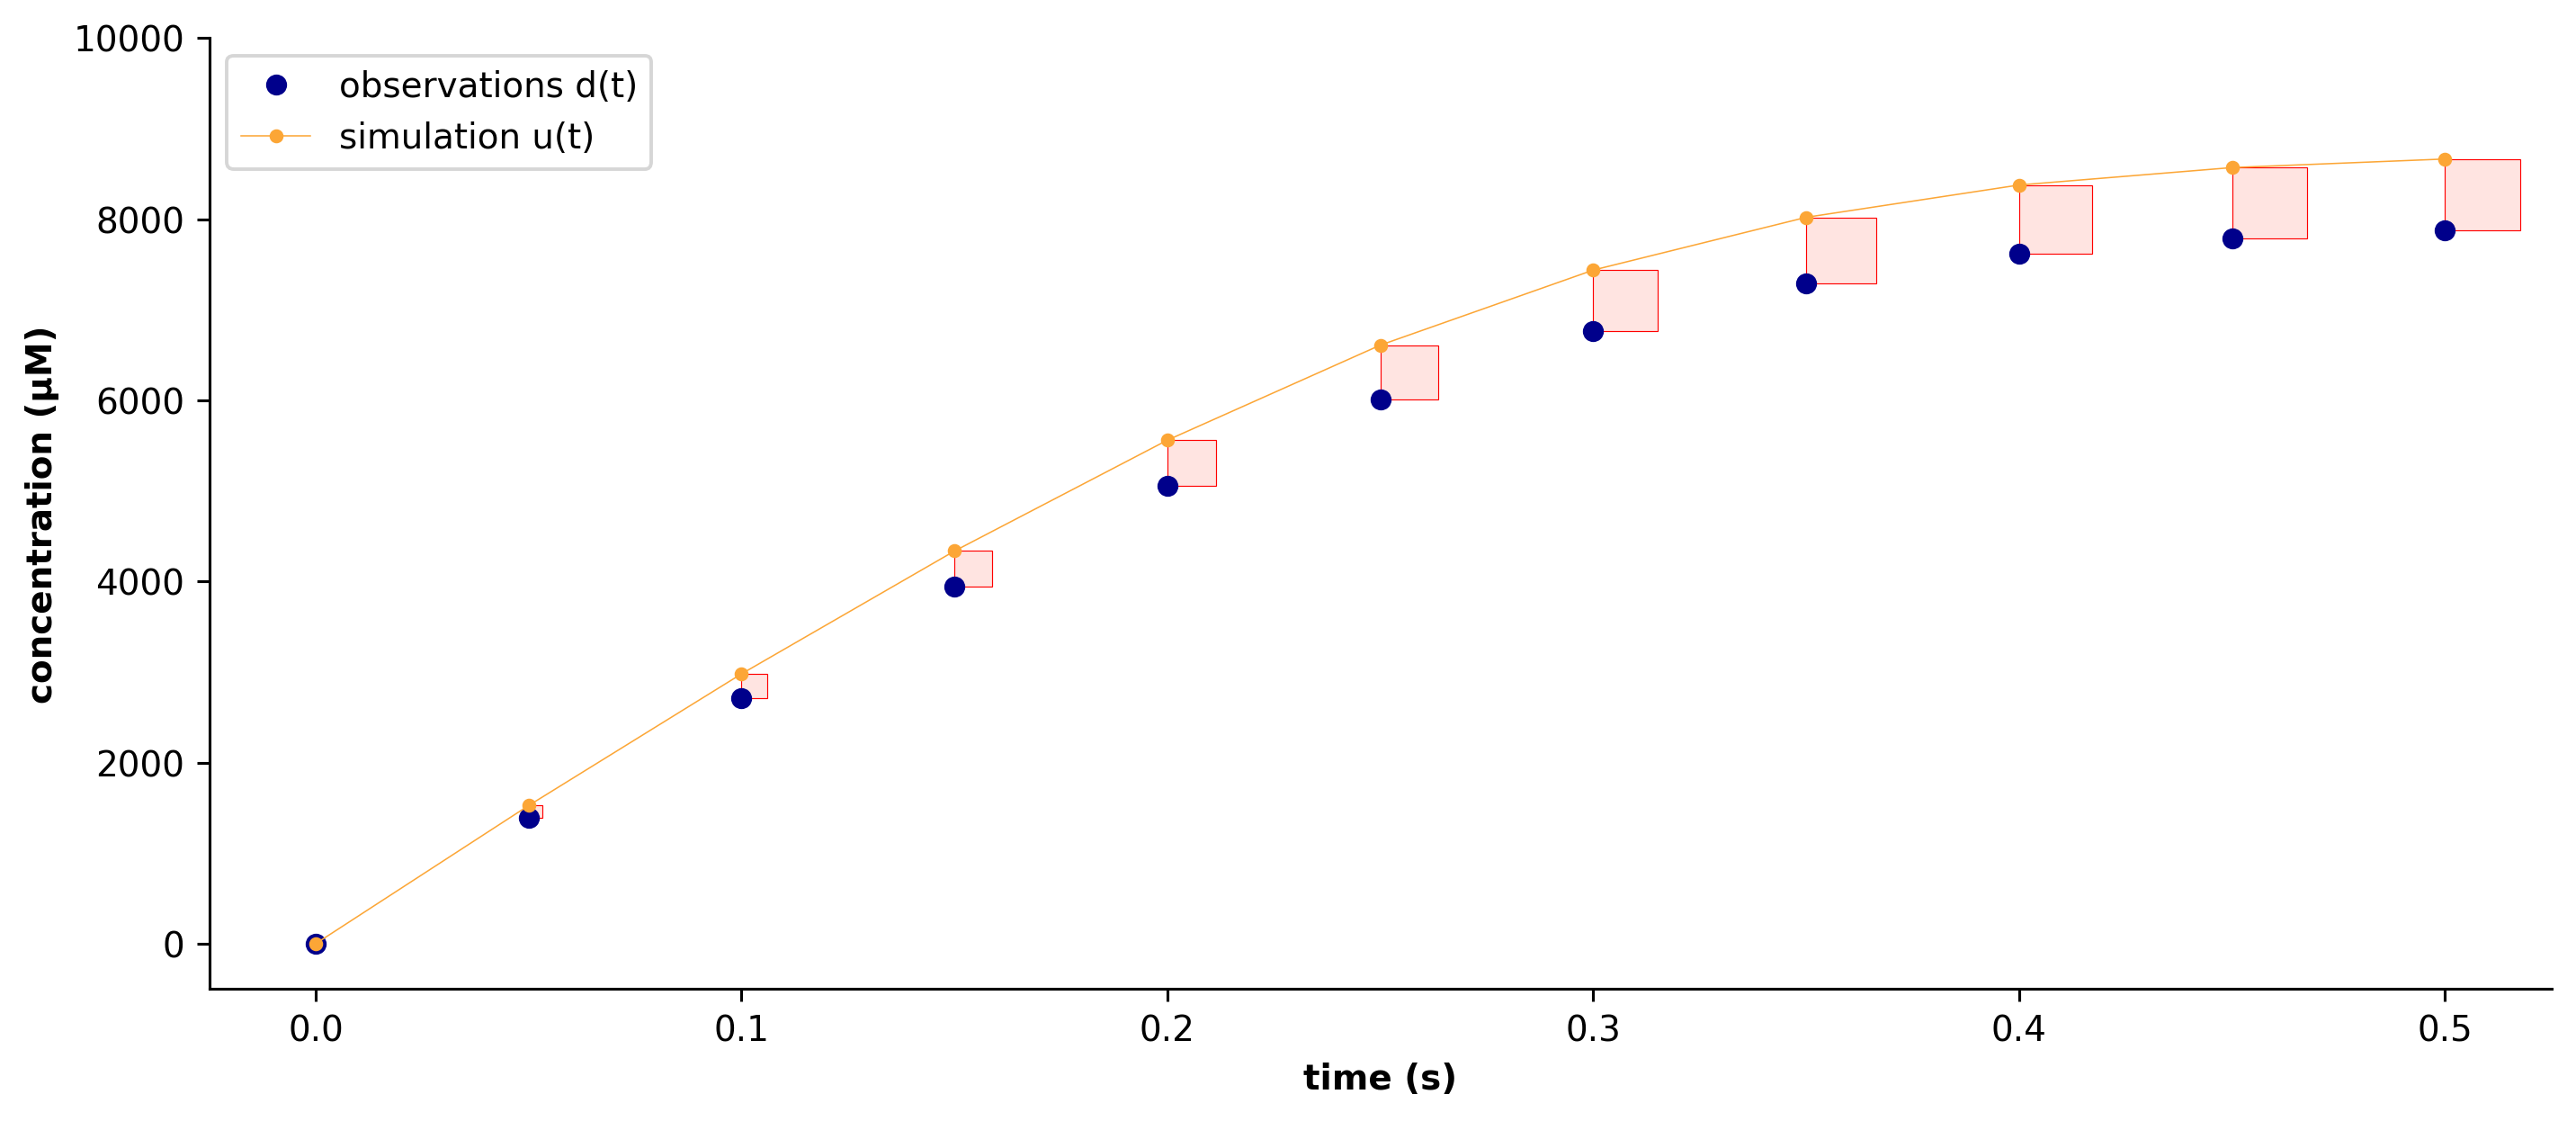

In [57]:
#collapse
# plot intuition for squared loss definition
plt.rcParams['figure.figsize'] = [12, 5]

ax = observations.rename('observations d(t)').plot.line(marker='o', lw=0, color=color(['P']), legend=True, markersize=5, ylim=(-5e2,1e4))
(observations * 1.1).rename('simulation u(t)').plot.line(marker='o', lw=0.4, color=plt.get_cmap('plasma')(0.8), legend=True, markersize=3)

# total_err = 0

for x, y in observations.iloc[1:].items():
    rect = patches.Rectangle((x, y), y*0.1/1e4*0.225, y*0.1, linewidth=1, edgecolor='r', facecolor='mistyrose', lw=0.3)
    ax.add_patch(rect)

fig_style(ax)

#### 3.2.1 Forward Sensitivities

In order to optimize our parameters $\theta$ with respect to to our loss function $G$, we need a means to evaluate the gradient of the loss with respect to the parameters. Naively: 

$$\frac{dG(u(t, \theta))}{d\theta} = 
\frac{d}{d\theta} \sum_t(\| d(t) - u(t, \theta) \|_2)^2 = 
\sum_t \left[ 2(d(t) - u(t, \theta)) \frac{du(t, \theta)}{d\theta} \right]$$

However, the quantity $\frac{du(t, \theta)}{d\theta}$ is not immediately available. We can derive it as follows: 

Our original differential equation is $\frac{du(t, \theta)}{dt} = f(u(t, \theta), \theta)$. If we take $\frac{\partial}{\partial\theta} \left[ \frac{du(t, \theta)}{dt} \right] = \frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right]$, we can rearrange as 
$\frac{d}{dt} \left[ \frac{\partial u(t, \theta)}{\partial\theta} \right] = \frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right]$ and then integrate over $t$ for 

$$\int_{t_0}^T\frac{d}{dt} \left[ \frac{\partial u(t, \theta)}{\partial\theta} \right]dt = \int_{t_0}^T\frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right]dt = 
\int_{t_0}^T \left[ \frac{\partial f}{\partial u} \Big|_{u(t, \theta), \theta} \frac{\partial u}{\partial \theta} \Big|_t  + \frac{\partial f}{\partial \theta} \Big|_{u(t, \theta), \theta} \right] dt$$

Which is exactly $\frac{du(t, \theta)}{d\theta}$. Surprisingly, what we've done is define an ODE whose solution (integral) is the gradient. This ODE is usually called the forward sensitivity ODE. We can solve (integrate) both the original ODE and the sensitivity ODE forwards in time together. 

But first, we need to understand the constituent expressions: $\frac{\partial f}{\partial u} \Big|_{u(t, \theta), \theta}$ , $\frac{\partial u}{\partial \theta} \Big|_t$ and $\frac{\partial f}{\partial \theta} \Big|_{u(t, \theta), \theta}$

Recall, 

$$\frac{du}{dt} = \frac{d}{dt}\begin{bmatrix}[\mathrm{S}] \\ [\mathrm{E}] \\ [\mathrm{ES}] \\ [\mathrm{P}] \end{bmatrix} = \begin{bmatrix}
k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\
k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] + k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
- k_{\mathrm{off}}[\mathrm{ES}] + k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] - k_{\mathrm{cat}}[\mathrm{ES}] + k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] 
\end{bmatrix} = f(u(t, \theta), \theta)$$

$\frac{\partial f}{\partial u} \Big|_{u(t, \theta), \theta}$ is the derivative of the derivative with respect to the state. Since both are 4D, this is a 4x4 Jacobian: 

$$\frac{df}{du} = \begin{bmatrix}\frac{df}{[\mathrm{S}]} & \frac{df}{[\mathrm{E}]} & \frac{df}{[\mathrm{ES}]} & \frac{df}{[\mathrm{P}]} \end{bmatrix} = \begin{bmatrix}
-k_{\mathrm{on}}[\mathrm{E}] & -k_{\mathrm{on}}[\mathrm{S}] & k_{\mathrm{off}} & 0 \\
-k_{\mathrm{on}}[\mathrm{E}] & -k_{\mathrm{on}}[\mathrm{S}] - k_{\mathrm{uncat}}[\mathrm{P}] & k_{\mathrm{off}} + k_{\mathrm{cat}} & -k_{\mathrm{uncat}} \\
k_{\mathrm{on}}[\mathrm{E}] & k_{\mathrm{on}}[\mathrm{S}] + k_{\mathrm{uncat}}[\mathrm{P}] & -k_{\mathrm{off}} - k_{\mathrm{cat}} & k_{\mathrm{uncat}} \\
0 & -k_{\mathrm{uncat}}[\mathrm{P}] & k_{\mathrm{cat}} & -k_{\mathrm{uncat}}
\end{bmatrix}$$


In [58]:
#collapse
# define helper functions for euler_full_sensitivities()
def f_u_Jacobian(S, E, ES, P, k_on, k_off, k_cat, k_uncat):

    return np.array([
        [-k_on * E, -k_on * S, k_off, 0],
        [-k_on * E, -k_on * S - k_uncat * P, k_off + k_cat, -k_uncat],
        [k_on * E, k_on * S + k_uncat * P, -k_off - k_cat, k_uncat],
        [0, -k_uncat * P, k_cat, -k_uncat]
    ])



$\frac{\partial f}{\partial \theta} \Big|_{u(t, \theta), \theta}$ is the derivative of the derivative with respect to one of the parameters. 

$$\frac{\partial f}{\partial k_{\mathrm{on}}} = 
\begin{bmatrix} -[\mathrm{E}][\mathrm{S}] \\ -[\mathrm{E}][\mathrm{S}] \\ [\mathrm{E}][\mathrm{S}] \\ 0 \end{bmatrix}, \qquad
\frac{\partial f}{\partial k_{\mathrm{off}}} = 
\begin{bmatrix} [\mathrm{ES}] \\ [\mathrm{ES}] \\ -[\mathrm{ES}] \\ 0 \end{bmatrix}, \qquad
\frac{\partial f}{\partial k_{\mathrm{cat}}} = 
\begin{bmatrix} 0 \\ [\mathrm{ES}] \\ -[\mathrm{ES}] \\ [\mathrm{ES}] \end{bmatrix}, \qquad
\frac{\partial f}{\partial k_{\mathrm{uncat}}} = 
\begin{bmatrix} 0 \\ -[\mathrm{E}][\mathrm{P}] \\ [\mathrm{E}][\mathrm{P}] \\ -[\mathrm{E}][\mathrm{P}] \end{bmatrix}, \qquad
$$


In [59]:
#collapse
# define helper functions for euler_full_sensitivities()
def f_k_on(S, E, ES, P): return np.array([[-E*S, -E*S, E*S, 0]]).T
def f_k_off(S, E, ES, P): return np.array([[ES, ES, -ES, 0]]).T
def f_k_cat(S, E, ES, P): return np.array([[0, ES, -ES, ES]]).T
def f_k_uncat(S, E, ES, P): return np.array([[0, -E*P, E*P, -E*P]]).T



$\frac{\partial u}{\partial \theta} \Big|_t$ is the variable of integration, which means we only need to define a boundary condition for it, in this case, an initial value: 

$$ \frac{\partial u}{\partial \theta} \Big|_{t_0} = \frac{\partial}{\partial \theta} u(0, \theta) $$

But since in our case $u(0, \theta) = u(0) = 0$ does not depend on $\theta$, $\frac{\partial u}{\partial \theta} \Big|_{t_0} = 0$. 

Now we're ready to augment our original Euler method to compute both $\int_{t_0}^T\frac{du(t, \theta)}{dt} dt$ as before and add $\int_{t_0}^T\frac{\partial}{\partial\theta} \left[ f(u(t, \theta), \theta) \right] dt$. 

In [60]:
#collapse
# define euler_full_sensitivities(), which integrates the full kinetics and sensitivity ODE with Euler's Method
def euler_full_sensitivities(dt, steps, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):

    S = S_0
    E = E_0
    ES = 0
    P = 0

    u_k_on = np.zeros((4,1))
    u_k_off = np.zeros((4,1))
    u_k_cat = np.zeros((4,1))
    u_k_uncat = np.zeros((4,1))

    traj = [[S, E, ES, P, *u_k_on.flatten(), *u_k_off.flatten(), *u_k_cat.flatten(), *u_k_uncat.flatten()]]

    for i in range(int(steps)):

        S += (k_off * ES - k_on * E * S) * dt
        E += (k_off * ES - k_on * E * S + k_cat * ES - k_uncat * E * P) * dt
        ES += (k_on * E * S - k_off * ES - k_cat * ES + k_uncat * E * P) * dt
        P += (k_cat * ES - k_uncat * E * P) * dt

        f_u = f_u_Jacobian(S, E, ES, P, k_on, k_off, k_cat, k_uncat)

        u_k_on += (f_u @ u_k_on + f_k_on(S, E, ES, P)) * dt
        u_k_off += (f_u @ u_k_off + f_k_off(S, E, ES, P)) * dt
        u_k_cat += (f_u @ u_k_cat + f_k_cat(S, E, ES, P)) * dt
        u_k_uncat += (f_u @ u_k_uncat + f_k_uncat(S, E, ES, P)) * dt

        traj.append([S, E, ES, P, *u_k_on.T[0].copy(), *u_k_off.T[0].copy(), *u_k_cat.T[0].copy(), *u_k_uncat.T[0].copy()])

    return pd.DataFrame(traj, columns=['S', 'E', 'ES', 'P',
                                       'S_k_on', 'E_k_on',  'ES_k_on',  'P_k_on',
                                       'S_k_off', 'E_k_off',  'ES_k_off',  'P_k_off',
                                       'S_k_cat', 'E_k_cat',  'ES_k_cat',  'P_k_cat',
                                       'S_k_uncat', 'E_k_uncat', 'ES_k_uncat', 'P_k_uncat'], index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6))

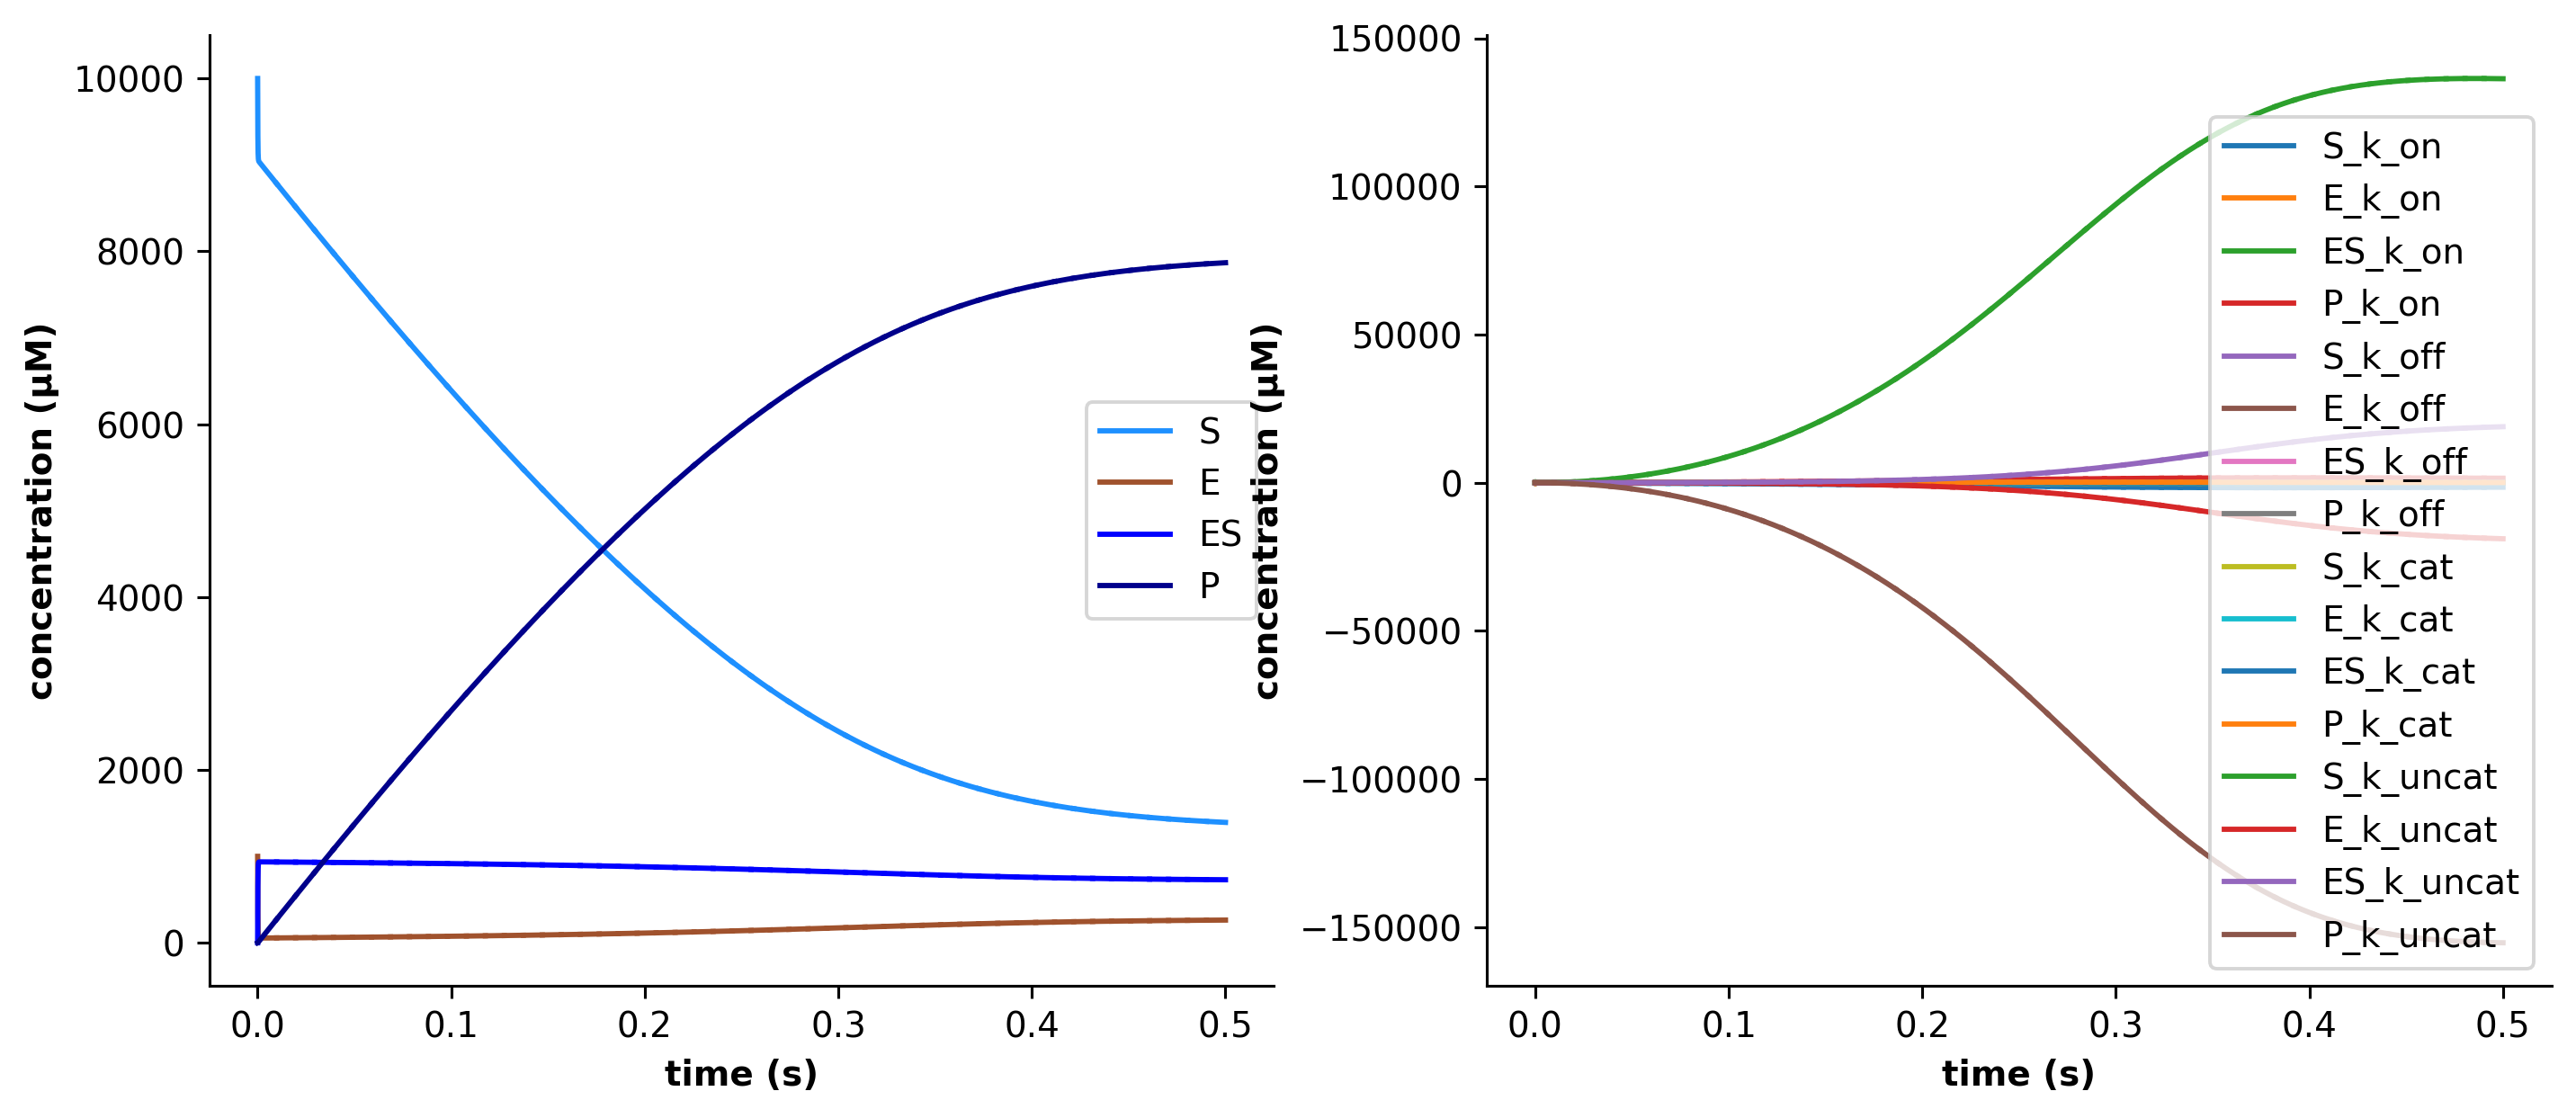

In [62]:
traj_euler_sensitivities = euler_full_sensitivities(dt, steps, **default_initial_conditions, **default_kinetic_params)

ODE_columns = traj_euler_sensitivities.columns[:4]
sensitivity_columns = traj_euler_sensitivities.columns[4:]
P_sensitivity_columns = traj_euler_sensitivities.columns[7::4]

fig, axs = plt.subplots(1, 2)
traj_euler_sensitivities[ODE_columns].plot.line(ax=axs[0], color=color(ODE_columns))
traj_euler_sensitivities[sensitivity_columns].plot.line(ax=axs[1])

fig_style(axs[0])
fig_style(axs[1])

Unfortunately, as before, our simple-minded python code, although conceptually helpful, is too slow to use repeatedly inside a loop. Let's once again re-structure this code for scipy. 

In [116]:
#collapse
# define scipy_full_sensitivities (and helpers), which integrates the full kinetics and sensitivities with scipy
def dy_full_sensitivities(t, y, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
    # Y ordered S,E,ES,P
    dy = np.zeros(20)

    dy[0] = k_off * y[2] - k_on * y[1] * y[0]
    dy[1] = k_off * y[2] - k_on * y[1] * y[0] + k_cat * y[2] - k_uncat * y[1] * y[3]
    dy[2] = k_on * y[1] * y[0] - k_off * y[2] - k_cat * y[2] + k_uncat * y[1] * y[3]
    dy[3] = k_cat * y[2] - k_uncat * y[1] * y[3]

    f_u = f_u_Jacobian(*y[0:4], k_on, k_off, k_cat, k_uncat)

    dy[4:8] = np.dot(f_u, y[4:8]) + f_k_on(*y[0:4]).T
    dy[8:12] = np.dot(f_u, y[8:12]) + f_k_off(*y[0:4]).T
    dy[12:16] = np.dot(f_u, y[12:16]) + f_k_cat(*y[0:4]).T
    dy[16:20] = np.dot(f_u, y[16:20]) + f_k_uncat(*y[0:4]).T

    return dy

cols = [v+u for u in ['', '_k_on', '_k_off', '_k_cat', '_k_uncat'] for v in ['S', 'E', 'ES', 'P']]

def scipy_full_sensitivities(dt, steps, kinetic_params, E_0=None, S_0=None):

    t_eval = observations.index
    t_span = (0, t_eval[-1])
    y0 = [S_0, E_0, 0, 0] + [0]*16
    # kinetic_params = {name: 10**val for name, val in kinetic_params.items()}
    fun = lambda t,y: dy_full_sensitivities(t, y, E_0=E_0, S_0=S_0, **kinetic_params)

    try:
        sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, first_step=dt, max_step=1e-2, method='LSODA')
        return pd.DataFrame(sol.y.T, index=sol.t, columns=cols)
    except:
        return pd.DataFrame(columns=cols)




'our naïve code takes 21.9s, whereas the optimized scipy code takes 0.2809s to generate the same trajectory.'

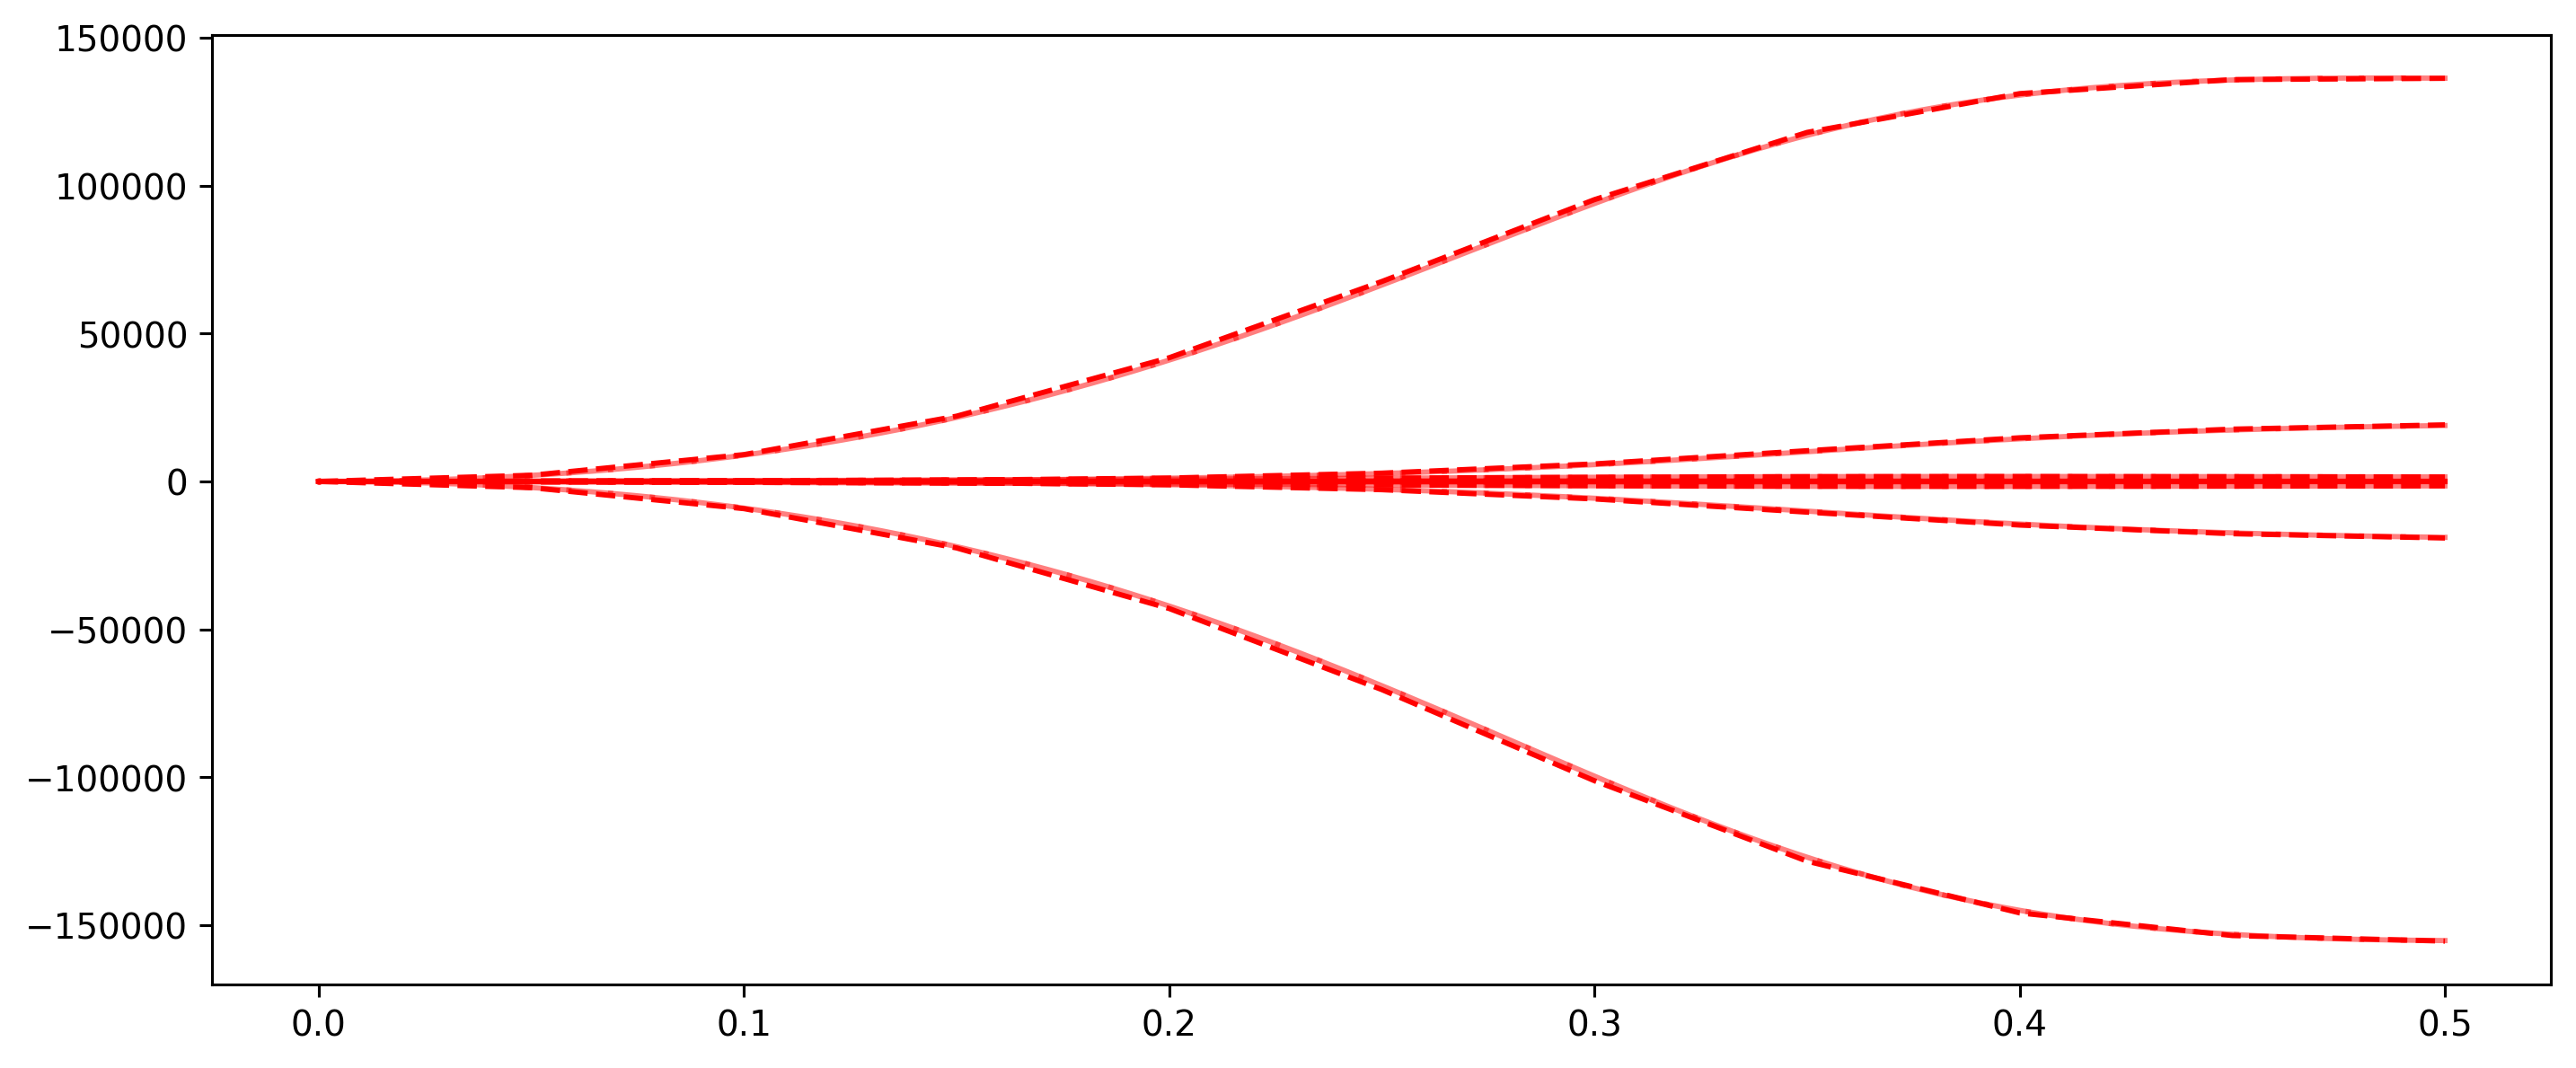

In [127]:
#collapse
# benchmark our naive code against scipy's integrator for the sensitivity equations
start = time.process_time()
traj_scipy_sensitivities = scipy_full_sensitivities(dt, steps, default_kinetic_params, **default_initial_conditions)
scipy_time = time.process_time() - start

start = time.process_time()
traj_euler_sensitivities = euler_full_sensitivities(dt, steps, **default_initial_conditions, **default_kinetic_params)
euler_time = time.process_time() - start

ax = traj_euler_sensitivities[sensitivity_columns].plot.line(color='r', alpha=0.5, legend=False)
traj_scipy_sensitivities[sensitivity_columns].plot.line(ax=ax, color='r', linestyle='--', legend=False)

f'our naïve code takes {round(euler_time, 2)}s, whereas the optimized scipy code takes {round(scipy_time, 4)}s to generate the same trajectory.'

Recall, computing the sensitivity of the solution with respect to the parameters $\frac{du(t, \theta)}{d\theta}$ was in service of computing the gradient of our loss function with respect to the parameters: 

$$\frac{dG(u(t, \theta))}{d\theta} = 
\sum_t \left[ 2(d(t) - u(t, \theta)) \frac{du(t, \theta)}{d\theta} \right]$$

Now, since we set up this problem such that we only observe $\{ \color{00008b}{ [\mathrm{P}]_t } \color{black}{ \} }$, we are only able to compare the integrated kinetics of $\{ \color{blue}{ [\mathrm{P}]_t } \color{black}{ \} }$ and so our gradient expression becomes: 

$$\frac{dG(u(t, \theta))}{d\theta} = 
\sum_t \left[ 2(\color{00008b}{ [\mathrm{P}]_t } \color{black}{ - \color{blue}{ [\mathrm{P}]_t } \color{black}{ ) \frac{d\color{blue}{ [\mathrm{P}]_t }}{d\theta} }} \right]$$


In [131]:
#collapse
# define gradient_of_loss() which returns the gradient of the loss with respect to each parameter

P_sensitivity_columns = traj_euler_sensitivities.columns[7::4]

def gradient_of_loss(integrated_system_and_sensitivities):

    diff = 2*(observations - integrated_system_and_sensitivities.loc[observations.index, 'P'])
    P_k = integrated_system_and_sensitivities.loc[observations.index, P_sensitivity_columns]
    return P_k.multiply(diff, axis='rows').sum().to_dict()


<AxesSubplot:>

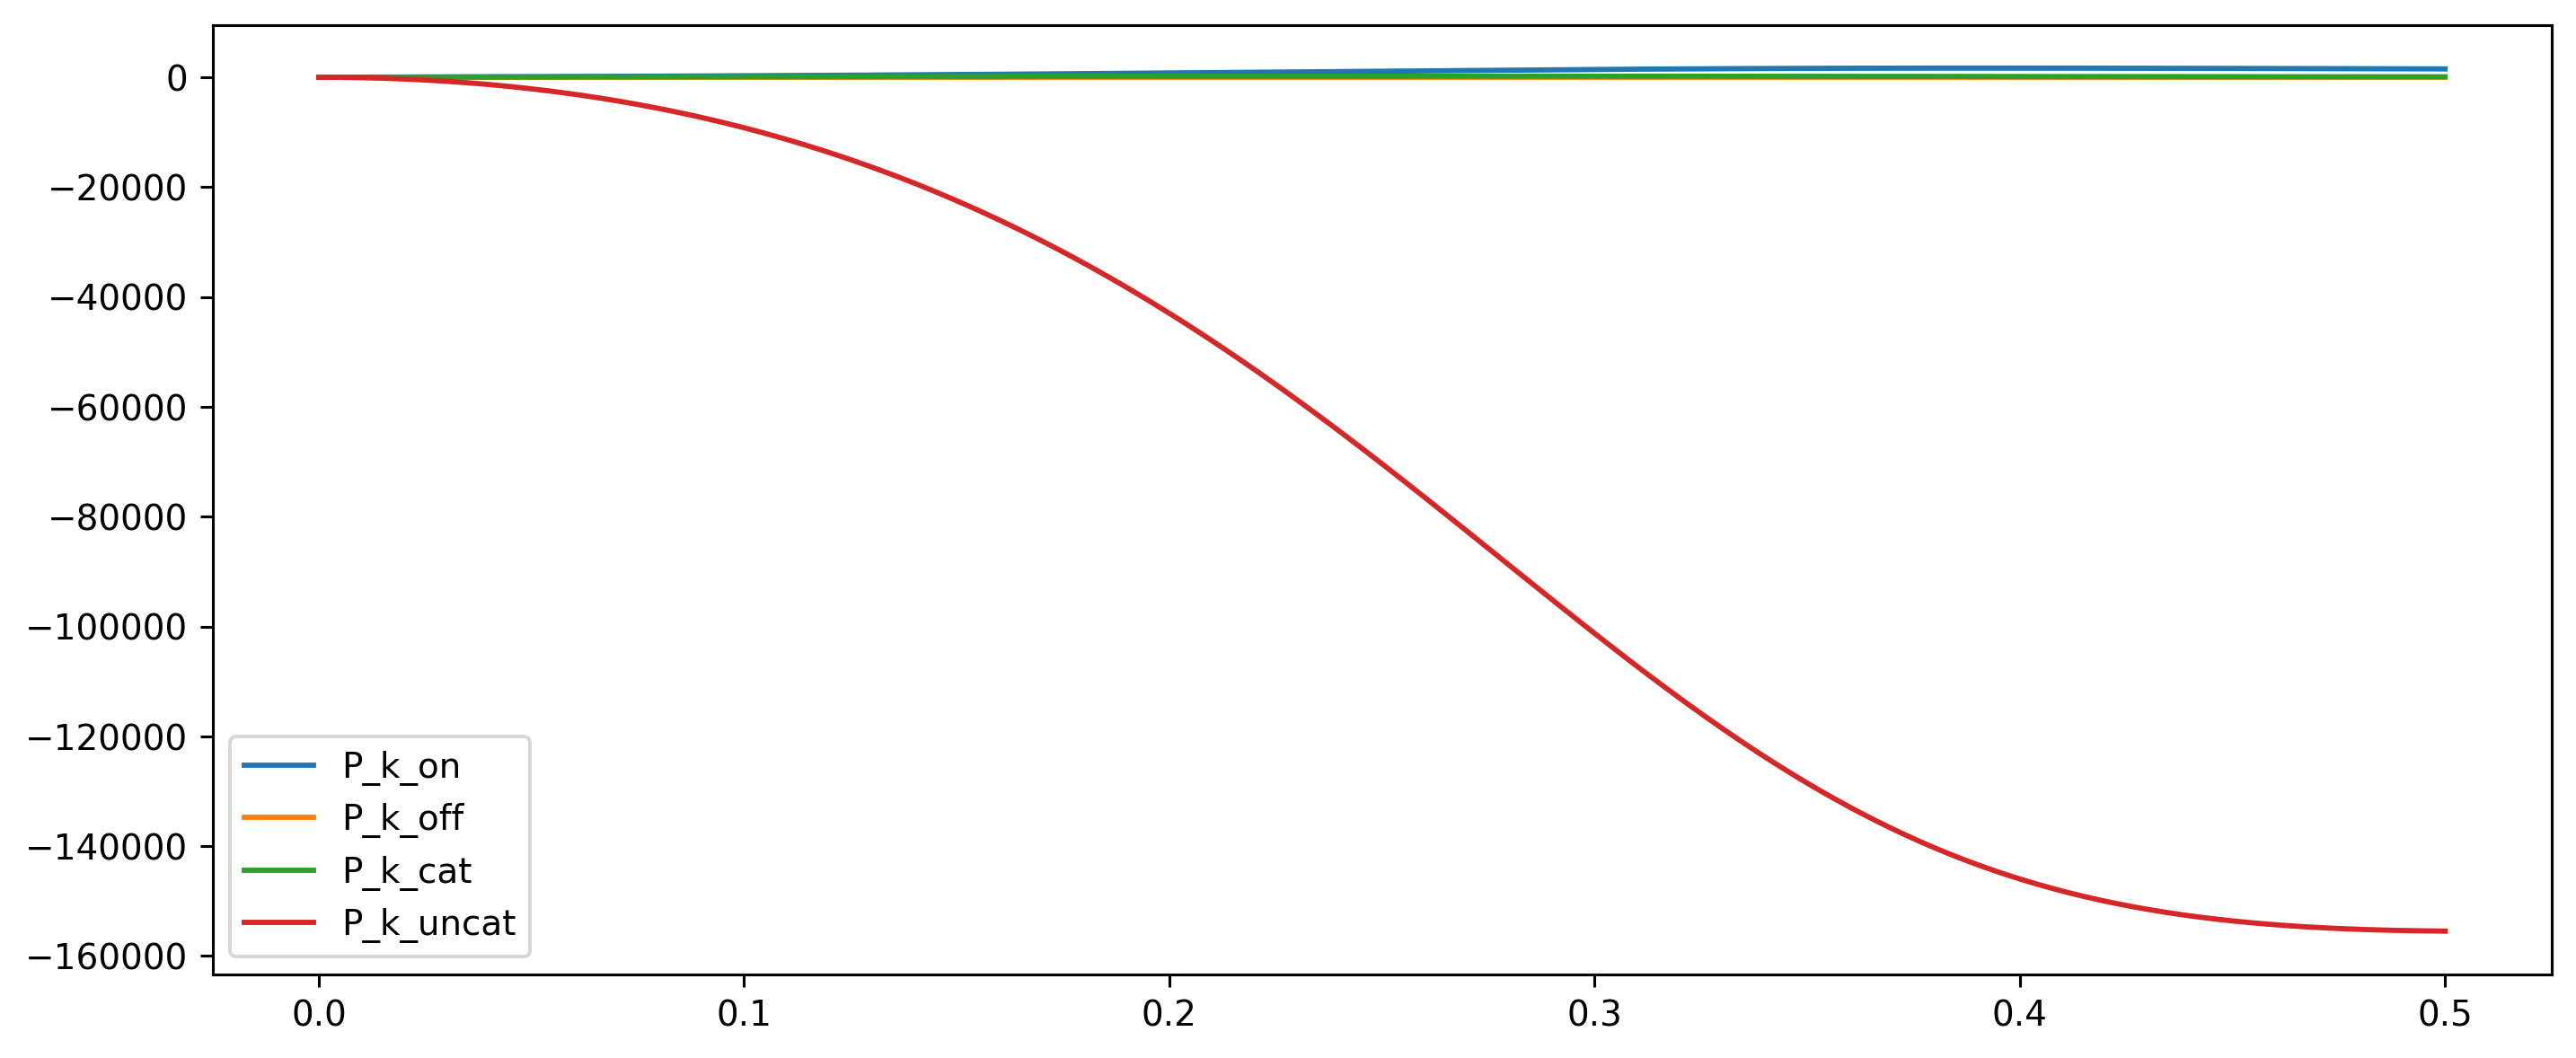

In [78]:
traj_scipy_sensitivities[P_sensitivity_columns].plot.line()

We notice right away the scale of some of these sensitivities reaches $O(10^6)$. That may be because the parameters span many orders of magnitude, so the sentivities of the system to small perturbations in some parameters may be much greater than others. 

We've set ourselves the task of optimizing the 4 parameters in the Michaelis-Menten/Briggs-Haldane kinetics ODE to minimize the squared error with respect to an observed timeseries. In order to intialize this optimization routine, we need somewhere to start from. Let's use the means of the prior distributions (from [§3.1.1](#3.1.1)) for each parameter as a starting point. 

In [79]:
θ_0 = {'k_on': 10**log_kon_normal.mean(),
       'k_off': 10**log_koff_normal.mean(),
       'k_cat': 10**log_kcat_normal.mean(),
       'k_uncat': 10**log_kuncat_normal.mean()}

Our gradient descent routine iterates a loop: 
1. Integrate the system ODE and sensitivity ODE with the current parameters.
2. Compute the gradient of the loss with the current parameters. 
3. Update the parameters with a gradient step

In [151]:
def loss(u): return np.linalg.norm(observations - u.loc[observations.index, 'P'])**2


def gradient_descent(θ_0):

    record = []
    θ_t = θ_0
    α = 1

    for _ in range(100):

        u = scipy_full_sensitivities(dt, steps, θ_t, **default_initial_conditions)

        record.append((loss(u), θ_t, u))

        G_θ = gradient_of_loss(u)
        G_θ_norm = np.linalg.norm(list(G_θ.values()))
        θ_t = {k: θ_t[k] - (α * G_θ['P_'+k] / G_θ_norm) for k in θ_t.keys()}

    return record


In [152]:
optimization_record = gradient_descent(θ_0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __na

In [153]:
pd.DataFrame([θ_t for loss, θ_t, u in optimization_record])

k_on       k_off        k_cat   k_uncat
0   0.002302  169.908844  1940.913256  0.001608
1  -0.996724  169.908845  1940.913256  0.045736
2        NaN         NaN          NaN       NaN
3        NaN         NaN          NaN       NaN
4        NaN         NaN          NaN       NaN
..       ...         ...          ...       ...
95       NaN         NaN          NaN       NaN
96       NaN         NaN          NaN       NaN
97       NaN         NaN          NaN       NaN
98       NaN         NaN          NaN       NaN
99       NaN         NaN          NaN       NaN

[100 rows x 4 columns]

#### 3.2.2. Adjoint Method


How is Adjoint better? how does it scale differently with parameters?

$$

$$

In [ ]:
#collapse
# define euler_full(), which integrates the full kinetics with Euler's Method, and returns a trajectory
def adjoint_euler_full(dt, steps, u=None, data=None, k_on=None, k_off=None, k_cat=None, k_uncat=None):

    λ = np.zeros(min(u.shape))
    traj = [λ]

    for step in range(int(steps)):

        S, E, ES, P = u[-step]

        dgdu = np.zeros(min(u.shape))
        if step in data:
            dgdu = 2*(data[step] - u[step])

        # dfdu is a Jacobian
        dfdu = np.array([
            [-k_on * E, -k_on * S, k_off, 0],
            [-k_on * E, -k_on * S - k_uncat * P, k_off + k_cat, -k_uncat],
            [-k_on * E, k_on * S + k_uncat * P, -k_off - k_cat, k_uncat],
            [0, k_uncat * P, k_cat, -k_uncat]
        ])

        dλ = -λ @ dfdu - dgdu

        λ += dλ * dt

        traj.append(float(λ))

    return traj[::-1]

In [ ]:
# algorithm:
# 1. solve forwards: euler_full
# 2. solve adjoint DE
# 3. evaluate integral

In [ ]:
adjoint_euler_full(dt, steps, u=, data=default_traj_full.values, *kinetic_params)

In [ ]:
def integrate(kinetic_params, dt=dt, initial_conditions=default_initial_conditions):

    [(_, E_0), (_, S_0)] = initial_conditions.items()
    t_eval = observations.index[1:]
    t_span = (0, t_eval[-1])
    y0 = [S_0, E_0, 0, 0]
    kinetic_params = {name: 10**val for name, val in kinetic_params.items()}
    fun = lambda t,y: dy_full(t, y, E_0=E_0, S_0=S_0, **kinetic_params)

    try:
        sol = solve_ivp(fun, t_span, y0, t_eval=t_eval, first_step=dt, max_step=1e-2, method='LSODA')
        return sol.y[3] # Product
    except:
        return np.zeros(10)



# 4. Conclusions

Michaelis menten isn't even right, that's why the databases are such a mess. You need the right scheme, and the right equations

# 5. References

- [Gradient Descent for ODEs by Demetri Pananos](https://dpananos.github.io/posts/2019/05/blog-post-14/)

- [A Database of Thermodynamic Quantities for the Reactions of Glycolysis and the Tricarboxylic Acid Cycle](https://pubs.acs.org/doi/10.1021/jp911381p)

- [A database of thermodynamic properties of the reactions of glycolysis, the tricarboxylic acid cycle, and the
pentose phosphate pathway](https://academic.oup.com/database/article/doi/10.1093/database/bar005/462082)

- [Thermodynamics of Glycolysis](https://chem.libretexts.org/Bookshelves/General_Chemistry/Book%3A_Structure_and_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_(Schaller)/III%3A_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_1/08%3A_Mechanisms_of_Glycolysis/8.08%3A_Thermodynamics_of_Glycolysis)

- [BKMS-React database entry for glycolysis](http://bkms-react.tu-bs.de/pathway.php?pw_id=pw_glycolysis&ecno=1.2.1.12&id=50)

- [Bistability in Glycolysis Pathway as a Physiological Switch in Energy Metabolism](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098756#pone.0098756.s012)

- [Determination of the rate of hexokinase-glucose dissociation by the isotope-trapping method](https://www.jbc.org/content/249/16/5163.full.pdf)

- [Quantitative Fundamentals of Molecular and Cellular Bioengineering](https://mitpress.mit.edu/books/quantitative-fundamentals-molecular-and-cellular-bioengineering)